[View in Colaboratory](https://colab.research.google.com/github/jnareb/git-commit-graph-ext/blob/master/Graphs_FELINE_index.ipynb)

Graphs in Python

* [Network Chart - The Python Graph Gallery](https://python-graph-gallery.com/network-chart/)
  * [NetworkX library](https://networkx.github.io/documentation/stable/index.html) -- data structures for graphs
    (or networks) along with graph algorithms, generators, and drawing tools
  * [Graph Tool library](https://graph-tool.skewed.de/) -- the core data structures and algorithms
    are implemented in C++  
    drawing in Jupyter described e.g. in <https://gist.github.com/jg-you/2ce69ffccf6f3ed17c09e5d7b2695f1c>

* [Snap.py](http://snap.stanford.edu/snappy/index.html) is a Python interface for SNAP
  (Stanford Network Analysis Platform). [SNAP](http://snap.stanford.edu/snap/) is a general purpose,
  high performance system in C++ for analysis and manipulation of large networks.
  
* [python-graph](https://github.com/Shoobx/python-graph) (???)



FELINE index

"Reachability Queries in Very Large Graphs: A Fast Refined Online Search Approach" (2014)  
<http://openprocedings.org/EDBT/2014/paper_166.pdf>

----

min-post spanning-tree interval labeling (description)

"GRAIL: Scalable Reachability Index for Large Graphs" (2010)  
<https://www.researchgate.net/publication/220538786_GRAIL_Scalable_reachability_index_for_large_graphs>

----

other pruning mechanisms with min-post / pre-max DFS spanning-tree interval labeling

"PReaCH: A Fast Lightweight Reachability Index using Pruning and Contraction Hierarchies" (2014)  
<https://arxiv.org/abs/1404.4465>

In [489]:
# memory footprint support libraries/code
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize
import psutil
import humanize
import os
#import GPUtil as GPU
#GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
#gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: {0:s} | I Proc size {1:s} (RSS)".format(
      humanize.naturalsize( psutil.virtual_memory().available ), 
      humanize.naturalsize( process.memory_info().rss )))
  #print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  
printm()

Gen RAM Free: 12.7 GB | I Proc size 429.2 MB (RSS)


**Table of contents**

>>[FELINE index: NetworkX and matplotlib visualization](#scrollTo=YfZ3QVnv3XpN)

>>>[Crown DAG know as $S_3^0$ graph](#scrollTo=UcFgrrGRWozd)

>>>[Small DAG (example in Figure 2)](#scrollTo=uWUbIuPRW4Ze)

>>>[Didactic example of search space reduction](#scrollTo=Obk2giojprpS)

>>>[Optimizations: Level Filter (negative-cut)](#scrollTo=_87BlZdX6tBl)

>>>[Optimizations: min-post interval (positive-cut filter)](#scrollTo=_rP8JdufWvCd)

>>>[Optimization: min-post / pre-max DFS interval (positive-cut and negative-cut)](#scrollTo=WA1mc9PNOmZe)

>>>[Optimization: Reachability Contraction Hierarchies (from PReaCH)](#scrollTo=jRCySqjWg4wg)

>>[Algorithms](#scrollTo=5dI9rZ92OFXg)

>>>[Starter / preliminary algorithms](#scrollTo=VugXLha7SrZQ)

>>>>[Tips / heads](#scrollTo=TzISTJktS6jt)

>>>>[Spanning tree / spanning forest](#scrollTo=2ZxiafIZWayY)

>>>>[Reach of the node](#scrollTo=Q8vaDlTD0TSe)

>>>[Optimizations algorithms](#scrollTo=fOamYN7y3ZG5)

>>>>[Levels](#scrollTo=ewJDfAE-3jQo)

>>>>[Min-post intervals](#scrollTo=kVCGZQcS3nFi)

>>>>[DFS spanning-tree extra data](#scrollTo=1tsblSSZlYkg)

>>>[FELINE-index algorithms](#scrollTo=iFR7yqyJ71TN)

>>>>[Calculating FELINE index](#scrollTo=Wl2yteSU78UO)

>>>>[Quality of FELINE index (and comparison with paper's version)](#scrollTo=6tp3wTcP7Wcq)

>>>>[Reachability queries with FELINE index](#scrollTo=cSNGubgZ8Eyc)

>>>>[Reachability query stats for sample](#scrollTo=9Lw6Cg4CaFti)

>>>>[Weak dominance drawing (and related drawing algorithms)](#scrollTo=OcdSmPxh8Q2_)

>>>>[TODO: Reverse FELINE index](#scrollTo=NHjQ0g7_IaVl)

>>[Version control graphs](#scrollTo=Nga1c33bMlWN)

>>>[git.git commit graph](#scrollTo=Wn715kAEhcoo)

>>>>[Draw fragment of git.git commit graph](#scrollTo=4U33EFnMq7qI)

>>>>[Draw fragment of larger part of git.git commit graph](#scrollTo=Wt7Gz8hpu7eR)

>>>>[Full git.git commit graph and its properties](#scrollTo=4GULcY75vTbn)

>>>>[Finding paths / checking reachability between two commits](#scrollTo=7zdcHrIF16am)

>>>>[N^2 connectivity on [random sample of] commit graph nodes](#scrollTo=T2UuQefM4E57)

>>>[Linux kernel commit graph](#scrollTo=mK2BzqFKETax)

>>>>[Full linux kernel commit graph and its properties](#scrollTo=bMdzTWdb2KLw)

>>>>[Finding paths / checking reachability between two commits](#scrollTo=YiRqzbSBmFg7)

>>>>[N^2 connectivity on random sample of commits / nodes](#scrollTo=am1Tt5VxmV2E)



## FELINE index: NetworkX and matplotlib visualization

In [0]:
#@title Installing packages: graph-tool (commented-out)
#!apt-get install dirmngr --install-recommends
#!echo "deb http://downloads.skewed.de/apt/artful artful universe" >/etc/apt/sources.list.d/graph-tool.list
#!echo "deb-src http://downloads.skewed.de/apt/artful artful universe" >>/etc/apt/sources.list.d/graph-tool.list
#!apt-key adv --keyserver pgp.skewed.de --recv-key 612DEFB798507F25
#!apt-get -q update
#!apt-get install python-graph-tool

In [491]:
#@title Imports for graphs (NetworkX and matplotlib)
import networkx as nx
import matplotlib.pyplot as plt
#import graph_tool.all as gt
nx

<module 'networkx' from '/usr/local/lib/python2.7/dist-packages/networkx/__init__.pyc'>

See <https://networkx.github.io/documentation/stable/auto_examples/index.html> for examples

In [492]:
#@title Imports SciPy modules
import numpy as np
import pandas as pd
pd

<module 'pandas' from '/usr/local/lib/python2.7/dist-packages/pandas/__init__.pyc'>

### Crown DAG know as $S_3^0$ graph

In [493]:
#@title Create a crown DAG known as $S_3^0$ graph
DG=nx.DiGraph()
DG.add_nodes_from([1,2,3,4,'u','v'])
DG.add_edges_from([(1,2),(3,4),(1,'v'),(3,'v'),('u',2),('u',4)])
DG

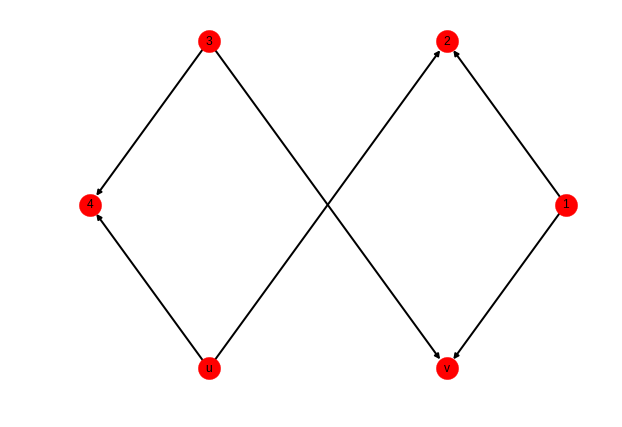

In [494]:
#@title Draw the $S_3^0$ graph using [automatic] shell layout
nx.draw_shell(DG,with_labels=True,node_size=500,width=2.0)

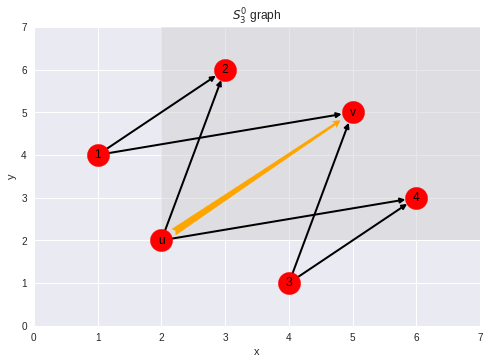

In [495]:
#@title Draw the $S_3^0$ graph using weak dominance drawing
from matplotlib.patches import Rectangle, FancyArrowPatch

ax=plt.gca()
ax.add_patch(Rectangle((2,2), 5, 5, facecolor="lightgrey",alpha=0.5))
ax.add_patch(
    FancyArrowPatch((2,2),(5,5),
                    shrinkA=15,shrinkB=15,
                    arrowstyle='fancy',mutation_scale=18,
                    linestyle='dashed',hatch='\\',color='orange')
)

plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('$S_3^0$ graph')
plt.xlim(xmin=0,xmax=7)
plt.ylim(ymin=0,ymax=7)

DG.pos={1:(1,4),2:(3,6),'u':(2,2),3:(4,1),4:(6,3),'v':(5,5)}
nx.draw_networkx(DG,pos=DG.pos,
                 node_size=500,width=2.0,label='$S_3^0$ graph')

Above figure is an example of exception between $u$ and $v$.  The shaded part is dominance region of $u$.  The orange arrow is *falsely-implied path* or a *false-positive*; node $v$ lies in shaded region, but there is no path from $u$ to $v$.

### Small DAG (example in Figure 2)

In [496]:
#@title Create a small DAG
sd=nx.DiGraph()
sd.add_nodes_from([chr(c) for c in range(ord('a'),ord('h')+1)])
sd.add_edges_from([('a','c'),('a','d'),('a','e'),('b','f'),('b','g'),('c','h'),('e','h'),('f','h')])
sd

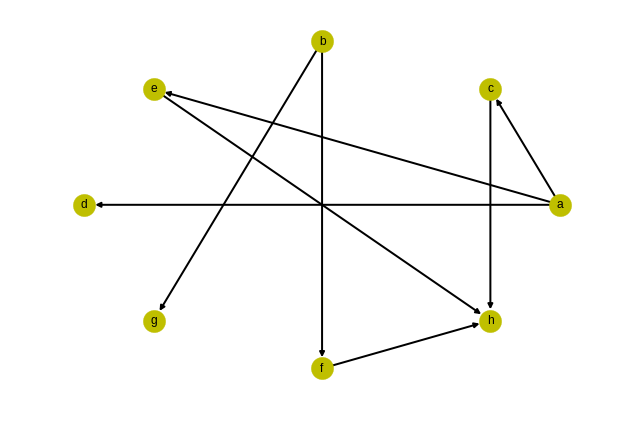

In [497]:
#@title Draw a small DAG using [automatic] shell layout
nx.draw_shell(sd,with_labels=True,node_size=500,width=2.0,node_color='y')

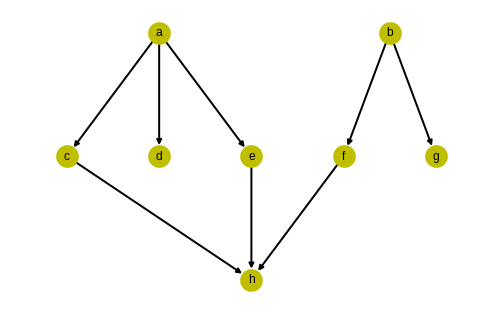

In [498]:
#@title Draw a small DAG, as in Figure 2 (levels-based)
limits = plt.axis('off')
nx.draw_networkx(sd,
                 pos={'a':(2,3),'b':(4.5,3),'c':(1,2),'d':(2,2),'e':(3,2),'f':(4,2),'g':(5,2),'h':(3,1)},
                 node_size=500,width=2.0,node_color='y')

The drawing of a small DAG: the DAG

In [499]:
#@title Small DAG index as DataFrame
sd.x=np.array([1,5,2,3,4,6,8,7])
sd.y=np.array([4,1,7,6,5,3,2,8])
sd.idx=pd.DataFrame({'X':sd.x,'Y':sd.y},index=sorted(sd.nodes.keys()))
sd.idx

,X,Y
a,1,4
b,5,1
c,2,7
d,3,6
e,4,5
f,6,3
g,8,2
h,7,8


The drawing od a small DAG: the related index, where each row represents the coordinate of a vertex

In [500]:
#@title Small DAG index as dict
#{key: (x,y) for key in sd.idx.index for (x,y) in sd.idx.loc[key].values}
sd.pos={}
for key in sd.idx.index:
  (x,y)=sd.idx.loc[key].values
  sd.pos[key]=(x,y)

sd.pos

{'a': (1, 4),
 'b': (5, 1),
 'c': (2, 7),
 'd': (3, 6),
 'e': (4, 5),
 'f': (6, 3),
 'g': (8, 2),
 'h': (7, 8)}

('a', 1, 4)
('c', 2, 7)
('b', 5, 1)
('e', 4, 5)
('f', 6, 3)


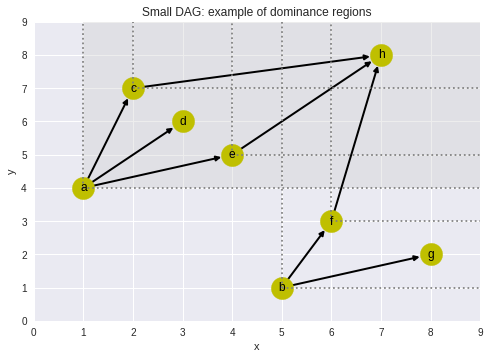

In [501]:
#@title Draw small DAG using weak dominance drawing
from matplotlib.patches import Rectangle

ax=plt.gca()
ax.add_patch(Rectangle(sd.pos['a'], 8, 5, facecolor="lightgrey",alpha=0.4))

for node in sd.nodes:
  if sd.out_degree(node) == 0:
    continue
  (vx,vy)=sd.pos[node]
  print(node,vx,vy)
  plt.axhline(xmin=vx/9.0,y=vy,color='0.5', ls=':')
  plt.axvline(x=vx,ymin=vy/9.0,color='0.5', ls=':')

plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Small DAG: example of dominance regions')
plt.xlim(xmin=0,xmax=9)
plt.ylim(ymin=0,ymax=9)

nx.draw_networkx(sd,pos=sd.pos,
                 node_size=500,width=2.0,node_color='y')

Example of dominance regions for the drawing of a small DAG (Figure 3).

### Didactic example of search space reduction

In [502]:
#@title Create a didactic example of a DAG (a tree)
de=nx.DiGraph()
de.add_nodes_from([chr(c) for c in range(ord('a'),ord('i')+1)])
de.add_edges_from([('a','b'),('a','c'),('a','d'),
                   ('b','e'),('b','f'),
                   ('c','g'),
                   ('d','h'),('d','i')])
de

['a', 'b', 'e', 'f', 'c', 'g', 'd', 'h', 'i']
['a', 'd', 'i', 'h', 'c', 'g', 'b', 'f', 'e']


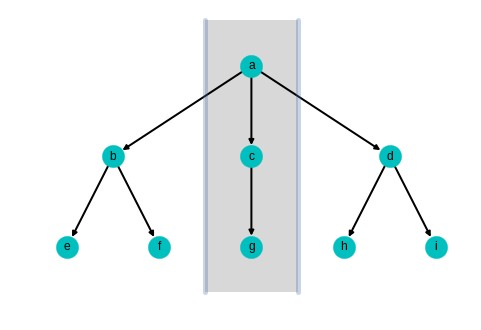

In [503]:
#@title Draw a didactic example of a DAG, as in Figure 6 (levels-based)
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.axis('off')
de.tree={
  'a':(3,3),
  'b':(1.5,2),'c':(3,2),'d':(4.5,2),
  'e':(1,1),'f':(2,1),'g':(3,1),'h':(4,1),'i':(5,1)
}

ax=plt.gca()
ax.add_patch(Rectangle((2.5,0.5), 1, 3, facecolor="grey",alpha=0.3))
ax.add_line(Line2D([2.5,2.5], [0.5,3.5],lw=5., alpha=0.3))
ax.add_line(Line2D([3.5,3.5], [0.5,3.5],lw=5., alpha=0.3))

nx.draw_networkx(de,
                 pos=de.tree,
                 node_size=500,width=2.0,node_color='c')

o1=list('abefcgdhi')
o2=list('adihcgbfe')
print(o1)
print(o2)

This figure shows a didactic example of a DAG and its two topological orderings obtatined by Algorithm 1 in FELINE-index paper. Given a query $r(a,g)$, all vertices after $g$ in first and second table are discarded, This strategy reduces the search space to only vertices $a$, $c$ and $g$.

In [504]:
de.pos={v: (x,0) for (x,v) in enumerate(o1)}
for (y,v) in enumerate(o2):
  de.pos[v]=(de.pos[v][0],y)
de.pos

{'a': (0, 0),
 'b': (1, 6),
 'c': (4, 4),
 'd': (6, 1),
 'e': (2, 8),
 'f': (3, 7),
 'g': (5, 5),
 'h': (7, 3),
 'i': (8, 2)}

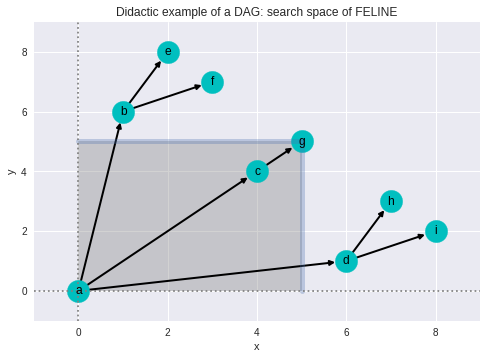

In [505]:
#@title Draw a didactic example of a DAG using weak dominance drawing
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

ax=plt.gca()
ax.add_patch(Rectangle(de.pos['a'],
                       de.pos['g'][0] - de.pos['a'][0],
                       de.pos['g'][1] - de.pos['a'][1],
                       facecolor="grey",alpha=0.35))
ax.add_line(Line2D([de.pos['g'][0],de.pos['g'][0]],
                   [de.pos['g'][1],de.pos['a'][1]],
                   lw=5., alpha=0.3))
ax.add_line(Line2D([de.pos['g'][0],de.pos['a'][0]],
                   [de.pos['g'][1],de.pos['g'][1]],
                   lw=5., alpha=0.3))

  
plt.axvline(x=de.pos['a'][1],color='0.5', ls=':')
plt.axhline(y=de.pos['a'][0],color='0.5', ls=':')

plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Didactic example of a DAG: search space of FELINE')
plt.xlim(xmin=-1,xmax=9)
plt.ylim(ymin=-1,ymax=9)

nx.draw_networkx(de,pos=de.pos,
                 node_size=500,width=2.0,node_color='c')

Pruning behavior of FELINE (see Figure 7).

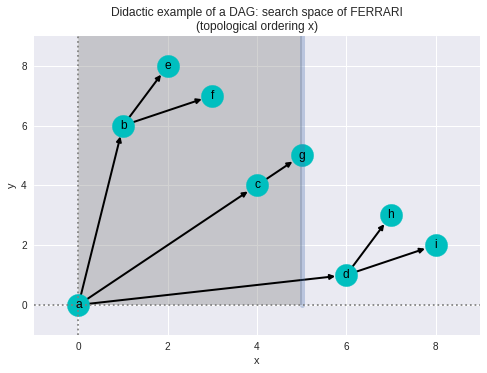

In [506]:
ax=plt.gca()
ax.add_patch(Rectangle(de.pos['a'],
                       de.pos['g'][0] - de.pos['a'][0],
                       9 - de.pos['a'][1],
                       facecolor="grey",alpha=0.35))
ax.add_line(Line2D([de.pos['g'][0],de.pos['g'][0]],
                   [0,9],
                   lw=5., alpha=0.3))
#ax.add_line(Line2D([de.pos['g'][0],de.pos['a'][0]],
#                   [de.pos['g'][1],de.pos['g'][1]],
#                   lw=5., alpha=0.3))

  
plt.axvline(x=de.pos['a'][1],color='0.5', ls=':')
plt.axhline(y=de.pos['a'][0],color='0.5', ls=':')

plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Didactic example of a DAG: search space of FERRARI\n(topological ordering x)')
plt.xlim(xmin=-1,xmax=9)
plt.ylim(ymin=-1,ymax=9)

nx.draw_networkx(de,pos=de.pos,
                 node_size=500,width=2.0,node_color='c')

### Optimizations: Level Filter (negative-cut)

The **level** of a vertex $v$ (denoted as $l_v$) can be defined as its depth: if $v$ has no immediate predecessors, then $l_v = 0$, otherwise it is maximum of levels of its immediate predecessors plus one: $l_v = \max\limits_{u\colon (v,u)\in E}(l_u)+1$

In [507]:
#@title Create an example for level-filter
lf=nx.DiGraph()
lf.add_nodes_from([chr(c) for c in range(ord('a'),ord('i')+1)])
lf.add_edges_from([('a','c'),('a','d'),('a','e'),
                   ('b','f'),
                   ('d','g'),
                   ('e','h'),
                   ('f','g'),('f','i')])
lf.lvl={
    'g':0,'h':0,'i':0,
    'c':1,'d':1,'e':1,'f':1,
    'a':2,'b':2
}
lf.fel={
    'a':(1,4),'b':(6,1),'c':(2,9),'d':(3,7),'e':(4,5),
    'f':(7,2),'g':(8,8),'h':(5,6),'i':(9,3),
}
lf

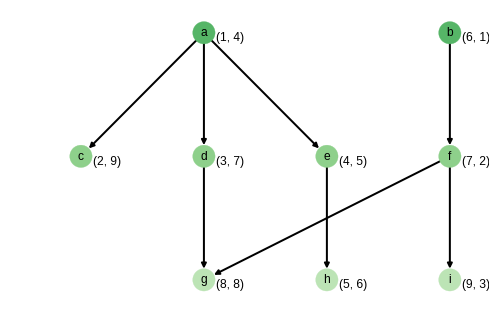

In [508]:
#@title Draw an example DAG for levels-filter, as in Figure 9 (levels-based)
plt.axis('off')
lf.tree={
  'a':(2,2),'b':(4,2),
  'c':(1,1),'d':(2,1),'e':(3,1),'f':(4,1),
  'g':(2,0),'h':(3,0),'i':(4,0)
}
plt.ylabel('level')
nx.draw_networkx(lf,
                 pos=lf.tree,
                 nodes=lf.lvl.keys(),
                 node_color=lf.lvl.values(),cmap=plt.cm.Greens,
                 vmin=-2,vmax=5,
                 node_size=500,width=2.0)
labels=nx.draw_networkx_labels(lf,
                               pos={k: (v[0]+0.21,v[1]-0.04) for (k,v) in lf.tree.items()},
                               labels=lf.fel)

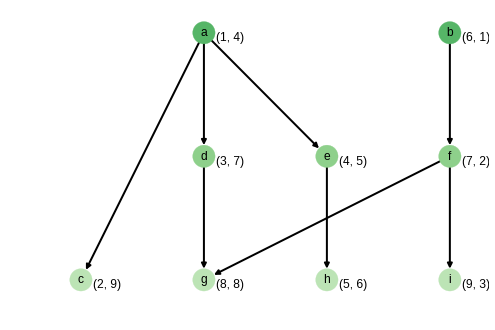

In [509]:
#@title Draw an example DAG for levels-filter, corrected (levels-based)
plt.axis('off')
lf.lvl['c']=0
lf.tree['c']=(1,0)
plt.ylabel('level')
nx.draw_networkx(lf,
                 pos=lf.tree,
                 nodes=lf.lvl.keys(),
                 node_color=lf.lvl.values(),cmap=plt.cm.Greens,
                 vmin=-2,vmax=5,
                 node_size=500,width=2.0)
labels=nx.draw_networkx_labels(lf,
                               pos={k: (v[0]+0.21,v[1]-0.04) 
                                    for (k,v) in lf.tree.items()},
                               labels=lf.fel)

Example where the vertex $h$ does not reach $g$, but there is false-implied path between them ($g$ is in domination area of $h$, because $(5,6) \preceq (8,8)$). However, $g$ and $h$ are in the same level, and the ***level filter*** prune the search.  The numbers represents the coordinates attributed by FELINE. The vertical height and the color represents level of vertex.

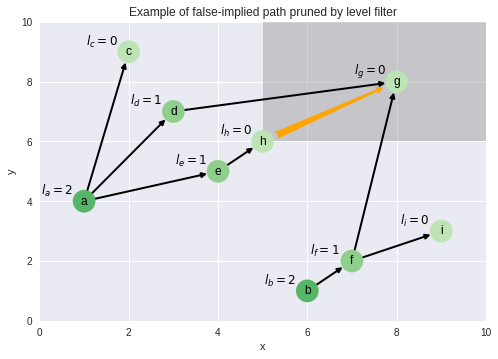

In [510]:
#@title Draw an example DAG for levels-filter, using weak dominance drawing
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib.lines import Line2D

ax=plt.gca()
ax.add_patch(Rectangle(lf.fel['h'],
                       #lf.fel['g'][0] - lf.fel['h'][0],
                       #lf.fel['g'][1] - lf.fel['h'][1],
                       10 - lf.fel['h'][0],
                       10 - lf.fel['h'][1],
                       facecolor="grey",alpha=0.35))

ax.add_patch(
    FancyArrowPatch(lf.fel['h'],lf.fel['g'],
                    shrinkA=15,shrinkB=15,
                    arrowstyle='fancy',mutation_scale=18,
                    linestyle='dashed',hatch='\\',color='orange')
)
  
#plt.axvline(x=lf.fel['h'][0],color='0.4', ls=':')
#plt.axhline(y=lf.fel['h'][1],color='0.4', ls=':')

plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Example of false-implied path pruned by level filter')
plt.xlim(xmin=0,xmax=10)
plt.ylim(ymin=0,ymax=10)

nx.draw_networkx(lf,pos=lf.fel,
                 node_size=500,width=2.0,
                 nodes=lf.lvl.keys(),
                 node_color=lf.lvl.values(),cmap=plt.cm.Greens,
                 vmin=-2,vmax=5)
labels=nx.draw_networkx_labels(lf,
                               pos={k: (v[0]-0.60,v[1]+0.35) for (k,v) in lf.fel.items()},
                               labels={k:'$l_'+str(k)+'='+str(l)+'$'
                                       for (k,l) in lf.lvl.items()})

Example where the vertex $h$ does not reach $g$, but there is false-implied path (orange) between them ($g$ is in domination area of $h$, shown as the gray area). However, $g$ and $h$ are in the same level: $l_g = l_h = 0$, and the ***level filter*** prune the search.  The labels and the color represents level of vertex.

In [0]:
# Could not get toolkit for 3D visualization does not work, unfortunately.
# https://networkx.github.io/documentation/latest/auto_examples/3d_drawing/mayavi2_spring.html
#!apt-get -qq install -y vtk python-vtk
#!pip install -q vtk
#!pip install -q PyVTK
#!pip install -q mayavi
#from mayavi import mlab

### Optimizations: _min-post_ interval (positive-cut filter)

This strategy utilizes a *spanning-tree* of a DAG (or rather a spanning-forest or [arborescence](https://en.wikipedia.org/wiki/Arborescence_%28graph_theory%29)), for example a depth-first search or breadth-first search tree.

The *min-post* strategy is used by GRAIL (Graph Reachability indexing via rAndomized Interval Labeling) online search approach.  *Min-post* strategy creates a unique interval $I_u = [s_u, e_u]$ for each vertex $u$, where $s_u$ and $e_u$ denote the start and the end of the interval.  The ending value $e_u$ is defined as $e_u = post(u)$, that is the post-order value of vertex $u$.  The starting value $s_u$ is defined as $e_u$ if $u$ is a leaf, and $s_u = \min\{s_x| x \in children(u)\}$ if $u$ is not a leaf.

In other words, interval labeling (*min-post* strategy) labels each node $u$ with a range $I_u = [s_u, e_u]$, where $e_u$ denotes the rank of the node $u$ in a post-order traversal of the tree, where the ranks are assumed to begin at 1, and all the children of a node are assumed to be ordered and fixed for that traversal. Further, $s_u$ denotes the lowest rank for any node $x$ in the subtree rooted at $u$ (i.e., including $u$).

For these paths restricted to tree edges, reachability can be guaranteed (only positive queries).  Thus, if $I_v \subseteq I_u$, we can conclude that $u$ reaches $v$. However, we can state nothing about non-tree edges. Interval takes linear time and space for constructing the index, and provides constant time querying.

See: *"[GRAIL: Scalable reachability index for large graphs](https://www.researchgate.net/profile/Mohammed_Zaki4/publication/220538786_GRAIL_Scalable_reachability_index_for_large_graphs/links/542970020cf238c6ea7f2eed/GRAIL-Scalable-reachability-index-for-large-graphs.pdf)"* (PDF)

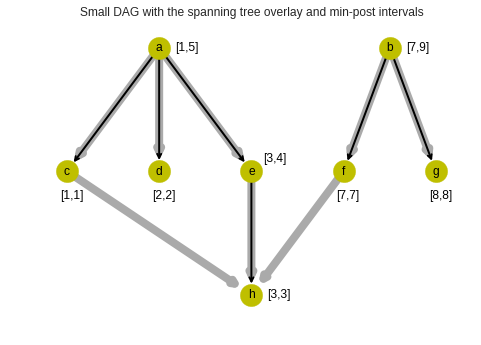

In [512]:
#@title Draw a small DAG and its spanning-tree, as in Figure 8
from copy import deepcopy

plt.axis('off')
plt.title('Small DAG with the spanning tree overlay and min-post intervals')
sd.tree={
  'a':(2,3),'b':(4.5,3),
  'c':(1,2),'d':(2,2),'e':(3,2),'f':(4,2),'g':(5,2),
  'h':(3,1)
}
nx.draw_networkx(sd,
                 pos=sd.tree,
                 node_size=500,width=8.0,
                 edge_color='#aaaaaa',node_color='y')
edges=nx.draw_networkx_edges(sd,
                             pos=sd.tree,
                             edgelist=[
                               ('a','c'),('a','d'),('a','e'),
                               ('e','h'),
                               ('b','f'),('b','g')
                             ],
                             node_size=500,width=2.0,
                             arrowstyle='->')

sd.lpos=deepcopy(sd.tree)
for v in list('abh'):
  sd.lpos[v] = (sd.lpos[v][0]+0.30,sd.lpos[v][1])
for v in list('cdfg'):
  sd.lpos[v] = (sd.lpos[v][0]+0.05,sd.lpos[v][1]-0.2)
for v in list('e'):
  sd.lpos[v] = (sd.lpos[v][0]+0.25,sd.lpos[v][1]+0.1)
sd.mpi={
    'a':(1,5),'b':(7,9),
    'c':(1,1),'d':(2,2),'e':(3,4),'f':(7,7),'g':(8,8),
    'h':(3,3),
}
sd.mpi_labels={
  v:('[%d,%d]'%(i[0],i[1]))
  for (v,i) in sd.mpi.items()
}

labels=nx.draw_networkx_labels(sd,
                               pos=sd.lpos,
                               labels=sd.mpi_labels)

Min-post indexing for a spanning tree extracted from the small DAG of Figure 2.  Each vertex is labeled with its *min-post* interval. Original edges of the DAG are marked in light gray.

For instance, consider the vertex $h$ of above figure.  We can conclude that the query $r(a,h)$ will return true, without search, because $[3,3] \subseteq  [1,5]$.  However, we can say nothing about the query $r(b,h)$, because there is no tree edge connecting the two vertices.

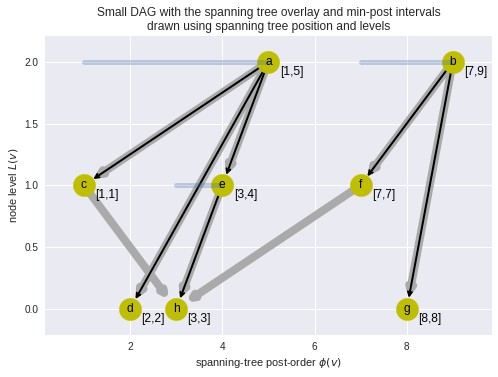

In [513]:
#plt.axis('off')
plt.title('Small DAG with the spanning tree overlay and min-post intervals\n'+
          'drawn using spanning tree position and levels')
sd.lvl = {
    'h': 0, 'g': 0, 'd': 0,
    'c': 1, 'e': 1, 'f': 1,
    'a': 2, 'b': 2,
}
sd.mpilvl={
  v: (sd.mpi[v][1],sd.lvl[v]) for v in sd
}
plt.xlabel('spanning-tree post-order $\phi(v)$')
plt.ylabel('node level $L(v)$')

ax=plt.gca()
for v in sd:
  if sd.mpi[v][0] == sd.mpi[v][1]:
    continue
  ax.add_line(Line2D([sd.mpi[v][0],sd.mpi[v][1]],
                     [sd.lvl[v],sd.lvl[v]],
                     lw=5., alpha=0.3))
  
nx.draw_networkx(sd,
                 pos=sd.mpilvl,
                 node_size=500,width=8.0,
                 edge_color='#aaaaaa',node_color='y')
edges=nx.draw_networkx_edges(sd,
                             pos=sd.mpilvl,
                             edgelist=[
                               ('a','c'),('a','d'),('a','e'),
                               ('e','h'),
                               ('b','f'),('b','g')
                             ],
                             node_size=500,width=2.0,
                             arrowstyle='->')

labels=nx.draw_networkx_labels(sd,
                               pos={u:(x+0.5,y-0.08) for (u,(x,y)) in sd.mpilvl.items()},
                               labels=sd.mpi_labels)

### Optimization: min-post / pre-max DFS interval (positive-cut and negative-cut)

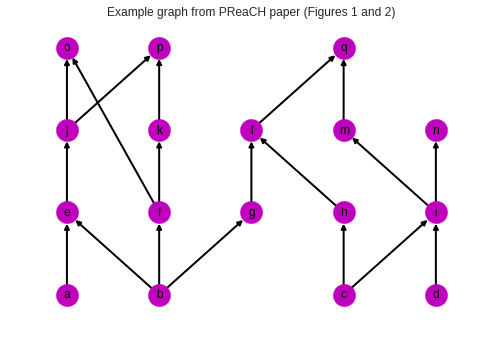

In [514]:
#@title Create an example from PReaCH { form-width: "30%" }
ch=nx.DiGraph()
ch.add_edges_from([('a','e'),
                   ('b','e'),('b','f'),('b','g'),
                   ('c','h'),('c','i'),
                   ('d','i'),
                  
                   ('e','j'),
                   ('f','o'),('f','k'),
                   ('g','l'),
                   ('h','l'),
                   ('i','m'),('i','n'),
                   
                   ('j','o'),('j','p'),
                   ('k','p'),
                   ('l','q'),
                   ('m','q'),
                  ])
ch.lvl={
    'o':0,'p':0,'q':0,'n':0,
    'j':1,'k':1,'l':1,'m':1,'i':1,
    'e':2,'f':2,'g':2,'h':2,'d':2,
    'a':3,'b':3,'c':3,
}
ch.pos={
    'a':(0,0),'b':(1,0),          'c':(3,0),'d':(4,0),
    'e':(0,1),'f':(1,1),'g':(2,1),'h':(3,1),'i':(4,1),
    'j':(0,2),'k':(1,2),'l':(2,2),'m':(3,2),'n':(4,2),
    'o':(0,3),'p':(1,3),          'q':(3,3),          
}

plt.axis("off")
plt.title('Example graph from PReaCH paper '+
          '(Figures 1 and 2)')
nx.draw_networkx(ch,pos=ch.pos,
                 node_size=500,width=2.0,node_color='m')
plt.show()

**Section 3.3 "*Pruning Based on DFS Numbering*" in the PReaCH paper.**

Let $\phi(v)$ denote the DFS number of node $v$ and $\hat{\phi}(v)$ the largest DFS number of a node
in the subtree of the DFS tree rooted at $v$. The properties of DFS ensure that the nodes in
$\text{range}(v) := \phi(v)..\hat{\phi}(v)$ are all reachable from $v$ (they form the subtree of the DFS tree which
is rooted at $v$) and that no nodes with DFS number exceeding $\hat{\phi}(v)$ is reachable from $v$.

Let $u \to v$ denote that $r(u,v)$ is true, and $u \nrightarrow v$ that $r(u,v)$ is false.


*   $\forall v,t \in V \colon\ t \in \text{range}(v) \implies v \to t$  
    (positive-cut)
*   $\forall v,t \in V \colon\ \phi(t) > \hat{\phi}(v) \implies v \nrightarrow t$  
    (negative-cut)

Let's define node $w = p_{\text{tree}}(v)$ as the node that has $v \to w$ and $w \notin \text{range}(v)$
which maximizes $\lvert\text{range}(w)\rvert$.  Then, if $p_{\text{tree}}(v)$ exists

*   $\forall v,t \in V \colon\ p_{\text{tree}}(v) \neq \bot \land t \in \text{range}(p_{\text{tree}}(v)) \implies v \to t$  
    (positive-cut)
    
For any $v \in V$, let $\phi_{\text{min}}(v)$ denote the smallest DFS number of a node reachable from $v$ (including $v$). Then

*   $\forall v,t \in V \colon\ \phi(t) < \phi_{\text{min}}(v) \implies v \nrightarrow t$  
    (negative-cut)
    
We can also define $\phi_{\text{gap}}(v)$ in such way that

*   $\forall v,t \in V \colon\ \phi_{\text{gap}}(v) < \phi(t) < \phi(v) \implies v \nrightarrow t$  
    (negative-cut)
    
All those values: $\phi(v), \hat{\phi}(v), p_{\text{tree}}(v), \phi_{\text{min}}(v), \phi_{\text{gap}}(v)$ can be done while computing the DFS numbering.

**On choosing the DFS spanning-tree from PReaCH paper**

There are many ways to define a DFS ordering: We are free to choose the order in
which we scan the nodes for starting recursive exploration and we can choose the order in
which we inspect edges leaving a node being explored.

One heuristics that seems to be useful: Make sure that most nodes are in a small number of trees because this leads to large positive intervals. It therefore makes sense to only uses sources of the graph as tree roots.

In addition, one can order the sources by the number of nodes reached from them during the search for topological levels.

### Optimization: Reachability Contraction Hierarchies (from PReaCH)

In general, a _Reachability Contraction Hierarchy_ (RCH) can be defined based on any numbering
order : $V \mapsto 1..n$. We successively contract nodes with increasing $\text{order}(v)$. Contracting
node $v$ means removing it from the graph and possibly inserting new edges such that the
reachability relation in the new graph is the same as in the previous graph, i.e., if the graph
contains a path $\langle u, v, w \rangle$ and after removing $v$, $u$ would no longer be reachable from $v$, we
have to insert a new *shortcut edge* $(u,w)$. The query algorithm 
(a variant of the bidirectional BFS) does not use the contracted
versions of the graph but only the ordering and the shortcuts.

One can exploit the fact that any DAG contains source nodes (with in-degree zero) and
sink nodes (with out-degree zero). Contracting such a node $v$ never requires the insertion of
shortcuts because shortcuts always bridge paths of the form $\langle u, v, w \rangle$ but such paths cannot
exist because $v$ either lacks incoming or outcoming edges. Hence from now on we restrict the
considered orderings such that they only contract source or sink nodes. This implies a huge
simplification and acceleration of preprocessing compared to general RCHs.

In [0]:
ch.labels = {
    'a':  1, 'b': 11, 'c':  7, 'd':  2,
    'e': 14, 'f': 13, 'g': 12, 'h':  9, 'i': 17,
    'j': 15, 'k':  8, 'l': 16, 'm': 10, 'n':  3,
    'o':  4, 'p':  5, 'q':  6,
}

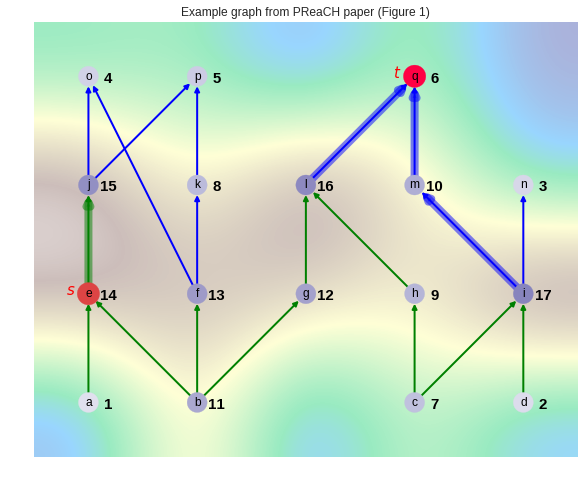

In [516]:
#@title Figure 1 from PReaCH paper, with contraction hierarchy { form-width: "30%" }
interpolation = "bicubic" #@param ["none", "nearest", "bilinear", "bicubic", "spline16", "spline36", "hanning", "hamming", "hermite", "kaiser", "quadric", "catrom", "gaussian", "bessel", "mitchell", "sinc", "lanczos"]
#fig = plt.gcf()
fig = plt.figure()
fig.set_size_inches(10, 8)
plt.axis("off")
plt.title('Example graph from PReaCH paper '+
          '(Figure 1)')
oxy=np.full((4,5),np.nan)
for n in ch.labels:
  oxy[ch.pos[n][1],ch.pos[n][0]] = ch.labels[n]
oxy[np.isnan(oxy)] = 0
plt.imshow(oxy,
           origin='lower',
           # https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.imshow.html
           # https://matplotlib.org/gallery/images_contours_and_fields/interpolation_methods.html
           interpolation=interpolation,
           #cmap=plt.cm.Purples,
           cmap=plt.cm.terrain,
           #vmin=-8,vmax=len(ch)*2,
           alpha=0.4)
nx.draw_networkx(ch,pos=ch.pos,
                 edges=ch.edges(),
                 edge_color=['g' if ch.labels[u] < ch.labels[v] else 'b'
                             for (u,v) in ch.edges()],
                 node_size=400,width=2.0,
                 #node_color='#C8A2C8'
                 node_color=[ch.labels[n] for n in ch.nodes()],
                 cmap=plt.cm.Purples,
                 vmin=-8,vmax=len(ch)*2)
nx.draw_networkx_nodes(ch,pos=ch.pos,
                       nodelist=['e','q'],
                       node_color=['#dd4444','#ff0044'],
                       node_size=500,width=2.0)
nx.draw_networkx_edges(ch,pos=ch.pos,
                       edgelist=[('e','j'),('l','q'),('m','q'),('i','m')],
                       edge_color=['g','b','b','b'],
                       width=8.0,alpha=0.5)
nx.draw_networkx_labels(ch,
                        pos={u:(x+0.18,y-0.02) for (u,(x,y)) in ch.pos.items()},
                        labels=ch.labels,
                        font_size=15,font_weight='bold')
nx.draw_networkx_labels(ch,
                        pos={u:(x-0.16,y+0.03) for (u,(x,y)) in ch.pos.items()},
                        labels={'e': '$s$', 'q': '$t$'},
                        font_size=15,font_color='r')
plt.show()

**Figure 1** in PReaCH paper:

Example RCH. Edges in the forward search space are \[light\] green and those in the
backward search space are \[dark\] blue. The search spaces for a query from $s$ to $t$ are ~~circled~~ bolded.
Node labels specify the node ordering.

Forward search can only consider edges in ascending order of contraction hierarchy; backward search can only consider reverse edges in ascending order (edges in descending order).

## Algorithms

This section includes Python implementations of algorithms for calculating:

* node level (also known as generation number)
* spanning forest (arborescence)
* min-post intervals for spanning tree / spanning forest
* topological sort
* FELINE index

### Starter / preliminary algorithms

Those are needed to begin work on other algorithms, or draw graphs

In [517]:
#@title def order_to_pos { form-width: "30%" }
# define helper function for calculating FELINE index with Algorithm 1
def order_to_pos(list,start=0):
  """Turn sorted list into dict values are position on list
  
  Given sorted list of values [x_0, x_1, x_2,...,x_n] return a dictionary,
  where keys are elements the list and values are their original positions
  in the sort order given by the list: {x_0: 0, x_1: 1,..., x_n: n}.
  
  Parameters:
  -----------
  list
      Sorted list of [hashable] elements, e.g. nodes in a graph.
      
  start : number
      Staring number (ffor first position on list).
      
  Returns:
  --------
  dict
      Dictionary where keys are elements and values their positions on list.
  """
  return {
    elem: pos
    for (pos,elem) in enumerate(list,start=start)
  }

# test order_to_pos() helper function
order_to_pos(list('abcdefgh'))

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7}

In [518]:
order_to_pos(list('12345'),start=1)

{'1': 1, '2': 2, '3': 3, '4': 4, '5': 5}

#### Tips / heads

Find all nodes with no in-nodes (tips / heads in version control terminology).

Note that "tips" or "heads" in commit graph (in version control) are "roots" or "sources" of the graph;  
and that "roots" in commit graph (parentless commits) are "leaves" or "sinks" of the graph.

In [0]:
#@title def find_heads(G)
def find_heads(G):
  """Find all nodes with no in-nodes in DAG graph G"""
  return [n for n in G if G.in_degree(n) == 0]

def find_roots(G):
  """Find all nodes with no out-nodes in DAG graph G"""
  return [n for n in G if G.out_degree(n) == 0]

Test that it works on known graphs from previous part

In [520]:
#@title Test find_heads on a crown DAG known as $S_3^0$ graph
find_heads(DG)

[1, 3, 'u']

In [521]:
find_roots(DG)

[2, 4, 'v']

In [522]:
#@title Test find_heads on a small DAG
find_heads(sd)

['a', 'b']

In [523]:
#@title Test find_heads on a didactic example of a DAG
find_heads(de)

['a']

In [524]:
#@title Test find_heads on example from PReaCH paper
find_heads(ch)

['a', 'c', 'b', 'd']

In [525]:
find_roots(ch)

['o', 'n', 'q', 'p']

#### Spanning tree / spanning forest

These are directed spanning trees (a forest) for a directed acyclic graph

In [0]:
#@title flatten lambda { form-width: "30%" }
# https://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
flatten = lambda l: [item for sublist in l for item in sublist]

In [527]:
#@title def find_dfs_spanning(G) { form-width: "30%" }
def find_dfs_spanning_overlap(G):
  # this does not find disjoint trees (a forest)
  return flatten(nx.dfs_edges(G, source=n) 
                 for n in find_heads(G))

def find_dfs_spanning(G):
  """Find edges of the DFS spanning tree for graph G
  
  Parameters
  ----------
  G : NetworkX graph
      Graph to find spanning-tree in.
  
  Returns
  -------
  edges : list
      A list of edges in the depth-first-search.

  Examples
  --------
  >>> G = nx.path_graph(5)
  >>> find_dfs_spanning(G)
  [(0, 1), (1, 2), (2, 3), (3, 4)]
  
  Notes
  -----
  The source is chosen arbitrarily and repeatedly until all
  components in the graph are searched.
  """
  # this may not cover all nodes
  return list(nx.dfs_edges(G))


find_dfs_spanning(nx.path_graph(5))

[(0, 1), (1, 2), (2, 3), (3, 4)]

In [528]:
find_dfs_spanning(sd)

[('a', 'c'), ('c', 'h'), ('a', 'e'), ('a', 'd'), ('b', 'g'), ('b', 'f')]

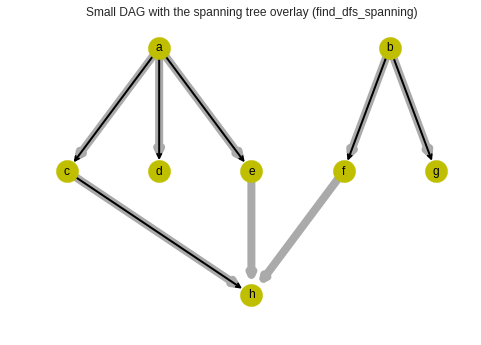

In [529]:
#@title Draw a small DAG and its find_dfs_spanning
plt.axis('off')
plt.title('Small DAG with the spanning tree overlay '+
          '(find_dfs_spanning)')
nx.draw_networkx(sd,
                 pos=sd.tree,
                 node_size=500,width=8.0,
                 edge_color='#aaaaaa',node_color='y')
edges=nx.draw_networkx_edges(sd,
                             pos=sd.tree,
                             edgelist=find_dfs_spanning(sd),
                             node_size=500,width=2.0,
                             arrowstyle='->')

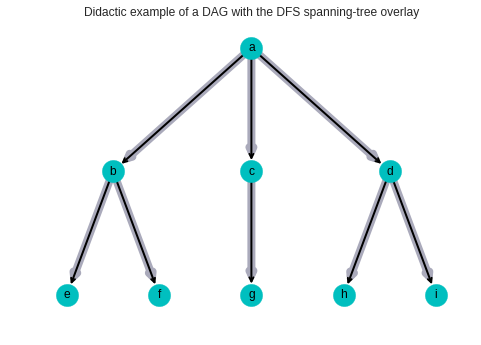

In [530]:
#@title Draw a didactic example of a DAG and its find_dfs_spanning
plt.axis('off')
plt.title('Didactic example of a DAG '+
          'with the DFS spanning-tree overlay')
nx.draw_networkx(de,
                 pos=de.tree,
                 width=8.0,edge_color='#aaaabb',
                 node_size=500,node_color='c')
edges=nx.draw_networkx_edges(de,
                             pos=de.tree,
                             edgelist=find_dfs_spanning(de),
                             node_size=500,width=2.0,
                             arrowstyle='->')

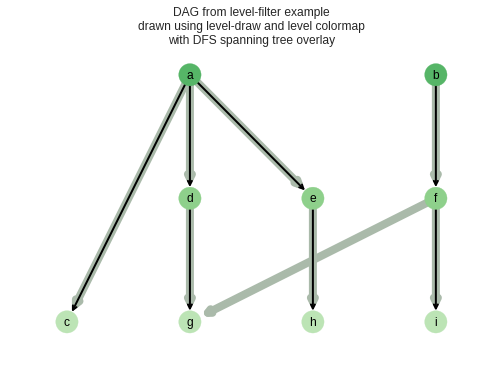

In [531]:
#@title Draw DAG from level-filter example and its find_dfs_spanning
plt.axis('off')
plt.title('DAG from level-filter example\n'+
          'drawn using level-draw and level colormap\n'+
          'with DFS spanning tree overlay')
nx.draw_networkx(lf,
                 pos=lf.tree,
                 nodes=lf.lvl.keys(),
                 node_size=500,node_color=lf.lvl.values(),
                 cmap=plt.cm.Greens,vmin=-2,vmax=5,
                 width=8.0,edge_color='#aabaaa')
edges=nx.draw_networkx_edges(lf,
                             pos=lf.tree,
                             edgelist=find_dfs_spanning(lf),
                             node_size=500,width=2.0,
                             arrowstyle='->')

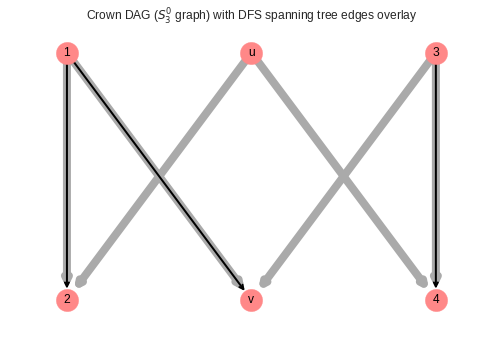

In [532]:
#@title Draw a crown DAG and its find_dfs_spanning
plt.axis('off')
DG.tree={
  1: (1,2),'u':(2,2),3:(3,2),
  2: (1,1),'v':(2,1),4:(3,1),
}
plt.title('Crown DAG ($S_3^0$ graph) '+
          'with DFS spanning tree edges overlay')
nx.draw_networkx(DG,
                 pos=DG.tree,
                 width=8.0,edge_color='#aaaaaa',
                 node_size=500,node_color='#ff8888')
edges=nx.draw_networkx_edges(DG,
                             pos=DG.tree,
                             edgelist=find_dfs_spanning(DG),
                             node_size=500,width=2.0,
                             arrowstyle='->')

#### Reach of the node

This can be calculated in a way similar to how levels are calculated (below). The amount of nodes given node can reach can be used as heuristic to select \[DFS\] spanning-tree.

In [533]:
#@title def find_reachable { form-width: "30%" }
def find_reachable(DG, attr=None):
  """Find reachable vertices for all vertices in graph G
  
  The reachability list information can be optionally saved in the graph,
  under given node attribute (name given by `attr` parameter).
  
  Parameters:
  -----------
  DG : NetworkX DiGraph
      Directed acyclic graph.
      
  attr : str, optional (default=None)
      If set, name of a node attribute under which store reachable list.
      
  Returns:
  --------
  dict of lists
      Dictionary, where keys are node indices, and values are lists
      of all nodes reachable from given node.
  """
  reachable = {}
  
  # defined only for Directed Acyclic Graphs
  if not DG.is_directed():
    raise nx.NetworkXNotImplemented(
      "Vertex reach is not implemented for undirected graphs.")
  if not nx.is_directed_acyclic_graph(DG):
    raise nx.NetworkXNotImplemented(
      "Vertex reach is not defined on directed graphs with loops")
  
  # it can be any post-order ordering
  nodelist = nx.dfs_postorder_nodes(DG)
  for node in nodelist:
    reachable[node] = []
    
    for neigh in DG.successors(node):
      reachable[node].extend(reachable[neigh])
      reachable[node].append(neigh)
  
  if attr is not None:
    for node, r in reach.items():
      DG.nodes[node][attr] = reachable
  
  return reachable


find_reachable(DG)

{1: [2, 'v'], 2: [], 3: [4, 'v'], 4: [], 'u': [2, 4], 'v': []}

In [534]:
#@title def find_reach { form-width: "30%" }
def find_reach(DG, attr=None):
  """Find reach (number of reachable vertices) of all vertices in graph G
  
  The reach of a vertex v, which we denote as r_v, can be defined
  as number of vertices reachable from v.
  
  The reach information can be optionally saved in the graph,
  under given node attribute (name given by `attr` parameter).
  
  NOTE: whether for nodes without outcoming edges (without any neighbours)
  r_v is defined to be 0, or defined to be 1, is a matter of convention.
  Here we exclude v from the set of nodes reachable from v.
  
  Parameters:
  -----------
  DG : NetworkX DiGraph
      Directed acyclic graph.
      
  attr : str, optional (default=None)
      If set, name of a node attribute under which store vertex level.
      
  Returns:
  --------
  dict of ints
      Dictionary, where keys are node indices, and values are node reach
  """
  reachable = find_reachable(DG)
  
  reach = {n: len(set(rl)) for (n,rl) in reachable.items()}
  
  if attr is not None:
    for node, r in reach.items():
      DG.nodes[node][attr] = reach
  
  return reach


find_reach(DG)

{1: 2, 2: 0, 3: 2, 4: 0, 'u': 2, 'v': 0}

In [535]:
print('reach:     %r' % find_reach(lf))
print('reachable: %r' % find_reachable(lf))

reach:     {'a': 5, 'c': 0, 'b': 3, 'e': 1, 'd': 1, 'g': 0, 'f': 2, 'i': 0, 'h': 0}
reachable: {'a': ['c', 'h', 'e', 'g', 'd'], 'c': [], 'b': ['i', 'g', 'f'], 'e': ['h'], 'd': ['g'], 'g': [], 'f': ['i', 'g'], 'i': [], 'h': []}


In [536]:
print('reach:     %r' % find_reach(sd))
print('reachable: %r' % find_reachable(sd))

reach:     {'a': 4, 'c': 1, 'b': 3, 'e': 1, 'd': 0, 'g': 0, 'f': 1, 'h': 0}
reachable: {'a': ['h', 'c', 'h', 'e', 'd'], 'c': ['h'], 'b': ['g', 'h', 'f'], 'e': ['h'], 'd': [], 'g': [], 'f': ['h'], 'h': []}


### Optimizations algorithms

Those are the algorithms used to speed-up the reachability queries *in addition to* FELINE index (Algorithm 3: Reachable).

#### Levels

> The **level** of a vertex $v$ (denoted as $l_v$) can be defined as its depth: if $v$ has no immediate predecessors, then $l_v = 0$, otherwise it is maximum of levels of its immediate predecessors plus one: $$l_v = \max\limits_{u\colon (v,u)\in E}(l_u)+1$$

In [0]:
#@title def find_levels { form-width: "30%" }
def find_levels(DG, attr=None):
  """Find levels (generation number) of all vertices in graph G
  
  The level of a vertex v, which we denote as l_v, can be defined as its
  depth, or the length of shortest path to the leaf node.
  
   - if v has no immediate predecessors, then l_v = 0
   - otherwise l_v = 1 + max_{u: predecessors}(l_u)
  
  The levels / generation number information can be optionally saved in
  the graph, under given node attribute (name given by `attr` parameter).
  
  NOTE: whether for nodes without outcoming edges (without any neighbours)
  l_v is defined to be 0, or defined to be 1, is a matter of convention.
  Here the same convention as in FELINE paper is used.
  
  Parameters:
  -----------
  DG : NetworkX DiGraph
      Directed acyclic graph.
      
  attr : str, optional (default=None)
      If set, name of a node attribute under which store vertex level.
      
  Returns:
  --------
  dict of ints
      Dictionary, where keys are node indices, and values are node levels
  """
  lvl = {}
  
  # defined only for Directed Acyclic Graphs
  if not DG.is_directed():
    raise nx.NetworkXNotImplemented(
      "Vertex level is not defined on undirected graphs.")
  if not nx.is_directed_acyclic_graph(DG):
    raise nx.NetworkXNotImplemented(
      "Vertex level is not defined on directed graphs with loops")
  
  # it can be any post-order ordering
  nodelist = nx.dfs_postorder_nodes(DG)
  for node in nodelist:
    if DG.out_degree(node) == 0:
      lvl[node] = 0
      continue
    
    lvl[node] = max([lvl[neigh] 
                     for neigh in DG.successors(node)]) + 1
  
  if attr is not None:
    for node, level in lvl.items():
      DG.nodes[node][attr] = level
  
  return lvl

Test that it works on known graphs from previous part

In [538]:
#@title find_levels tests { form-width: "30%" }
print('crown DAG: %r' % find_levels(DG))
print('small DAG: %r' % find_levels(sd))
print('level DAG:\n  %r\n  %r (pre-defined, corrected)' %
      (find_levels(lf), lf.lvl))
print('didactic:  %r' % find_levels(de))

crown DAG: {1: 1, 2: 0, 3: 1, 4: 0, 'u': 1, 'v': 0}
small DAG: {'a': 2, 'c': 1, 'b': 2, 'e': 1, 'd': 0, 'g': 0, 'f': 1, 'h': 0}
level DAG:
  {'a': 2, 'c': 0, 'b': 2, 'e': 1, 'd': 1, 'g': 0, 'f': 1, 'i': 0, 'h': 0}
  {'a': 2, 'c': 0, 'b': 2, 'e': 1, 'd': 1, 'g': 0, 'f': 1, 'i': 0, 'h': 0} (pre-defined, corrected)
didactic:  {'a': 2, 'c': 1, 'b': 1, 'e': 0, 'd': 1, 'g': 0, 'f': 0, 'i': 0, 'h': 0}


In [539]:
# do all graphs have positions for level-based drawing?
[(graph,graph.tree) for graph in [DG,sd,de,lf]]

[(<networkx.classes.digraph.DiGraph at 0x7fb0e0b57410>,
  {1: (1, 2), 2: (1, 1), 3: (3, 2), 4: (3, 1), 'u': (2, 2), 'v': (2, 1)}),
 (<networkx.classes.digraph.DiGraph at 0x7fb0e2022dd0>,
  {'a': (2, 3),
   'b': (4.5, 3),
   'c': (1, 2),
   'd': (2, 2),
   'e': (3, 2),
   'f': (4, 2),
   'g': (5, 2),
   'h': (3, 1)}),
 (<networkx.classes.digraph.DiGraph at 0x7fb0e20c3810>,
  {'a': (3, 3),
   'b': (1.5, 2),
   'c': (3, 2),
   'd': (4.5, 2),
   'e': (1, 1),
   'f': (2, 1),
   'g': (3, 1),
   'h': (4, 1),
   'i': (5, 1)}),
 (<networkx.classes.digraph.DiGraph at 0x7fb0de775690>,
  {'a': (2, 2),
   'b': (4, 2),
   'c': (1, 0),
   'd': (2, 1),
   'e': (3, 1),
   'f': (4, 1),
   'g': (2, 0),
   'h': (3, 0),
   'i': (4, 0)})]

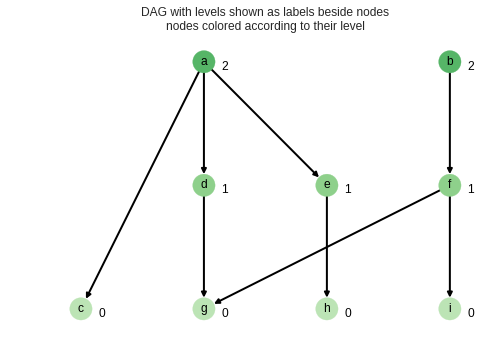

In [540]:
#@title Draw a DAG with levels shown (levels-based)  { run: "auto" }
graphs = {
  'crown DAG': DG,
  'small DAG': sd,
  'didactic': de,
  'levels DAG': lf,
}
palettes = {
  'Greens': plt.cm.Greens,
  'Reds': plt.cm.Reds,
  'Blues': plt.cm.Blues,
  'cool': plt.cm.cool,
  'hot': plt.cm.hot,
  'Wistia': plt.cm.Wistia,
  'viridis': plt.cm.viridis,
  'jet': plt.cm.jet,
}

graph_name = 'levels DAG' #@param ["crown DAG", "small DAG", "didactic", "levels DAG"]
cmap_name = 'Greens' #@param ["Reds","Greens","Blues","hot","cool","Wistia","viridis","jet"]
vmin = -2 #@param {type:"integer"}
vmax =  5 #@param {type:"integer"}

graph = graphs[graph_name]
cmap  = palettes[cmap_name]
lvls=find_levels(graph)

plt.axis('off')
plt.ylabel('level')
plt.title('DAG with levels shown as labels beside nodes\n'+
          'nodes colored according to their level')

nx.draw_networkx(graph,
                 pos=graph.tree,
                 nodes=lvls.keys(),
                 node_color=lvls.values(),cmap=cmap,
                 vmin=vmin,vmax=vmax,
                 node_size=500,width=2.0)
labels=nx.draw_networkx_labels(graph,
                               pos={k: (v[0]+0.17,v[1]-0.04) 
                                    for (k,v) in graph.tree.items()},
                               labels=lvls)

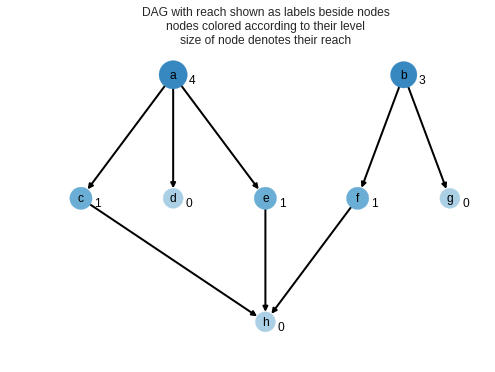

In [541]:
#@title Draw a DAG with reach shown (levels-based)  { run: "auto" }
graphs = {
  'crown DAG': DG,
  'small DAG': sd,
  'didactic': de,
  'levels DAG': lf,
}
palettes = {
  'Greens': plt.cm.Greens,
  'Reds': plt.cm.Reds,
  'Blues': plt.cm.Blues,
  'cool': plt.cm.cool,
  'hot': plt.cm.hot,
  'Wistia': plt.cm.Wistia,
  'viridis': plt.cm.viridis,
  'jet': plt.cm.jet,
}

graph_name = 'small DAG' #@param ["crown DAG", "small DAG", "didactic", "levels DAG"]
cmap_name = 'Blues' #@param ["Reds","Greens","Blues","hot","cool","Wistia","viridis","jet"]
vmin = -2 #@param {type:"integer"}
vmax =  4 #@param {type:"integer"}
scale= 100 #@param {type:"integer"}
start_size = 400 #@param {type:"integer"}

graph = graphs[graph_name]
cmap  = palettes[cmap_name]
lvls=find_levels(graph)
reach=find_reach(graph)

plt.axis('off')
plt.ylabel('level')
plt.title('DAG with reach shown as labels beside nodes\n'+
          'nodes colored according to their level\n'+
          'size of node denotes their reach')

nx.draw_networkx(graph,
                 pos=graph.tree,
                 nodes=lvls.keys(),
                 node_size=[start_size+scale*reach[v]
                            for v in lvls.keys()],
                 node_color=lvls.values(),cmap=cmap,
                 vmin=vmin,vmax=vmax,
                 width=2.0)
labels=nx.draw_networkx_labels(graph,
                               pos={k: (v[0]+0.17+0.01*reach[k],
                                        v[1]-0.04) 
                                    for (k,v) in graph.tree.items()},
                               labels=reach)
#[(v,reach[v],scale*reach[v])
# for v in lvls.keys()]

#### *Min-post* intervals

> Interval labeling (*min-post* strategy) labels each node $u$ with a range $I_u = [s_u, e_u]$, where $e_u$ denotes the rank of the node $u$ in ***some*** post-order traversal of the tree, where the ranks are assumed to begin at 1, and all the children of a node are assumed to be ordered and fixed for that traversal. Further, $s_u$ denotes the lowest rank for any node $x$ in the subtree rooted at $u$ (i.e., including $u$).

For more see node *"[Optimizations: _min-post_ interval (positive-cut filter)](#scrollTo=_rP8JdufWvCd&line=5&uniqifier=1)"* section

In [542]:
#@title def find_dfs_intervals { form-width: "30%" }
def find_dfs_intervals(DG, attr=None):
  """Find min-post labeling of all vertices in graph G, using DFS spanning-tree
  
  Min-post interval labeling strategy labels each node 'u' in the directed
  spanning tree (DFS tree here) of the acyclic graph `DG` with a range
  I_u = [s_u, e_u], where e_u denotes the rank of the node 'u' in post-order
  traversal of the tree (ranks assumed to begin at 1), and s_u denotes the
  lowest rank of any node 'w' in the subtree rooted at 'u' (including 'u').
  
  Parameters:
  -----------
  DG : NetworkX DiGraph
      Directed acyclic graph.
      
  attr : str, optional (default=None)
      If set, name of a node attribute under which store min-post intervals.
      
  Returns:
  --------
  dict of two-element lists of ints
      Dictionary, where keys are node indices, and values are two element
      lists storing min-post interval (of integers)
  """
  ivl = {}
  # create graph of spanning tree (DFS spanning tree) of DG
  span=nx.DiGraph()
  span.add_nodes_from(DG)
  span.add_edges_from(find_dfs_spanning(DG))
  # DEBUG
  #print('span=%r' % find_dfs_spanning(DG))
  
  # any post-order ordering would be good
  nodelist = nx.dfs_postorder_nodes(DG)
  for pos, node in enumerate(nodelist, start=1):
    ivl[node] = [pos, pos]
    if span.out_degree(node) > 0:
      ivl[node][0] = min(pos,
                         *[ivl[neigh][0] 
                           for neigh in span.successors(node)])
    # DEBUG
    #print('node=%s [%d,%d] -> %r' %
    #      (node, ivl[node][0],ivl[node][1],list(span.successors(node))))
  
  if attr is not None:
    for node, interval in ivl.items():
      DG.nodes[node][attr] = deepcopy(interval)
  
  return ivl


# DEBUG
find_dfs_intervals(sd)

{'a': [1, 5],
 'b': [6, 8],
 'c': [1, 2],
 'd': [4, 4],
 'e': [3, 3],
 'f': [7, 7],
 'g': [6, 6],
 'h': [1, 1]}

In [543]:
#@title find_dfs_intervals tests { form-width: "30%" }
# note that min-post intervals depend on spanning-tree chosen
# and may not be the same as precomputed ones from FELINE paper
print('crown DAG: %r' % find_dfs_intervals(DG))
print('small DAG: %r' % find_dfs_intervals(sd))
print('level DAG: %r' % find_dfs_intervals(lf))
print('didactic:  %r' % find_dfs_intervals(de))
print('-------------')
print('small DAG: %r' % (sd.mpi_labels))

crown DAG: {1: [1, 3], 2: [1, 1], 3: [4, 5], 4: [4, 4], 'u': [6, 6], 'v': [2, 2]}
small DAG: {'a': [1, 5], 'c': [1, 2], 'b': [6, 8], 'e': [3, 3], 'd': [4, 4], 'g': [6, 6], 'f': [7, 7], 'h': [1, 1]}
level DAG: {'a': [1, 6], 'c': [1, 1], 'b': [7, 9], 'e': [2, 3], 'd': [4, 5], 'g': [4, 4], 'f': [7, 8], 'i': [7, 7], 'h': [2, 2]}
didactic:  {'a': [1, 9], 'c': [1, 2], 'b': [3, 5], 'e': [3, 3], 'd': [6, 8], 'g': [1, 1], 'f': [4, 4], 'i': [6, 6], 'h': [7, 7]}
-------------
small DAG: {'a': '[1,5]', 'c': '[1,1]', 'b': '[7,9]', 'e': '[3,4]', 'd': '[2,2]', 'g': '[8,8]', 'f': '[7,7]', 'h': '[3,3]'}


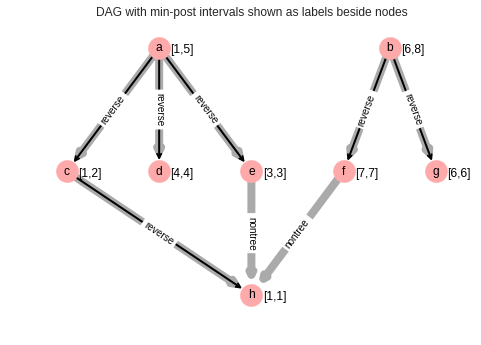

In [544]:
#@title Draw a DAG with min-post intervals (levels-based)  { run: "auto" }
graphs = {
  'crown DAG': DG,
  'small DAG': sd,
  'didactic': de,
  'levels DAG': lf,
}

graph_name = 'small DAG' #@param ["crown DAG", "small DAG", "didactic", "levels DAG"]
node_color = "#ffaaaa" #@param ["y", "c", "b", "g", "r"] {allow-input: true}
draw_edge_labels = True #@param {type:"boolean"}


graph=graphs[graph_name]
intervals=find_dfs_intervals(graph)
intervals_repr={
  v:('[%d,%d]'%(i[0],i[1]))
  for (v,i) in intervals.items()
}
edge_labels={
  (u,v):l 
  for (u,v,l) in nx.dfs_labeled_edges(graph)
  if u != v
}
max_pos=(
  max([pos[0] for (node,pos) in graph.tree.items()]),
  max([pos[1] for (node,pos) in graph.tree.items()])
)
dd=(
   0.25*(max_pos[0]/5.0),
  -0.02*(max_pos[1]/4.0)
)

plt.axis('off')
plt.title('DAG with min-post intervals shown as labels beside nodes')

nx.draw_networkx(graph,
                 pos=graph.tree,
                 width=8.0,edge_color='#aaaaaa',
                 node_size=500,node_color=node_color)
edges=nx.draw_networkx_edges(graph,
                             pos=graph.tree,
                             edgelist=find_dfs_spanning(graph),
                             node_size=500,width=2.0,
                             arrowstyle='->')
if draw_edge_labels:
  nx.draw_networkx_edge_labels(graph,
                               pos=graph.tree,
                               edge_labels=edge_labels,
                               font_size=10)
labels=nx.draw_networkx_labels(graph,
                               pos={k: (v[0]+dd[0],v[1]+dd[1]) 
                                    for (k,v) in graph.tree.items()},
                               labels=intervals_repr)
#print(edge_labels)

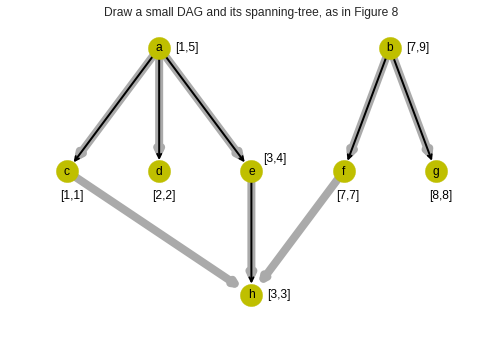

In [545]:
nx.draw_networkx(sd,
                 pos=sd.tree,
                 node_size=500,width=8.0,
                 edge_color='#aaaaaa',node_color='y')
edges=nx.draw_networkx_edges(sd,
                             pos=sd.tree,
                             edgelist=[
                               ('a','c'),('a','d'),('a','e'),
                               ('e','h'),
                               ('b','f'),('b','g')
                             ],
                             node_size=500,width=2.0,
                             arrowstyle='->')
labels=nx.draw_networkx_labels(sd,
                               pos=sd.lpos,
                               labels=sd.mpi_labels)
plt.axis("off")
plt.title('Draw a small DAG and its spanning-tree, as in Figure 8');


Chosing "small DAG" in the form above one can compare spanning-tree and min-post intervals index for DFS search from NetworkX and the one from FELINE paper

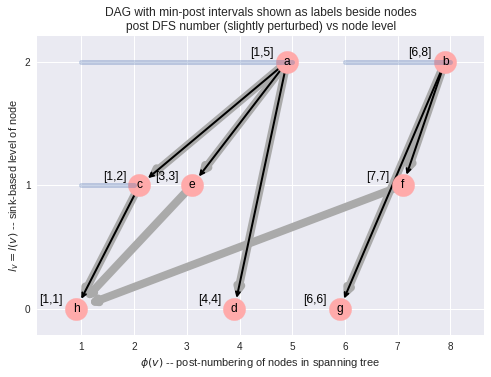

In [546]:
#@title Draw a DAG with min-post intervals (post+level) { run: "auto", form-width: "30%" }
import matplotlib.ticker as mticker

graphs = {
  'crown DAG': DG,
  'small DAG': sd,
  'didactic': de,
  'levels DAG': lf,
  'PReaCH DAG': ch,
}

graph_name = 'small DAG' #@param ["crown DAG", "small DAG", "didactic", "levels DAG", "PReaCH DAG"]
node_color = "#ffaaaa" #@param ["y", "m", "c", "b", "g", "r"] {allow-input: true}
draw_intervals = True #@param {type:"boolean"}
ytick_spacing = 1 #@param {type:"integer"}


graph=graphs[graph_name]
intervals=find_dfs_intervals(graph)
lvls=find_levels(graph)
#reach=find_reach(graph)
intervals_repr={
  v:('[%d,%d]'%(i[0],i[1]))
  for (v,i) in intervals.items()
}
pos={v: (intervals[v][1]+0.2*(lvls[v]%2)-0.1,lvls[v]) for v in graph}
max_pos=(
  max([x for (x,y) in pos.values()]),
  max([y for (x,y) in pos.values()])
)
dd=(
  -0.30*(max_pos[0]/5.0),
  +0.14*(max_pos[1]/4.0)
)

ax=plt.gca()
#ax.xaxis.set_major_locator(mticker.MultipleLocator(ytick_spacing)
ax.yaxis.set_ticks(np.arange(0, max(lvls.values())+1, ytick_spacing))
if draw_intervals:
  for v in graph:
    if intervals[v][0] == intervals[v][1]:
      continue
    ax.add_line(Line2D([intervals[v][0],intervals[v][1]],
                       [lvls[v],lvls[v]],
                       lw=5., alpha=0.3))

#plt.axis('off')
plt.xlabel('$\phi(v)$ -- post-numbering of nodes in spanning tree')
plt.ylabel('$l_v = l(v)$ -- sink-based level of node')
plt.title('DAG with min-post intervals shown as labels beside nodes\n'+
          'post DFS number (slightly perturbed) vs node level')

nx.draw_networkx(graph,
                 pos=pos,
                 width=8.0,edge_color='#aaaaaa',
                 node_size=500,node_color=node_color)
edges=nx.draw_networkx_edges(graph,
                             pos=pos,
                             edgelist=find_dfs_spanning(graph),
                             node_size=500,width=2.0,
                             arrowstyle='->')
labels=nx.draw_networkx_labels(graph,
                               pos={k: (v[0]+dd[0],v[1]+dd[1]) 
                                    for (k,v) in pos.items()},
                               labels=intervals_repr)
#print(edge_labels)

#### DFS spanning-tree extra data

In [547]:
#@title def find_dfs_intervals_extra { form-width: "30%" }
def find_dfs_intervals_extra(DG, extra=True):
  """Find DFS-derived data of all vertices in graph G
  
  Min-post interval labeling strategy labels each node 'u' in the directed
  spanning tree (DFS tree here) of the acyclic graph `DG` with a range
  I_u = [s_u, e_u], where e_u denotes the rank of the node 'u' in post-order
  traversal of the tree (ranks assumed to begin at 1), and s_u denotes the
  lowest rank of any node 'w' in the subtree rooted at 'u' (including 'u').
  This interval is stored under 'min' and 'post' keys in returned dict.
  
  For depth first-search (DFS) all nodes reachable from node 'u' have their
  topological ordering in DFS tree, i.e. 'post', smaller than the 'post'
  value for 'u'.  Additionally we can define 'f_min' as minimum 'post'
  number for each node reachable from 'u', and 'f_gap' as maximum 'post'
  number of nodes reachable from 'u' that are not in DFS subtree rooted
  at 'u' or None if 'f_gap' would be equal to 'u' node's 'min' number.
  
  We can also define 'p_tree' to be node reachable from 'u', but not in
  subtree rooted at 'u', that ('p_tree') has largest subtree.  If such
  node does not exist it is set to None.  For DFS spanning tree we can
  calculate this value effectively.
  
  This is based on *modified* algorithms from PReaCH paper [1];
  note that the original version in the paper [1] uses
  preorder not postorder numbers (pre-max not min-post).
  
  References:
  -----------
  [1] Florian Merz, Peter Sanders "PReaCH: A Fast Lightweight
      Reachability Index using Pruning and Contraction Hierarchies" (2014)
      In: Schulz A.S., Wagner D. (eds) Algorithms - ESA 2014. ESA 2014.
      Lecture Notes in Computer Science, vol 8737. Springer, Berlin,
      Heidelberg (Conference Paper: European Symposium on Algorithms)
      https://doi.org/10.1007/978-3-662-44777-2_58
      http://arxiv.org/abs/1404.4465
  
  Parameters:
  -----------
  DG : NetworkX DiGraph
      Directed acyclic graph.
      
  extra : bool, optional (default=True)
      Whether to compute extra DFS data in addition to min-post interval.
          
  Returns:
  --------
  dict of dicts
      Dictionary, where keys are node indices, and values are dictionaries
      with various DFS spanning-tree derived data.
  """
  data = {}
  # create graph of spanning tree (DFS spanning tree) of DG
  span=nx.DiGraph()
  span.add_nodes_from(DG)
  span.add_edges_from(find_dfs_spanning(DG))
  
  # needs depth-first search for some of indices to actually work
  nodelist = nx.dfs_postorder_nodes(DG)
  for pos, node in enumerate(nodelist, start=1):
    data[node] = {}
    
    # DEBUG
    #print('node=%s\n -> %r\n => %r' %
    #      (node,
    #       list(span.successors(node)),
    #       list(DG.successors(node))))
    
    data[node]['post'] = pos
    if span.out_degree(node) == 0:
      data[node]['min'] = pos
    else:
      data[node]['min'] = min(pos,
                              *[data[neigh]['min'] 
                                for neigh in span.successors(node)])
    
    if not extra:
      continue
    
    if DG.out_degree(node) == 0:
      data[node]['f_min'] = pos
      data[node]['f_gap'] = None
      data[node]['p_tree'] = None
    else:
      data[node]['f_min'] = min(pos,
                                *[data[neigh]['f_min'] 
                                  for neigh in DG.successors(node)])
      
      f_gap_candidates = \
        [data[neigh]['post']
         for neigh in DG.successors(node)
         if data[neigh]['post'] < data[node]['min']] + \
        [data[neigh]['f_gap']
         for neigh in DG.successors(node)
         if data[neigh]['f_gap'] is not None]
      if f_gap_candidates:
        data[node]['f_gap'] = max(f_gap_candidates)
      else:
        data[node]['f_gap'] = None
     
      p_tree_candidates = \
        [data[neigh]['p_tree']
         for neigh in DG.successors(node)
         if data[neigh]['p_tree'] is not None and \
            data[neigh]['p_tree'] < data[node]['min']] + \
        [neigh
         for neigh in DG.successors(node)
         if data[neigh]['post'] < data[node]['min']]
      if p_tree_candidates:
        data[node]['p_tree'] = max(
          p_tree_candidates,
          key=lambda n: data[n]['post'] - data[n]['min']
        )
      else:
        data[node]['p_tree'] = None
  
  return data


# DEBUG
find_dfs_intervals_extra(sd)

{'a': {'f_gap': 1, 'f_min': 1, 'min': 1, 'p_tree': None, 'post': 5},
 'b': {'f_gap': 1, 'f_min': 1, 'min': 6, 'p_tree': None, 'post': 8},
 'c': {'f_gap': None, 'f_min': 1, 'min': 1, 'p_tree': None, 'post': 2},
 'd': {'f_gap': None, 'f_min': 4, 'min': 4, 'p_tree': None, 'post': 4},
 'e': {'f_gap': 1, 'f_min': 1, 'min': 3, 'p_tree': 'h', 'post': 3},
 'f': {'f_gap': 1, 'f_min': 1, 'min': 7, 'p_tree': 'h', 'post': 7},
 'g': {'f_gap': None, 'f_min': 6, 'min': 6, 'p_tree': None, 'post': 6},
 'h': {'f_gap': None, 'f_min': 1, 'min': 1, 'p_tree': None, 'post': 1}}

In [548]:
find_dfs_intervals(sd)

{'a': [1, 5],
 'b': [6, 8],
 'c': [1, 2],
 'd': [4, 4],
 'e': [3, 3],
 'f': [7, 7],
 'g': [6, 6],
 'h': [1, 1]}

In [549]:
#@title def find_dfs_preorder_intervals_extra { form-width: "30%" }
def find_dfs_preorder_intervals_extra(DG):
  """Find DFS-derived data of all vertices in graph G
  
  TODO: <description from PReaCH paper here>.
  
  This is based on algorithms from PReaCH paper [1].
  
  References:
  -----------
  [1] Florian Merz, Peter Sanders "PReaCH: A Fast Lightweight
      Reachability Index using Pruning and Contraction Hierarchies" (2014)
      http://arxiv.org/abs/1404.4465
  
  Parameters:
  -----------
  DG : NetworkX DiGraph
      Directed acyclic graph.
          
  Returns:
  --------
  dict of dicts
      Dictionary, where keys are node indices, and values are dictionaries
      with various DFS spanning-tree derived data.
  """
  data = {}
  # create graph of spanning tree (DFS spanning tree) of DG
  span=nx.DiGraph()
  span.add_nodes_from(DG)
  span.add_edges_from(find_dfs_spanning(DG))
  
  # needs depth-first search for some of indices to actually work
  nodelist = list(nx.dfs_preorder_nodes(DG))
  nodepos = order_to_pos(nodelist, start=1)
  # DEBUG
  #print('nodelist = %r\nnodepos  = %r' % (nodelist, nodepos))
  for node in nx.dfs_postorder_nodes(DG):
    pos = nodepos[node]
    data[node] = {}

    # DEBUG
    #print('node=%s [%d]\n -> %r\n => %r' %
    #      (node,pos,
    #       list(span.successors(node)),
    #       list(DG.successors(node))))
    
    data[node]['pre'] = pos
    if span.out_degree(node) == 0:
      data[node]['max'] = pos
    else:
      data[node]['max'] = max(pos,
                              *[data[neigh]['max'] 
                                for neigh in span.successors(node)])  
      
    if DG.out_degree(node) == 0:
      data[node]['f_min'] = pos
      data[node]['f_gap'] = None
      data[node]['p_tree'] = None
    else:
      data[node]['f_min'] = min(pos,
                                *[data[neigh]['f_min'] 
                                  for neigh in DG.successors(node)])

      f_gap_candidates = \
        [data[neigh]['max']
         for neigh in DG.successors(node)
         if data[neigh]['pre'] < data[node]['pre']] + \
        [data[neigh]['f_gap']
         for neigh in DG.successors(node)
         if data[neigh]['f_gap'] is not None]
      if f_gap_candidates:
        data[node]['f_gap'] = max(f_gap_candidates)
      else:
        data[node]['f_gap'] = None
     
      p_tree_candidates = \
        [data[neigh]['p_tree']
         for neigh in DG.successors(node)
         if data[neigh]['p_tree'] is not None and \
            data[neigh]['pre'] < data[node]['pre']] + \
        [neigh
         for neigh in DG.successors(node)
         if data[neigh]['pre'] < data[node]['pre']]
      if p_tree_candidates:
        data[node]['p_tree'] = max(
          p_tree_candidates,
          key=lambda n: data[n]['max'] - data[n]['pre']
        )
      else:
        data[node]['p_tree'] = None
  
  return data


# DEBUG
find_dfs_preorder_intervals_extra(sd)

{'a': {'f_gap': 3, 'f_min': 1, 'max': 5, 'p_tree': None, 'pre': 1},
 'b': {'f_gap': 3, 'f_min': 3, 'max': 8, 'p_tree': None, 'pre': 6},
 'c': {'f_gap': None, 'f_min': 2, 'max': 3, 'p_tree': None, 'pre': 2},
 'd': {'f_gap': None, 'f_min': 5, 'max': 5, 'p_tree': None, 'pre': 5},
 'e': {'f_gap': 3, 'f_min': 3, 'max': 4, 'p_tree': 'h', 'pre': 4},
 'f': {'f_gap': 3, 'f_min': 3, 'max': 8, 'p_tree': 'h', 'pre': 8},
 'g': {'f_gap': None, 'f_min': 7, 'max': 7, 'p_tree': None, 'pre': 7},
 'h': {'f_gap': None, 'f_min': 3, 'max': 3, 'p_tree': None, 'pre': 3}}

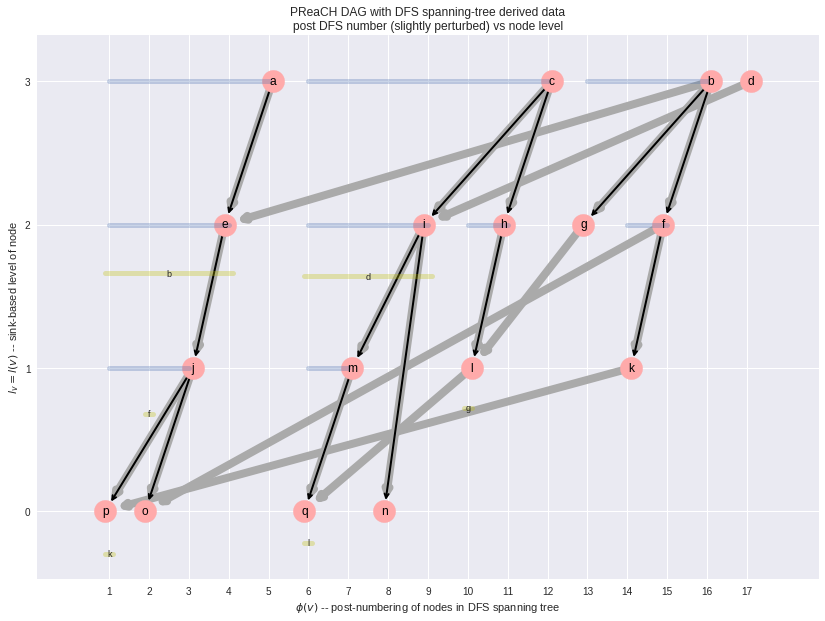

In [550]:
#@title Draw a DAG with DFS numbering data (post+level) { run: "auto", form-width: "30%" }
graphs = {
  'crown DAG': DG,
  'small DAG': sd,
  'didactic': de,
  'levels DAG': lf,
  'PReaCH DAG': ch,
}

graph_name = 'PReaCH DAG' #@param ["crown DAG", "small DAG", "didactic", "levels DAG", "PReaCH DAG"]
node_color = "#ffaaaa" #@param ["y", "m", "c", "b", "g", "r"] {allow-input: true}
show_p_tree = "low" #@param ["none","low","high"]
xtick_spacing = 1 #@param {type:"integer"}
ytick_spacing = 1 #@param {type:"integer"}
fig_sizex = 14 #@param {type:"slider", min:5, max:25, step:1}
fig_sizey = 10 #@param {type:"slider", min:5, max:25, step:1}
fig_square = False #@param {type:"boolean"}

fig = plt.figure()
fig.set_size_inches(fig_sizex,fig_sizey)

ax=plt.gca()
if fig_square:
  ax.set(adjustable='box-forced', aspect='equal')

graph=graphs[graph_name]
intervals=find_dfs_intervals_extra(graph)
lvls=find_levels(graph)
#reach=find_reach(graph)

pos={v: (intervals[v]['post']+0.2*(lvls[v]%2)-0.1,
         lvls[v])
     for v in graph}
max_pos=(
  max([x for (x,y) in pos.values()]),
  max([y for (x,y) in pos.values()])
)
dd=(
  -0.30*(max_pos[0]/5.0),
  +0.14*(max_pos[1]/4.0)
)

ax.xaxis.set_ticks(np.arange(1, len(graph)+1, xtick_spacing))
ax.yaxis.set_ticks(np.arange(0, max_pos[1]+2, ytick_spacing))

for v in graph:
  if intervals[v]['min'] != intervals[v]['post']:
    ax.add_line(Line2D([intervals[v]['min'],intervals[v]['post']],
                       [lvls[v],lvls[v]],
                       lw=5., alpha=0.3))
  if intervals[v]['p_tree'] is not None and \
     show_p_tree != "none":
    p = intervals[v]['p_tree']
    vx= intervals[v]['post']
    if show_p_tree == "low":
      yy= lvls[v]-0.02-0.020*vx - 1
    else:
      yy= lvls[v]+0.02+0.015*vx
    ax.add_line(Line2D([intervals[p]['min']-0.1,intervals[p]['post']+0.1],
                       [yy,yy],
                       lw=5., alpha=0.3, c='y'))
    ax.annotate(str(v),
                xy=(0.5*(intervals[p]['min']+intervals[p]['post']),
                    yy),
                horizontalalignment='center', verticalalignment='center',
                fontsize=9)

#plt.axis('off')
plt.xlabel('$\phi(v)$ -- post-numbering of nodes in DFS spanning tree')
plt.ylabel('$l_v = l(v)$ -- sink-based level of node')
plt.title(graph_name+' with DFS spanning-tree derived data\n'+
          'post DFS number (slightly perturbed) vs node level')

nx.draw_networkx(graph,
                 pos=pos,
                 width=8.0,edge_color='#aaaaaa',
                 node_size=500,node_color=node_color)
edges=nx.draw_networkx_edges(graph,
                             pos=pos,
                             edgelist=find_dfs_spanning(graph),
                             node_size=500,width=2.0,
                             arrowstyle='->')
plt.show()

In [551]:
find_dfs_intervals_extra(ch)

{'a': {'f_gap': None, 'f_min': 1, 'min': 1, 'p_tree': None, 'post': 5},
 'b': {'f_gap': 10, 'f_min': 1, 'min': 13, 'p_tree': 'e', 'post': 16},
 'c': {'f_gap': 6, 'f_min': 6, 'min': 6, 'p_tree': None, 'post': 12},
 'd': {'f_gap': 9, 'f_min': 6, 'min': 17, 'p_tree': 'i', 'post': 17},
 'e': {'f_gap': None, 'f_min': 1, 'min': 1, 'p_tree': None, 'post': 4},
 'f': {'f_gap': 2, 'f_min': 1, 'min': 14, 'p_tree': 'o', 'post': 15},
 'g': {'f_gap': 10, 'f_min': 6, 'min': 13, 'p_tree': 'l', 'post': 13},
 'h': {'f_gap': 6, 'f_min': 6, 'min': 10, 'p_tree': None, 'post': 11},
 'i': {'f_gap': None, 'f_min': 6, 'min': 6, 'p_tree': None, 'post': 9},
 'j': {'f_gap': None, 'f_min': 1, 'min': 1, 'p_tree': None, 'post': 3},
 'k': {'f_gap': 1, 'f_min': 1, 'min': 14, 'p_tree': 'p', 'post': 14},
 'l': {'f_gap': 6, 'f_min': 6, 'min': 10, 'p_tree': 'q', 'post': 10},
 'm': {'f_gap': None, 'f_min': 6, 'min': 6, 'p_tree': None, 'post': 7},
 'n': {'f_gap': None, 'f_min': 8, 'min': 8, 'p_tree': None, 'post': 8},
 'o':

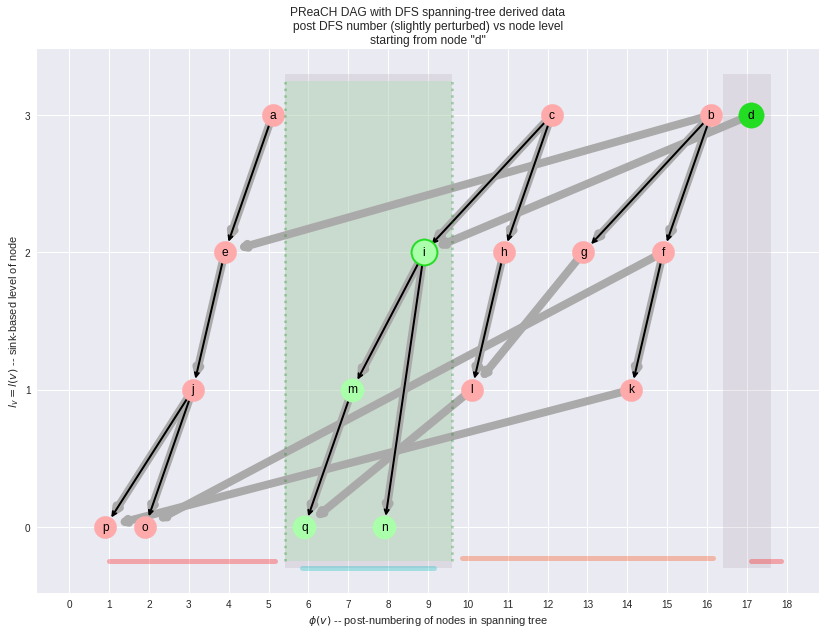

source = d (PReaCH DAG)
- 17 nodes
- 5 non n_neg (12 n_neg)
- 4 reachable
  * 0 false positives (not excluded but unreachable)
  * 0 false negatives (not included but reachable)
- 4 n_pos (5 n_pos incl.)


In [552]:
#@title Visualize DFS numbering data (post+level) for PReaCH graph { run: "auto", form-width: "30%" }
graphs = {
  'crown DAG': DG,
  'small DAG': sd,
  'didactic': de,
  'levels DAG': lf,
  'PReaCH DAG': ch,
}

graph_name = 'PReaCH DAG'
node_color = "#ffaaaa" #@param ["y", "m", "c", "b", "g", "r"] {allow-input: true}

xtick_spacing = 1 #@param {type:"integer"}
ytick_spacing = 1 #@param {type:"integer"}
fig_sizex = 14 #@param {type:"slider", min:5, max:25, step:1}
fig_sizey = 10 #@param {type:"slider", min:5, max:25, step:1}
fig_square = False #@param {type:"boolean"}
src = "d" #@param ["a","c","b","d","g","f","k"]

fig = plt.figure()
fig.set_size_inches(fig_sizex,fig_sizey)

ax=plt.gca()
if fig_square:
  ax.set(adjustable='box-forced', aspect='equal')

graph=graphs[graph_name]
intervals=find_dfs_intervals_extra(graph)
lvls=find_levels(graph)
reachable=find_reachable(graph)

pos={v: (intervals[v]['post']+0.2*(lvls[v]%2)-0.1,
         lvls[v])
     for v in graph}
max_pos=(
  max([x for (x,y) in pos.values()]),
  max([y for (x,y) in pos.values()])
)
dd=(
  -0.30*(max_pos[0]/5.0),
  +0.14*(max_pos[1]/4.0)
)

ax.xaxis.set_ticks(np.arange(0, max_pos[0]+1, xtick_spacing))
ax.yaxis.set_ticks(np.arange(0, max_pos[1]+2, ytick_spacing))

v = src
n_pos=0
n_neg=0
n_all=len(graph)
if True:
  if intervals[v]['p_tree'] is not None:
    p = intervals[v]['p_tree']
    vx= intervals[v]['post']
    yy=-0.3
    ax.add_line(Line2D([intervals[p]['min']-0.15,intervals[p]['post']+0.15],
                       [yy,yy],
                       lw=5., alpha=0.3, c='c'))
    #ax.annotate(str(v),
    #            xy=(0.5*(intervals[p]['min']+intervals[p]['post']),
    #                yy),
    #            horizontalalignment='center', verticalalignment='center',
    #            fontsize=9)
    ax.add_patch(Rectangle((intervals[p]['min']-0.6,-0.25),
                           intervals[p]['post']-intervals[p]['min']+1.2,
                           max_pos[1]+0.5, facecolor="#99ee99",alpha=0.3))
    ax.add_line(Line2D([intervals[p]['min']-0.6,intervals[p]['min']-0.6],
                       [-0.25,max_pos[1]+0.25],
                       linestyle='dotted',
                       lw=2.5,c='g',alpha=0.3))
    ax.add_line(Line2D([intervals[p]['post']+0.6,intervals[p]['post']+0.6],
                       [-0.25,max_pos[1]+0.25],
                       linestyle='dotted',
                       lw=2.5,c='g',alpha=0.3))
    n_pos += intervals[p]['post']-intervals[p]['min']+1
    nx.draw_networkx_nodes(graph,
                       pos=pos,
                       nodelist=[p],
                       node_size=750,node_color='#22dd22')
  
  if intervals[v]['post'] < max_pos[0]:
    ax.add_line(Line2D([intervals[v]['post']+1-0.15,max_pos[0]],
                       [-0.25,-0.25],
                       lw=5., alpha=0.3, c='r'))
    n_neg += n_all - intervals[v]['post']
  if intervals[v]['f_min'] > 1:
    ax.add_line(Line2D([1,intervals[v]['f_min']-1+0.15],
                       [-0.25,-0.25],
                       lw=5., alpha=0.3, c='r'))
    n_neg += intervals[v]['f_min']-1
  if intervals[v]['f_gap'] is not None and \
     intervals[v]['f_gap']+1 <= intervals[v]['min']-1:
    ax.add_line(Line2D([intervals[v]['f_gap']+1-0.15,
                        intervals[v]['min']  -1+0.15],
                       [-0.23,-0.23],
                       lw=5., alpha=0.3, c='#ff4400'))
    n_neg += intervals[v]['min']-intervals[v]['f_gap']-1
    ax.add_patch(Rectangle((intervals[v]['f_min']-0.6,-0.30),
                           intervals[v]['f_gap']-intervals[v]['f_min']+1.2,
                           max_pos[1]+0.6, facecolor="#aa99aa",alpha=0.2))
    ax.add_patch(Rectangle((intervals[v]['min']-0.6,-0.30),
                           intervals[v]['post']-intervals[v]['min']+1.2,
                           max_pos[1]+0.6, facecolor="#aa99aa",alpha=0.2))
  else:
    ax.add_patch(Rectangle((intervals[v]['f_min']-0.6,-0.30),
                           intervals[v]['post']-intervals[v]['f_min']+1.2,
                           max_pos[1]+0.60, facecolor="#aa88bb",alpha=0.2))
    
  if intervals[v]['min'] != intervals[v]['post']:
    ax.add_line(Line2D([intervals[v]['min']-0.15,intervals[v]['post']+0.15],
                       [-0.2,-0.2],
                       lw=5., alpha=0.3, c='b'))
    ax.add_patch(Rectangle((intervals[v]['min']-0.6,-0.25),
                           intervals[v]['post']-intervals[v]['min']+1.2,
                           max_pos[1]+0.5, facecolor="#99ff99",alpha=0.3))
    ax.add_line(Line2D([intervals[v]['min']-0.6,intervals[v]['min']-0.6],
                       [-0.25,max_pos[1]+0.25],
                       linestyle='dashed',
                       lw=2.5,c='g',alpha=0.3))
    ax.add_line(Line2D([intervals[v]['post']+0.6,intervals[v]['post']+0.6],
                       [-0.25,max_pos[1]+0.25],
                       linestyle='dashed',
                       lw=2.5,c='g',alpha=0.3))
  n_pos += intervals[v]['post']-intervals[v]['min']

#plt.axis('off')
plt.xlabel('$\phi(v)$ -- post-numbering of nodes in spanning tree')
plt.ylabel('$l_v = l(v)$ -- sink-based level of node')
plt.title(graph_name+' with DFS spanning-tree derived data\n'+
          'post DFS number (slightly perturbed) vs node level\n'+
          'starting from node "'+str(src)+'"')

nx.draw_networkx(graph,
                 pos=pos,
                 width=8.0,edge_color='#aaaaaa',
                 node_size=500,node_color=node_color)
nx.draw_networkx_edges(graph,
                       pos=pos,
                       edgelist=find_dfs_spanning(graph),
                       node_size=500,width=2.0,
                       arrowstyle='->')
nx.draw_networkx_nodes(graph,
                       pos=pos,
                       nodelist=reachable[src]+[src],
                       node_size=550,node_color='#aaffaa')
nx.draw_networkx_nodes(graph,
                       pos=pos,
                       nodelist=[src],
                       node_size=650,node_color='#22dd22')

plt.show()

print('source = %s (%s)' % (src, graph_name))
print('- %d nodes' % n_all)
print('- %d non n_neg (%d n_neg)' % (n_all - n_neg, n_neg))
print('- %d reachable' % len(set(reachable[src])))
print('  * %d false positives (not excluded but unreachable)' %
      (n_all - n_neg - 1 - len(set(reachable[src]))))
print('  * %d false negatives (not included but reachable)' %
      (len(set(reachable[src]))-n_pos))
print('- %d n_pos (%d n_pos incl.)' % (n_pos, n_pos+1))

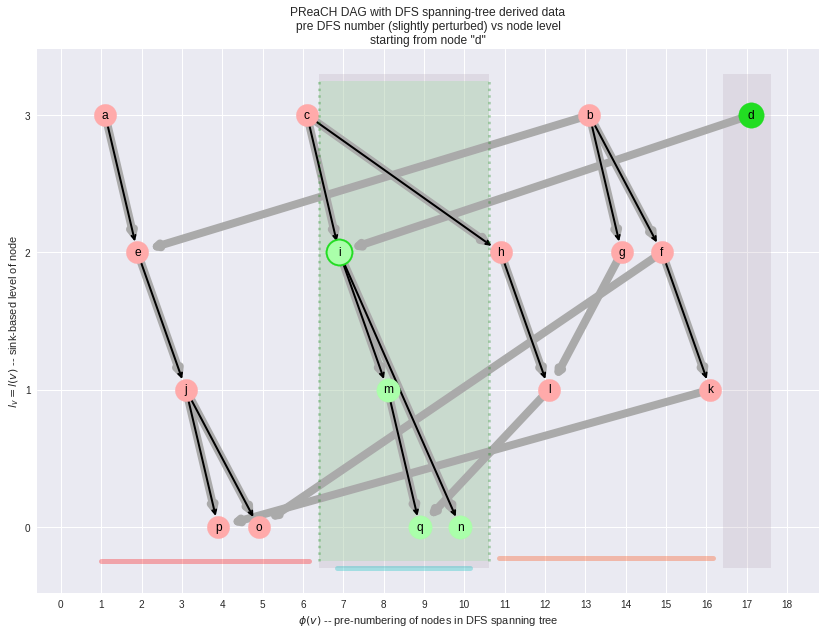

source = d (PReaCH DAG)
- 17 nodes
- 5 non n_neg (12 n_neg)
- 4 reachable
  * 0 false positives (not excluded but unreachable)
  * 0 false negatives (not included but reachable)
- 4 n_pos (5 n_pos incl.)


In [553]:
#@title Visualize DFS numbering data (pre+level) for PReaCH graph { run: "auto", form-width: "30%" }
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

#graphs = {
#  'crown DAG': DG,
#  'small DAG': sd,
#  'didactic': de,
#  'levels DAG': lf,
#  'PReaCH DAG': ch,
#}

graph_name = 'PReaCH DAG'
node_color = "#ffaaaa" #@param ["y", "m", "c", "b", "g", "r"] {allow-input: true}

xtick_spacing = 1 #@param {type:"integer"}
ytick_spacing = 1 #@param {type:"integer"}
fig_sizex = 14 #@param {type:"slider", min:5, max:25, step:1}
fig_sizey = 10 #@param {type:"slider", min:5, max:25, step:1}
fig_square = False #@param {type:"boolean"}
src = "d" #@param ["a","c","b","d","g","f","k"]
#fig_rch_map = False #@param {type:"boolean"}
#interpolation = "bicubic" #@param ["none", "nearest", "bilinear", "bicubic", "spline16", "spline36", "hanning", "hamming", "hermite", "kaiser", "quadric", "catrom", "gaussian", "bessel", "mitchell", "sinc", "lanczos"]
fig_rch_map = False
interpolation = 'bicubic'

fig = plt.figure()
fig.set_size_inches(fig_sizex,fig_sizey)

ax=plt.gca()
if fig_square:
  ax.set(adjustable='box-forced', aspect='equal')

#graph=graphs[graph_name]
graph=ch
intervals=find_dfs_preorder_intervals_extra(graph)
lvls=find_levels(graph)
reachable=find_reachable(graph)

pos={v: (intervals[v]['pre']+0.2*(lvls[v]%2)-0.1,
         lvls[v])
     for v in graph}
max_pos=(
  max([x for (x,y) in pos.values()]),
  max([y for (x,y) in pos.values()])
)
dd=(
  -0.30*(max_pos[0]/5.0),
  +0.14*(max_pos[1]/4.0)
)

ax.xaxis.set_ticks(np.arange(0, max_pos[0]+1, xtick_spacing))
ax.yaxis.set_ticks(np.arange(0, max_pos[1]+2, ytick_spacing))

# NOTE: map has sense only for planar drawing of graph
if fig_rch_map:
  oxy=np.full((4,19),np.nan)
  for n in ch.labels:
    oxy[lvls[n],intervals[n]['pre']] = ch.labels[n]
  oxy[np.isnan(oxy)] = 0
  plt.imshow(oxy,
             origin='lower',
             # https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.imshow.html
             # https://matplotlib.org/gallery/images_contours_and_fields/interpolation_methods.html
             interpolation=interpolation,
             aspect='auto',
             #cmap=plt.cm.Purples,
             cmap=plt.cm.terrain,
             #vmin=-8,vmax=len(ch)*2,
             alpha=0.3)

v = src
n_pos=0
n_neg=0
n_all=len(graph)
if True:
  if intervals[v]['p_tree'] is not None:
    p = intervals[v]['p_tree']
    vx= intervals[v]['pre']
    yy=-0.3
    x_s = intervals[p]['pre']
    x_e = intervals[p]['max']
    ax.add_line(Line2D([x_s-0.15,x_e+0.15],
                       [yy,yy],
                       lw=5., alpha=0.3, c='c'))
    ax.add_patch(Rectangle((x_s-0.6,-0.25),
                           x_e-x_s+1.2,
                           max_pos[1]+0.5, facecolor="#99ee99",alpha=0.3))
    ax.add_line(Line2D([x_s-0.6,x_s-0.6],
                       [-0.25,max_pos[1]+0.25],
                       linestyle='dotted',
                       lw=2.5,c='g',alpha=0.3))
    ax.add_line(Line2D([x_e+0.6,x_e+0.6],
                       [-0.25,max_pos[1]+0.25],
                       linestyle='dotted',
                       lw=2.5,c='g',alpha=0.3))
    n_pos += intervals[p]['max']-intervals[p]['pre']+1
    nx.draw_networkx_nodes(graph,
                       pos=pos,
                       nodelist=[p],
                       node_size=750,node_color='#22dd22')
  
  if intervals[v]['max'] < n_all:
    ax.add_line(Line2D([intervals[v]['max']+1-0.15,n_all+0.15],
                       [-0.25,-0.25],
                       lw=5., alpha=0.3, c='r'))
    n_neg += n_all - intervals[v]['max']
  if intervals[v]['f_min'] > 1:
    ax.add_line(Line2D([1,intervals[v]['f_min']-1+0.15],
                       [-0.25,-0.25],
                       lw=5., alpha=0.3, c='r'))
    n_neg += intervals[v]['f_min']-1
  if intervals[v]['f_gap'] is not None and \
     intervals[v]['f_gap']+1 <= intervals[v]['pre']-1:
    ax.add_line(Line2D([intervals[v]['f_gap']+1-0.15,
                        intervals[v]['pre']  -1+0.15],
                       [-0.23,-0.23],
                       lw=5., alpha=0.3, c='#ff4400'))
    n_neg += intervals[v]['pre']-intervals[v]['f_gap']-1
    
    ax.add_patch(Rectangle((intervals[v]['f_min']-0.6,-0.30),
                           intervals[v]['f_gap']-intervals[v]['f_min']+1.2,
                           max_pos[1]+0.6, facecolor="#aa99aa",alpha=0.2))
    ax.add_patch(Rectangle((intervals[v]['pre']-0.6,-0.30),
                           intervals[v]['max']-intervals[v]['pre']+1.2,
                           max_pos[1]+0.6, facecolor="#aa99aa",alpha=0.2))
  else:
    ax.add_patch(Rectangle((intervals[v]['f_min']-0.6,-0.30),
                           intervals[v]['max']-intervals[v]['f_min']+1.2,
                           max_pos[1]+0.60, facecolor="#aa88bb",alpha=0.2))
    
  if intervals[v]['pre'] != intervals[v]['max']:
    x_s = intervals[v]['pre']
    x_e = intervals[v]['max']
    ax.add_line(Line2D([x_s-0.15,x_e+0.15],
                       [-0.2,-0.2],
                       lw=5., alpha=0.3, c='b'))
    ax.add_patch(Rectangle((x_s-0.6,-0.25),
                           x_e-x_s+1.2,
                           max_pos[1]+0.5, facecolor="#99ff99",alpha=0.3))
    ax.add_line(Line2D([x_s-0.6,x_s-0.6],
                       [-0.25,max_pos[1]+0.25],
                       linestyle='dashed',
                       lw=2.5,c='g',alpha=0.3))
    ax.add_line(Line2D([x_e+0.6,x_e+0.6],
                       [-0.25,max_pos[1]+0.25],
                       linestyle='dashed',
                       lw=2.5,c='g',alpha=0.3))
  n_pos += intervals[v]['max']-intervals[v]['pre']

#plt.axis('off')
plt.xlabel('$\phi(v)$ -- pre-numbering of nodes in DFS spanning tree')
plt.ylabel('$l_v = l(v)$ -- sink-based level of node')
plt.title(graph_name+' with DFS spanning-tree derived data\n'+
          'pre DFS number (slightly perturbed) vs node level\n'+
          'starting from node "'+str(src)+'"')

nx.draw_networkx(graph,
                 pos=pos,
                 width=8.0,edge_color='#aaaaaa',
                 node_size=500,node_color=node_color)
nx.draw_networkx_edges(graph,
                       pos=pos,
                       edgelist=find_dfs_spanning(graph),
                       node_size=500,width=2.0,
                       arrowstyle='->')
nx.draw_networkx_nodes(graph,
                       pos=pos,
                       nodelist=reachable[src]+[src],
                       node_size=550,node_color='#aaffaa')
nx.draw_networkx_nodes(graph,
                       pos=pos,
                       nodelist=[src],
                       node_size=650,node_color='#22dd22')

plt.show()

print('source = %s (%s)' % (src, graph_name))
print('- %d nodes' % n_all)
print('- %d non n_neg (%d n_neg)' % (n_all - n_neg, n_neg))
print('- %d reachable' % len(set(reachable[src])))
print('  * %d false positives (not excluded but unreachable)' %
      (n_all - n_neg - 1 - len(set(reachable[src]))))
print('  * %d false negatives (not included but reachable)' %
      (len(set(reachable[src]))-n_pos))
print('- %d n_pos (%d n_pos incl.)' % (n_pos, n_pos+1))

### FELINE-index algorithms

['b', 'f', 'g', 'a', 'd', 'e', 'c', 'h']
{'a': 3, 'c': 6, 'b': 0, 'e': 5, 'd': 4, 'g': 2, 'f': 1, 'h': 7}


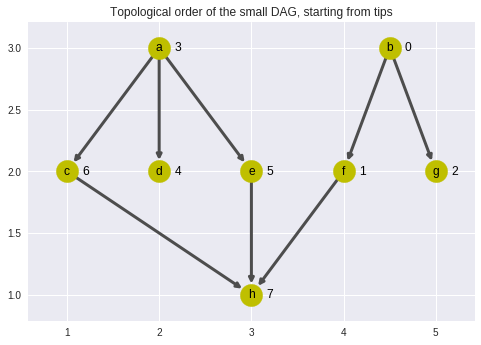

In [554]:
# draw a graph using level-based layout, show its topological ordering

nodes=list(nx.topological_sort(sd))
#order=order_to_pos(reversed(nodes))
order=order_to_pos(nodes)
print(nodes)
#print(order_to_pos(nodes))
print(order)

plt.title('Topological order of the small DAG, starting from tips')
nx.draw_networkx(sd,
                 pos=sd.tree,
                 node_size=500,width=3.0,
                 edge_color='0.3',node_color='y')
nx.draw_networkx_labels(sd,
                        pos={k: (v[0]+0.20,v[1]-0.00) 
                             for (k,v) in sd.tree.items()},
                        labels=order);

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
{'a': 0, 'c': 2, 'b': 1, 'e': 4, 'd': 3, 'g': 6, 'f': 5, 'h': 7}


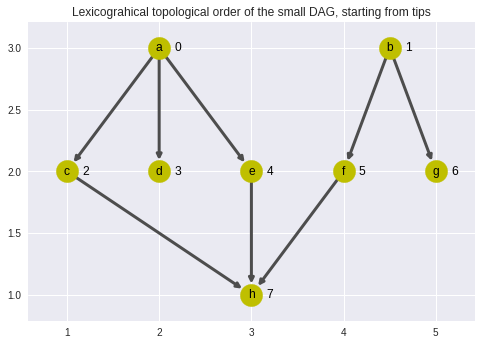

In [555]:
nodes=list(nx.lexicographical_topological_sort(sd))
order=order_to_pos(nodes)
print(nodes)
print(order)

plt.title('Lexicograhical topological order of the small DAG, starting from tips')
nx.draw_networkx(sd,
                 pos=sd.tree,
                 node_size=500,width=3.0,
                 edge_color='0.3',node_color='y')
nx.draw_networkx_labels(sd,
                        pos={k: (v[0]+0.20,v[1]-0.00) 
                             for (k,v) in sd.tree.items()},
                        labels=order);

#### Calculating FELINE index

**Algorithm 1:** Index construction (FELINE)

In [0]:
#@title def find_feline { form-width: "30%" }
def find_feline(DG, attr=None, topological_sort=nx.topological_sort):
  """Generate the coordinates that compose the FELINE index
  
  The FELINE (Fast rEfined onLINE search) index for a vertex is a unique
  ordered pair of natural integers chosen in such way, that the implication
  
    r(u, v)  =>  x_u <= x_v && y_u <= y_v
    
  Here r(u, v) means that v is reachable from u, that is that there exist
  a path from u to v in directed graph DG.
  
  The method is based on the idea of weak dominance drawing, where
  the above relation for pairs is true for each edge in the DAG.
  
  One can think of the pair of integers associated with a vertex as
  coordinates in the Cartesian plane.
  
  Parameters:
  -----------
  DG : NetworkX DiGraph
      Directed acyclic graph.
      
  attr : str, optional (default=None)
      If set, name of a node attribute under which store FELINE index.
      
  topological_sort : function, optional (default=nx.topological_sort)
      Function that given NetworkX DiGraph returns list of its nodes
      (vertices) sorted in topological order, starting from "tips" nodes
      without any incoming edges, and always having vertices before their
      descendants.
      
      Any topological ordering algorithm can be used, but the quality of
      the FELINE index generated from it, namely the number of falsely
      implied paths, depends on the order chosen.
      
  Returns:
  --------
  dict of two-element tuples of ints
      Dictionary, where keys are node indices, and values are two element
      tuples storing the X and Y coordinates of FELINE index.
  """
  # X and Y are dictionaries of positions,
  # xl and yl are sorted lists of nodes
  X = order_to_pos(topological_sort(DG))
  yl = []
  
  d = {v: DG.in_degree(v) for v in DG}
  roots = [node for node in DG if d[node] == 0]
  while roots:
    # $u = argmax_{v \in roots}(X_v)$
    u = max(roots, key=X.get)
    # Append $u$ to $Y$
    yl.append(u)
    # Update $d$ and the $roots$ set
    roots = [node for node in roots if node != u]
    for n in DG.successors(u):
      d[n] -= 1
      if d[n] == 0:
        roots.append(n)
    
  Y = order_to_pos(yl)
  
  feline = {v: (X[v],Y[v]) for v in DG}
  
  if attr is not None:
    for node, pos in feline.items():
      DG.nodes[node][attr] = deepcopy(pos)
  
  return feline

Testing find_feline on known graphs

In [557]:
#@title test find_feline { form-width: "30%" }
lf.pos=lf.fel
for graph_name, graph in graphs.items():
  print('%s:' % graph_name)
  print(' --> %r' % find_feline(graph))
  if hasattr(graph, 'pos'):
    print(' pos=%r' % graph.pos)
  if hasattr(graph, 'fel'):
    print(' fel=%r' % graph.fel)

small DAG:
 --> {'a': (3, 0), 'c': (6, 1), 'b': (0, 4), 'e': (5, 2), 'd': (4, 3), 'g': (2, 5), 'f': (1, 6), 'h': (7, 7)}
 pos={'a': (1, 4), 'c': (2, 7), 'b': (5, 1), 'e': (4, 5), 'd': (3, 6), 'g': (8, 2), 'f': (6, 3), 'h': (7, 8)}
didactic:
 --> {'a': (0, 0), 'c': (7, 1), 'b': (4, 3), 'e': (6, 4), 'd': (1, 6), 'g': (8, 2), 'f': (5, 5), 'i': (3, 7), 'h': (2, 8)}
 pos={'a': (0, 0), 'c': (4, 4), 'b': (1, 6), 'e': (2, 8), 'd': (6, 1), 'g': (5, 5), 'f': (3, 7), 'i': (8, 2), 'h': (7, 3)}
levels DAG:
 --> {'a': (3, 0), 'c': (8, 1), 'b': (0, 5), 'e': (6, 2), 'd': (4, 4), 'g': (5, 7), 'f': (1, 6), 'i': (2, 8), 'h': (7, 3)}
 pos={'a': (1, 4), 'c': (2, 9), 'b': (6, 1), 'e': (4, 5), 'd': (3, 7), 'g': (8, 8), 'f': (7, 2), 'i': (9, 3), 'h': (5, 6)}
 fel={'a': (1, 4), 'c': (2, 9), 'b': (6, 1), 'e': (4, 5), 'd': (3, 7), 'g': (8, 8), 'f': (7, 2), 'i': (9, 3), 'h': (5, 6)}
crown DAG:
 --> {1: (3, 0), 2: (5, 4), 3: (1, 1), 4: (2, 5), 'u': (0, 3), 'v': (4, 2)}
 pos={1: (1, 4), 2: (3, 6), 3: (4, 1), 4: (6,

Note that FELINE index depends on the topological sort ordering of nodes in graph, and there are usually many equivalent topological orderings.  That is why calculated FELINE index differs (or can differ) from the one in FELINE paper

#### Quality of FELINE index (and comparison with paper's version)

In [0]:
#@title def feline_fp (falsely-implied paths) { form-width: "30%" }
def feline_fp(DG, index):
  """Given graph and FELINE index, find all falsely implied paths
  
  Falsely implied paths, or false positives, are those pairs of (u, v) of
  vertices, where FELINE indices fullfill the partial order, that is
  i(u) ≼ i(v) but vertex 'v' is not reachable from 'u', r(u,v) is false.
  
  Parameters:
  -----------
  DG : NetworkX DiGraph
      Directed acyclic graph.
      
  index : dictionary of two element tuples of ints
      Dictionary where keys are vertices (nodes) in graph `DG`, and values
      are FELINE index for those vertices.
      
      Note: currently there is no support for passing FELINE index as
      attributes of vertices (of nodes) in the NetworkX graph.
      
  Returns:
  --------
  list of two element tuples
      The list of (u,v) ∈ V² pairs, where FELINE index implies that there
      can exist path from u to v, but v is not reachable from u.
  """
  false_positives = []
  
  for u in DG:
    for v in DG:
      # ignore self
      if u == v:
        continue
      # does FELINE index imply reachability u->v
      if index[u][0] <= index[v][0] and \
         index[u][1] <= index[v][1]:
        # is there no true reachability
        if not nx.has_path(DG,u,v):
          false_positives.append((u,v))

  return false_positives


def feline_fp_sample(DG, index, conn, r=None):
  """Given graph, FELINE index and list of (u,v) pairs, find falsely implied paths
  
  Falsely implied paths, or false positives, are those pairs of (u, v) of
  vertices, where FELINE indices fullfill the partial order, that is
  i(u) ≼ i(v) but vertex 'v' is not reachable from 'u', r(u,v) is false.
  
  This function find false positives only among selected subset of ordered
  pairs of vertices.
  
  Parameters:
  -----------
  DG : NetworkX DiGraph
      Directed acyclic graph.
      
  index : dictionary of two element tuples of ints
      Dictionary where keys are vertices (nodes) in graph `DG`, and values
      are FELINE index for those vertices.
      
      Note: currently there is no support for passing FELINE index as
      attributes of vertices (of nodes) in the NetworkX graph.
      
  conn : list of  of ordered pairs of vertices
      The list defining subset of V² (all possible combinations of vertices
      in the graph `DG`) that will be checked for being false positives.
  
  r : dict, optional
      The dictionary where keys are two element tuples of graph nodes, and
      values are whether one node is reachable from the other.  r[(u,v)] is
      True if r(u,v), that is if v is reachable from u.  r[(u,v)] is False
      if r(u,v), that is if v is not reachable from u.
      
      This information should cover all vertices pairs in `conn` (in the
      sample).  It is used to speed up calculations.
      
      Such data can be calculated by `split_connected_ex()` function,
      defined later.
  
  Returns:
  --------
  list of two element tuples
      The list of (u,v) ∈ `conn` pairs, where FELINE index implies that there
      can exist path from u to v, but v is not reachable from u.
  """
  false_positives = []
  
  for (u,v) in conn:
      # ignore self
      if u == v:
        continue
      # does FELINE index imply reachability u->v
      if index[u][0] <= index[v][0] and \
         index[u][1] <= index[v][1]:
        # is there no true reachability
        if r is not None:
          # use reachability information from the 'r' hash
          if not r[(u,v)]:
            false_positives.append((u,v))
        else:
          # use NetworkX to find reachability
          if not nx.has_path(DG,u,v):
            false_positives.append((u,v))

  return false_positives


In [559]:
# use both feline_fp() and feline_fp_sample() to check both
import itertools

#@title test feline_fp (falsely-implied paths)
print('crown DAG: %r' % feline_fp(DG, DG.pos))
print('level DAG: %r' % feline_fp(lf, lf.pos))
print('small DAG: %r' %
     (feline_fp_sample(sd, sd.pos, itertools.product(sd,sd))))

crown DAG: [('u', 'v')]
level DAG: [('e', 'g'), ('h', 'g')]
small DAG: [('d', 'h')]


The FELINE paper states that for a small DAG with their FELINE index choice, the vertex $h$, $i(h)$ is in the upper-right quadrant of $i(d)$, but it is not reachable according to the graph (Figure 2-(A) in the FELINE paper).  This means that for "`small DAG`"" the result should include `('d','h')` pair.

For the crown DAG known as $S_3^0$ graph, in the related index, we have $i(u) \preceq i(v)$ even if $r(u, v)$ is false *(false-positive)*.  Graphs such as $S_3^0$ do not admit 2D index which is free of false-positives.  This means that for "`crown DAG`" the result should include `('u','v')` pair.

In [0]:
#@title def level_fp (falsely-implied paths) { form-width: "25%" }
def level_fp(DG, level):
  """Given graph and level index, find falsely implied paths
  
  Falsely implied paths, or false positives, are those pairs of (u, v)
  of vertices, where we have l_v < l_u (for u != v), but vertex 'v' is
  not reachable from 'u', that is r(u,v) is false.
  
  Parameters:
  -----------
  DG : NetworkX DiGraph
      Directed acyclic graph.
      
  index : dictionary of ints
      Dictionary where keys are vertices (nodes) in graph `DG`, and values
      are levels (generation numbers) for those vertices.
      
      Note: currently there is no support for passing level index as
      attributes of vertices (of nodes) in the NetworkX graph.
      
  Returns:
  --------
  list of two element tuples
      The list of (u,v) ∈ V² pairs, where level index implies that there
      can exist path from u to v, but v is not reachable from u.
  """
  false_positives = []
  
  for u in DG:
    for v in DG:
      # ignore self
      if u == v:
        continue
      # does level index imply/allow reachability u->v
      if level[v] < level[u]:
        # is there no true reachability
        if not nx.has_path(DG,u,v):
          false_positives.append((u,v))

  return false_positives


def level_fp_sample(DG, level, conn, r=None):
  """Given graph, level index and list of (u,v) pair, find falsely implied paths
  
  Falsely implied paths, or false positives, are those pairs of (u, v)
  of vertices, where we have l_v < l_u (for u != v), but vertex 'v' is
  not reachable from 'u', that is r(u,v) is false.
  
  This function find false positives only among selected subset of ordered
  pairs of vertices.
  
  Parameters:
  -----------
  DG : NetworkX DiGraph
      Directed acyclic graph.
      
  index : dictionary of ints
      Dictionary where keys are vertices (nodes) in graph `DG`, and values
      are levels (generation numbers) for those vertices.
      
      Note: currently there is no support for passing level index as
      attributes of vertices (of nodes) in the NetworkX graph.
      
  conn : list of  of ordered pairs of vertices
      The list defining subset of V² (all possible combinations of vertices
      in the graph `DG`) that will be checked for being false positives.
  
  r : dict, optional
      The dictionary where keys are two element tuples of graph nodes, and
      values are whether one node is reachable from the other.  r[(u,v)] is
      True if r(u,v), that is if v is reachable from u.  r[(u,v)] is False
      if r(u,v), that is if v is not reachable from u.
      
      This information should cover all vertices pairs in `conn` (in the
      sample).  It is used to speed up calculations.
      
      Such data can be calculated by `split_connected_ex()` function,
      defined later.
        
  Returns:
  --------
  list of two element tuples
      The list of (u,v) ∈ V² pairs, where level index implies that there
      can exist path from u to v, but v is not reachable from u.
  """
  false_positives = []
  
  for (u,v) in conn:
      
      # ignore self
      if u == v:
        continue
      # does level index imply/allow reachability u->v
      if level[v] < level[u]:
        # is there no true reachability
        if (r     and not r[(u,v)]) or \
           (not r and not nx.has_path(DG,u,v)):
          false_positives.append((u,v))
      
      #debug
      #print('%s->%s %r %r (%d vs %d)' %
      #      (u,v,nx.has_path(DG,u,v),level[v]<level[u],level[u],level[v]))

  return false_positives

In [561]:
#@title test level_fp (falsely-implied paths) { form-width: "30%" }
import itertools

if not hasattr(DG, 'lvl'):
  DG.lvl = find_levels(DG)
if not hasattr(sd, 'lvl'):
  sd.lvl = find_levels(sd)
print('crown DAG: %r' % level_fp(DG, DG.lvl))
print('crown DAG: %r (sample=full)' %
      level_fp_sample(DG, DG.lvl, itertools.product(DG,DG)))
print('small DAG: %r' % level_fp(sd, sd.lvl))
print('level DAG: %r' % level_fp(lf, lf.lvl))

crown DAG: [(1, 4), (3, 2), ('u', 'v')]
crown DAG: [(1, 4), (3, 2), ('u', 'v')] (sample=full)
small DAG: [('a', 'g'), ('a', 'f'), ('c', 'd'), ('c', 'g'), ('b', 'c'), ('b', 'e'), ('b', 'd'), ('e', 'd'), ('e', 'g'), ('f', 'd'), ('f', 'g')]
level DAG: [('a', 'f'), ('a', 'i'), ('b', 'c'), ('b', 'e'), ('b', 'd'), ('b', 'h'), ('e', 'c'), ('e', 'g'), ('e', 'i'), ('d', 'c'), ('d', 'i'), ('d', 'h'), ('f', 'c'), ('f', 'h')]


For crown DAG ($S_3^0$ graph) we have only two levels, each consisting of three nodes.  Each of three source nodes is connected only to two sink nodes.  This means that the false positives / falsely-implied paths for level index in crown DAG should consist of three paths:

* $(1, 4)$
* $(3, 2)$
* $(u, v)$

In [0]:
#@title def interval_fn (false negatives) { form-width: "25%" }
def is_interval_subseteq(a, b):
  """Whether one interval is subset of or equal to other interval
  
  Whether interval a = [s_a, e_a] is subset or equal to interval
  b = [s_b, e_b]:  I_a ⊆ I_b
  
  Parameters:
  -----------
  a : two element list
      Two-element list representing an interval.
      
  b : two element list
      Two-element list representing an interval.
      
  Returns:
  --------
  bool
      Whether I_a ⊆ I_b
  """
  return ((b[0] <= a[0]) and (a[1] <= b[1]))


def is_interval_connected(DG, interval, u, v):
  """Do min-post intervals imply that u->v in graph DG"""
  # II_v ⊆ II_u (positive cut)
  return is_interval_subseteq(interval[v], interval[u])

  
def interval_fn(DG, intervals):
  """Given graph and min-post index, find false negatives
  
  False negatives for min-post spanning-tree intervals are those pairs (u,v)
  of vertices where r(u,v) but I_v is not subset of I_u; that is min-post
  interval doesn't detect existing path.
  
  Parameters:
  -----------
  DG : NetworkX DiGraph
      Directed acyclic graph.
      
  index : dictionary of lists of ints
      Dictionary where keys are vertices (nodes) in graph `DG`, and values
      are two-element list representing min-post intervals for those vertices.
      
      Note: currently there is no support for passing min-post index as
      attributes of vertices (of nodes) in the NetworkX graph.
      
  Returns:
  --------
  list of two element tuples
      The list of (u,v) ∈ V² pairs, where v is reachable from u, but the
      min-post intervals index doesn't detect this.  Equivalently, where
      min-post intervals shows that there could be no path, but it is there.
  """
  false_negatives = []
  
  for u in DG:
    for v in DG:
      # ignore self
      if u == v:
        continue
      # does min-post level index imply/allow reachability u->v
      if not is_interval_connected(DG, intervals, u, v):
        # is there true reachability
        if nx.has_path(DG,u,v):
          false_negatives.append((u,v))

  return false_negatives


def interval_fn_sample(DG, intervals, conn, r=None):
  """Given graph, min-post intervals and list of (u,v) pair, find false negatives
  
  False negatives for min-post spanning-tree intervals are those pairs (u,v)
  of vertices where r(u,v) but I_v is not subset of I_u; that is min-post
  interval doesn't detect existing path.
  
  This function finds false negatives only among selected subset of ordered
  pairs of vertices.
  
  Parameters:
  -----------
  DG : NetworkX DiGraph
      Directed acyclic graph.
      
  index : dictionary of lists of ints
      Dictionary where keys are vertices (nodes) in graph `DG`, and values
      are two-element list representing min-post intervals for those vertices.
      
      Note: currently there is no support for passing min-post index as
      attributes of vertices (of nodes) in the NetworkX graph.
      
  conn : list of  of ordered pairs of vertices
      The list defining subset of V² (all possible combinations of vertices
      in the graph `DG`) that will be checked for being false positives.
  
  r : dict, optional
      The dictionary where keys are two element tuples of graph nodes, and
      values are whether one node is reachable from the other.  r[(u,v)] is
      True if r(u,v), that is if v is reachable from u.  r[(u,v)] is False
      if r(u,v), that is if v is not reachable from u.
      
      This information should cover all vertices pairs in `conn` (in the
      sample).  It is used to speed up calculations.
      
      Such data can be calculated by `split_connected_ex()` function,
      defined later.
        
  Returns:
  --------
  list of two element tuples
      The list of (u,v) ∈ V² pairs, where v is reachable from u, but the
      min-post intervals index doesn't detect this.  Equivalently, where
      min-post intervals shows that there could be no path, but it is there.
  """
  false_negatives = []
  
  for (u,v) in conn:
      
      # ignore self
      if u == v:
        continue
      # does min-post level index imply/allow reachability u->v
      if not is_interval_connected(DG, intervals, u, v):
        # is there true reachability
        if (r     and r[(u,v)]) or \
           (not r and nx.has_path(DG,u,v)):
          false_negatives.append((u,v))

  return false_negatives

In [563]:
#@title test interval_fn (false negatives)
if not hasattr(DG, 'mpi'):
  DG.mpi = find_dfs_intervals(DG)
if not hasattr(sd, 'mpi'):
  sd.mpi = find_dfs_intervals(sd)
if not hasattr(lf, 'mpi'):
  lf.mpi = find_dfs_intervals(lf)
if not hasattr(de, 'mpi'):
  de.mpi = find_dfs_intervals(de)
print('crown DAG: %r' % interval_fn(DG, DG.mpi))
print('crown DAG: %r (sample=full)' %
      interval_fn_sample(DG, DG.mpi,
                         itertools.product(DG,DG)))
print('small DAG: %r' % interval_fn(sd, sd.mpi))
print('level DAG: %r' % interval_fn(lf, lf.mpi))
print('didactics: %r' % interval_fn(de, de.mpi))

crown DAG: [(3, 'v'), ('u', 2), ('u', 4)]
crown DAG: [(3, 'v'), ('u', 2), ('u', 4)] (sample=full)
small DAG: [('c', 'h'), ('b', 'h'), ('f', 'h')]
level DAG: [('b', 'g'), ('f', 'g')]
didactics: []


For a spanning-tree (a spanning-forest, in this case) extracted from the small DAG and indexed with the *min-post* strategy from the FELINE paper, we can conclude that the query $r(a,h)$ will return true, without a search, because $[3,3] \subseteq [1,5]$ (that is, $I_h \subseteq I_a$).  However, we can say nothing about the query $r(b,h)$, because there are no tree edges connecting the two vertices.

Looking at the small DAG itself instead of just it's spanning tree we wee that $r(b,h)$ is true, despite *min-post* intervals not saying that - *false negative*.  This means that the result for "`small DAG`" should include `('b','h')` pair.

For DAG that are trees the spanning tree is equal to the graph, so *min-post* intervals give exact results.  This means that the result for "`didactics`" should be empty list `[]`.

In [0]:
#@title def draw_fp and draw_fp_path { form-width: "30%" }
def draw_fp_path(ax, pos, path, color='orange'):
  """Draw single false-positive path using given ax
  
  Parameters:
  -----------
  ax : matplotlib Axes object
      An ax to add arrow patch (from first vertex to the
      second) to the list of axes patches; defines where to draw.
      
  pos : dictionary of tuples
      Dictionary where keys are graph nodes (vertices), including the two
      given in `path` parameter, and values are 2D positions.
      
  path : two-element tuple
      Tuple (u,v) where the first element 'u' is the source vertex (node),
      and the second element 'v' is the target vertex (node).  This
      function draws u->v arrow.
      
  color : str, optional (default='orange')
      The color of the arrow.
  """
  ax.add_patch(
    FancyArrowPatch(pos[path[0]],pos[path[1]],
                    shrinkA=15,shrinkB=15,
                    arrowstyle='fancy',mutation_scale=18,
                    linestyle='dashed',hatch='\\',color=color)
  )

  
def draw_fp(ax, pos, false_positives, color='orange'):
  """Draw given false-positive paths using given ax
  
  Parameters:
  -----------
  ax : matplotlib Axes object
      An ax to add arrow patch (from first vertex to the
      second) to the list of axes patches; defines where to draw.
      
  pos : dictionary of tuples
      Dictionary where keys are graph nodes (vertices) and values
      are 2D positions.
      
  false_positives : list of two-element tuple
      List of (u_i,v_i) tuples, where for each tuple the first element
      u_i is the source node, and the second element v_i is the target
      node.
      
  color : str, optional (default='orange')
      The color of drawn arrows.
  """
  for path in false_positives:
    draw_fp_path(ax, pos, path, color=color)

NetworkX supports the following topological sort algorithms:

* `networkx.algorithms.dag.topological_sort` -- Returns nodes in topologically sorted order.
* `networkx.algorithms.dag.lexicographical_topological_sort` -- Returns nodes in lexicographically topologically sorted order.

Both are based on a description and proof in Manber, U. “_Introduction to Algorithms: A Creative Approach_”, Addison-Wesley (1989)

In [565]:
#@title topological sorting algorithms list/dict { form-width: "30%" }
topo_sort_algorithms = {
    'lexicographical topological sort (NetworkX)': nx.lexicographical_topological_sort,
    'topological sort (NetworkX)': nx.topological_sort,
}
topo_sort_algorithms

{'lexicographical topological sort (NetworkX)': <function networkx.algorithms.dag.lexicographical_topological_sort>,
 'topological sort (NetworkX)': <function networkx.algorithms.dag.topological_sort>}

Draw known graphs using precomputed (from the FELINE paper) and computed FELINE index as coordinates for 2d weak dominance drawing

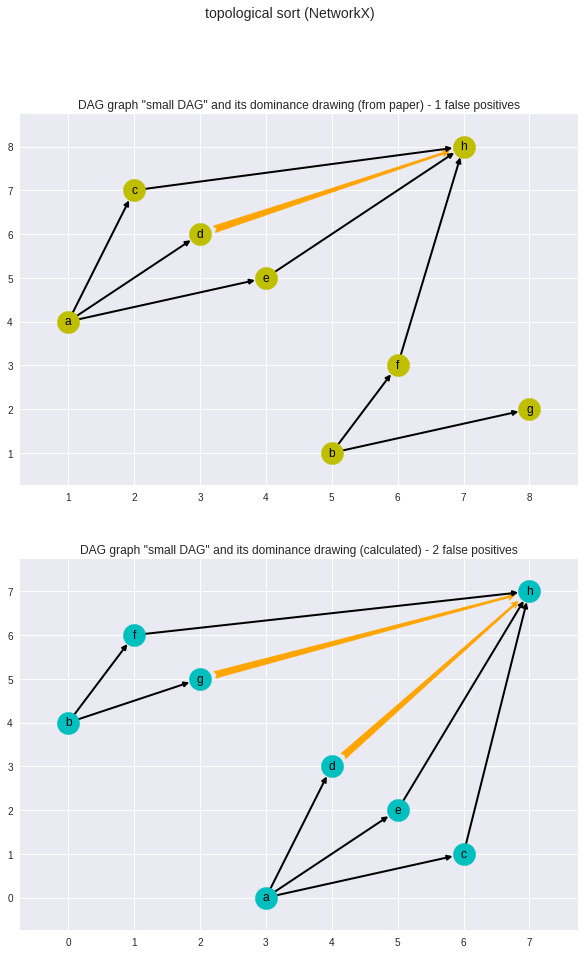

In [566]:
#@title Draw a DAG using weak dominance drawing (with FELINE)  { run: "auto" }

graph_name = 'small DAG' #@param ["crown DAG", "small DAG", "didactic", "levels DAG"]
topo_sort = 'topological sort (NetworkX)' #@param ["lexicographical topological sort (NetworkX)", "topological sort (NetworkX)"]
fig_sizex = 10 #@param {type:"slider", min:5, max:25, step:1}
fig_sizey = 15 #@param {type:"slider", min:5, max:25, step:1}
fig_square = False #@param {type:"boolean"}


graph=graphs[graph_name]

## based on https://matplotlib.org/examples/pylab_examples/subplots_demo.html
# Two subplots sharing both x/y axes
#fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
fig, (ax1, ax2) = plt.subplots(2, sharex=False, sharey=False)
fig.set_size_inches(fig_sizex,fig_sizey)
fig.suptitle(topo_sort, fontsize=14)

fp_pos=feline_fp(graph, graph.pos)
ax1.set_title('DAG graph "%s" and its dominance drawing (from paper) - %d false positives' %
              (graph_name, len(fp_pos)))
if fig_square:
  ax1.set(adjustable='box-forced', aspect='equal')
draw_fp(ax1, graph.pos, fp_pos)
nx.draw_networkx(graph,pos=graph.pos,
                 ax=ax1,
                 node_size=500,width=2.0,
                 node_color='y')

graph.fel=find_feline(graph,
                      topological_sort=topo_sort_algorithms[topo_sort])
fp_fel=feline_fp(graph, graph.fel)
ax2.set_title('DAG graph "%s" and its dominance drawing (calculated) - %d false positives' %
              (graph_name, len(fp_fel)))
if fig_square:
  ax2.set(adjustable='box-forced', aspect='equal')
draw_fp(ax2, graph.fel, fp_fel)
nx.draw_networkx(graph,
                 pos=graph.fel,
                 ax=ax2,
                 node_size=500,width=2.0,
                 node_color='c')

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
#fig.subplots_adjust(hspace=0)
#plt.setp([ax.get_xticklabels() for ax in fig.axes[:-1]], visible=False);

Here one can compare FELINE index calculated using NetworkX and the one from FELINE paper for various small DAG used in the description part of the FELINE paper.

#### Reachability queries with FELINE index

In this section there would be algorithms for FELINE's query strategy, namely:

- **Algorithm 2:** Reachable  
from page 515, section 3.3 in FELINE paper
- **Algorithm 3:** Reachable  
from page 517, section 3.4 in FELINE paper, using  
  - min-post interval filter (positive-cut) and 
  - level filter (negative cut)

In [0]:
#@title def feline_is_reachable, etc. (Algorithm 1: Reachable) { form-width: "30%" }
def is_pair_leq(a, b):
  """Whether 2d-pair a precedes pair b in dominance partial order
  
  For a = (a_x, a_y) and b = (b_x, b_y), the 'precedes or equal' partial
  order on ℕ² is defined as:  a ⪯ b  ⇔  a_x <= b_y ∧ a_y <= b_y
  
  Parameters:
  -----------
  a, b : tuple
      Two-element tuples representing position in 2D space,
      an ordered pair of numbers.
      
  Returns:
  --------
  bool
      Whether pair 'a' is less or equal (precedes or equals) pair 'b'
  """
  return ((a[0] <= b[0]) and (a[1] <= b[1]))


def naive_is_reachable(DG, u, v):
  """Whether in graph DG $v$ is reachable from $u$, naive implemenation"""
  if u == v:
    return True
  
  for w in DG.successors(u):
    if naive_is_reachable(DG, w, v):
      return True
  return False


def feline_is_reachable(DG, i, u, v):
  """Whether in graph DG $v$ is reachable from $u$, utilizing FELINE index"""
  if u == v:
    return True
  if is_pair_leq(i[u],i[v]):
    for w in DG.successors(u):
      if feline_is_reachable(DG, i, w, v):
        return True
  return False


def networkx_is_reachable(DG, u, v):
  """Wrapper around NetworkX reachability method"""
  return nx.has_path(DG,u,v)

Testing and timing of reachability queries

In [568]:
# falsely-implied path in crown DAG
DG.fel=find_feline(DG)
#%timeit naive_is_reachable(DG, 'u', 'v')
#%timeit feline_is_reachable(DG, DG.pos, 'u', 'v')
#%timeit feline_is_reachable(DG, DG.fel, 'u', 'v')
#%timeit networkx_is_reachable(DG, 'u', 'v')
print('crown DAG: %r' % DG)
print('* naive')
%time naive_is_reachable(DG, 'u', 'v')
print('* FELINE (pre-computed)')
%time feline_is_reachable(DG, DG.pos, 'u', 'v')
print('* FELINE (find_feline)')
%time feline_is_reachable(DG, DG.fel, 'u', 'v')
print('* NetworkX')
%time networkx_is_reachable(DG, 'u', 'v')

crown DAG: <networkx.classes.digraph.DiGraph object at 0x7fb0e0b57410>
* naive
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 48.9 µs
* FELINE (pre-computed)
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 22.9 µs
* FELINE (find_feline)
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 21 µs
* NetworkX
CPU times: user 1 ms, sys: 0 ns, total: 1 ms
Wall time: 79.2 µs


False

In [569]:
def is_interval_subseteq(a, b):
  """Whether one interval is subset of or equal to other interval
  
  The interval is represented by two-element list or two-element tuple
  of numbers (the former implementation is more often used).
  
  We have for a ≡ I_a = [s_a, e_a] and a ≡ I_a = [s_b, e_b]:
  
    [s_a, e_a] ⊆ [s_b, e_b]  ⇔   s_b <= s_a ∧ e_a <= e_b
    
  Parameters
  ----------
  a : list of numbers
      First interval [s_a, e_a] to compare.
      
  b : list of numbers
      Second interval [s_b, e_b] to compare.
      
  Returns
  -------
  bool
      Whether I_a ⊆ I_b
  """
  return ((b[0] <= a[0]) and (a[1] <= b[1]))


a = [0,5]
b = [1,3]
print("%r ⊆ %r: %s" % (a,b,is_interval_subseteq(a,b)))
a = [1,3]
b = [0,5]
print("%r ⊆ %r: %s" % (a,b,is_interval_subseteq(a,b)))
a = [0,3]
b = [2,5]
print("%r ⊆ %r: %s" % (a,b,is_interval_subseteq(a,b)))


[0, 5] ⊆ [1, 3]: False
[1, 3] ⊆ [0, 5]: True
[0, 3] ⊆ [2, 5]: False


In [0]:
#@title def generic_is_reachable (Algorithm 3: Reachable) { form-width: "30%" }

def generic_is_reachable(DG, u, v,
                         i=None, II=None, l=None,
                         stats=None, verbose=None):
  """Whether in graph DG $v$ is reachable from $u$, utilizing given indices
  
  Given (u, v) ∈ V², two vertices in the DAG given by the DG parameter,
  calculate r(u,v), whether vertex v is reachable from vertex u.
  
  This is Algorithm 3 from FELINE paper, translated from pseudocode to
  Python (and NetworkX).
  
  Parameters
  ----------
  G : NetworkX digraph
      Directed acyclic graph.

  u : node
      Source node.

  v : node
      Target node.
  
  i : dict or None, optional (default=None)
      A dictionary with nodes as keys and FELINE index as values
      (2d tuples / positions in weak dominance drawing of a graph).
  
  II : dict or None, optional (default=None)
      A dictionary with nodes as keys and min-post interval index as values
      (2-element lists, representing intervals).
  
  l : dict or None, optional (default=None)
      A dictionary with nodes as keys and vertex level as values
      (vertex level is also known as generation number).
  
  stats : dict or None, optional (default=None)
      A dictionary gathering statistics about calls.  Currently supported
      are:
       * 'access' key, counting the number of intermediate vertices it
         checks / accesses.
       * 'feline' key, storing list of vertices where FELINE cut off search
       * 'level' key, storing list of vertices where level index cut off
         further walk (further search)
       * 'walk' key, with list of all vertices walked, in order
         
  verbose : bool or None, optional (default=None)
      Whether to print debugging information.  If set to None (the default),
      it prints debugging information if stats parameter is set.
  
  Returns
  -------
  r(u,v) : bool
      Whether v is reachable from u
  """
  if isinstance(stats, dict):
    if verbose is None:
      verbose = True
    stats.setdefault('access', 0)
    stats.setdefault('feline', [])
    stats.setdefault('level', [])
    stats.setdefault('walk', [])
    
    stats['walk'].append(u)
    
  if u == v:
    return True
  
  # II_v ⊆ II_u (positive cut)
  if II and is_interval_subseteq(II[v], II[u]):
    if verbose:
      print('%s->%s min-post resolved %r ⊆ %r' %
            (u,v,II[u],II[v]))
    if isinstance(stats, dict):
      stats['min-post'] = u
    return True
  
  # debugging
  if verbose:
    if i and not is_pair_leq(i[u], i[v]):
      print('%s->%s FELINE cut ¬%r ≼ %r' %
            (u,v,i[u],i[v]))
    if l and not l[v] < l[u]:
      print('%s->%s level cut ¬%d < %d' %
            (u,v,l[v],l[u]))
  
  # i(u) ≼ i(v)  ∧  l_u < l_v (negative cut)
  if ((i and is_pair_leq(i[u], i[v])) or (not i)) and \
     ((l and l[v] < l[u]) or (not l)):
    # debugging
    if verbose:
      print('%s->%r' %(u,list(DG.successors(u))))
    # worst case analysis
    result=False
    for w in DG.successors(u):
      if isinstance(stats, dict):  
        stats['access'] += 1

      if generic_is_reachable(DG, w, v, i=i, II=II, l=l,
                              stats=stats, verbose=verbose):
        # average case
        #return True
        # worst case analysis
        result=True
    
    # worst case analysis
    if result:
      return True

  else:
    # negative cut, but which one
    if isinstance(stats, dict):
      if i and not is_pair_leq(i[u], i[v]):
        stats['feline'].append(u)
      if l and not l[v] < l[u]:
        stats['level'].append(u)
      
  
  return False

In [0]:
#@title def generic_is_reachable_large_v1 (Algorithm 3: Reachable) { form-width: "30%" }

def generic_is_reachable_large_v1(DG, u, v,
                                  i=None, II=None, l=None,
                                  stats=None):
  """Whether in large graph DG $v$ is reachable from $u$, utilizing given indices
  
  Given (u, v) ∈ V², two vertices in the DAG given by the DG parameter,
  calculate r(u,v), whether vertex v is reachable from vertex u.
  
  This is non-recursive version of the function, without verbose mode,
  intended for larger graphs.
  
  Parameters
  ----------
  G : NetworkX digraph
      Directed acyclic graph.

  u : node
      Source node.

  v : node
      Target node.
  
  i : dict or None, optional (default=None)
      A dictionary with nodes as keys and FELINE index as values
      (2d tuples / positions in weak dominance drawing of a graph),
      e.g. result of find_feline(DG).
  
  II : dict or None, optional (default=None)
      A dictionary with nodes as keys and min-post interval index as values
      (2-element lists, representing intervals), e.g. result of
      find_dfs_intervals().
  
  l : dict or None, optional (default=None)
      A dictionary with nodes as keys and vertex level as values
      (vertex level is also known as generation number), e.g. result of
      find_levels().
  
  stats : dict or None, optional (default=None)
      A dictionary gathering statistics about calls.  Currently supported
      are:
       * 'access' key, counting the number of intermediate vertices it
         checks / accesses.
       * 'feline-filter' key, storing nodes that FELINE index stopped seaching at
       * 'level-filter' key, storing nodes that level index stopped searching at
       * 'walk' key, storing all walked nodes
       * 'min-post' key, storing node where min-post filter found reachable
       * 'maxdepth' key, with maximum stack depth
  
  Returns
  -------
  r(u,v) : bool
      Whether v is reachable from u
  """
  # initialize stats
  if isinstance(stats, dict):
    stats['access'] = 0
    if i:
      stats['feline-filter'] = []
    if l:
      stats['level-filter'] = []
    stats['walk'] = []
    stats['maxdepth'] = 0
    stats['visited-filter'] = 0

  # iteration in place of recursion
  stack = []
  visited = set() # it somewhat duplicates stats['walk'] list
  while u is not None:
    
    # mark 'u' as visited
    visited.add(u)
    
    if isinstance(stats, dict):
      stats['walk'].append(u)
      stats['maxdepth'] = max(stats['maxdepth'], len(stack))
    
    # have we arrived at destintion?
    if u == v:
      return True
  
    # II_v ⊆ II_u (positive cut)
    if II and is_interval_subseteq(II[v], II[u]):
      if isinstance(stats, dict):
        stats['min-post'] = u
      return True
  
    # i(u) ≼ i(v)  ∧  l_v < l_u (no negative cut; note: u != v)
    if ((i and is_pair_leq(i[u], i[v])) or (not i)) and \
       ((l and l[v] < l[u]) or (not l)):
    
      # TODO: sort successors
      for w in DG.successors(u):
        if isinstance(stats, dict):  
          stats['access'] += 1

        if w not in visited:
          stack.append(w)
          # TODO: break out of loop, to have DFS
          # TODO= needs to remember which successors visited
        elif isinstance(stats, dict):
          stats['visited-filter'] += 1
    
    else:
      # negative cut, but which one
      if isinstance(stats, dict):
        if i and not is_pair_leq(i[u], i[v]):
          stats['feline-filter'].append(u)
        if l and not l[v] < l[u]:
          stats['level-filter'].append(u)
    
    # next iteration
    if stack:
      u = stack.pop()
    else:
      # return False only if there is nothing left to do
      u = None
      return False
    # end while
    
  # haven't found v
  return False


generic_is_reachable_large = generic_is_reachable_large_v1

In [0]:
#@title def generic_is_reachable_large_bfs (breadth-first walk) { form-width: "30%" }

#from Queue import Queue, PriorityQueue # queue in Python 3
from collections import deque


def reachable_positive_cut(u, v,
                           II=None,
                           stats=None):
  """Whether given indices say that $v$ is reachable from $u$
  
  Given (u, v) ∈ V², a positive cut is if index implies that
  vertex v is reachable from vertex u.
  
    test(u,v) => r(u,v)
    
  Parameters
  ----------
  u : node
      Source node.

  v : node
      Target node.
      
  II : dict or None, optional (default=None)
      A dictionary with nodes as keys and min-post interval index as values
      (2-element lists, representing intervals), e.g. result of
      find_dfs_intervals().
      
      Or a dictionary with nodes as keys and dict describing DFS-derived
      info, with keys such as 'min' and 'post' describing min-post interval,
      and 'f_min', 'f_gap' and 'p_tree' - like in PReaCH paper; e.g result
      of find_dfs_intervals_extra().
      
  stats : dict or None, optional (default=None)
      A dictionary gathering statistics about calls (positive cuts).
  
  Returns
  -------
  test(u,v) : bool
      Whether index indicates that v is reachable from u
  """
  if stats is None:
    stats = {}
  # no data to indicate that v is reachable from u
  if not II:
    return False
  
  # find_dfs_intervals() case
  if isinstance(II[u], list):
    # II_v ⊆ II_u (positive cut)
    if is_interval_subseteq(II[v], II[u]):
      stats['positive-cut'] = {
        'type': 'min-post',
        'node': u
      }
      return True
    
  # find_dfs_intervals_extra() case
  else:
    # ϕ(v) ∈ range(u)  ⇒  r(u,v)
    if II[u]['min'] <= II[v]['post'] <= II[u]['post']:
      stats['positive-cut'] = {
        'type': 'min-post(node)',
        'node': u
      }
      return True
    elif II[u]['p_tree'] is not None:
      p = II[u]['p_tree']
      # r(u,p_tree) ∧ ϕ(v) ∈ range(p_tree)  ⇒  r(u,v)
      if II[p]['min'] <= II[v]['post'] <= II[p]['post']:
        stats['positive-cut'] = {
          'type': 'min-post(p_tree)',
          'p_tree': p,
          'node': u
        }
        return True
      
  # no positive cut
  return False
        

def reachable_negative_cut(u, v,
                           i=None, II=None, l=None,
                           stats=None):
  """Whether given indices say that $v$ is not reachable from $u$
  
  Given (u, v) ∈ V², a positive cut is if index implies that
  vertex v is not reachable from vertex u.
  
    r(u,v) => test(u,v)
    
  Parameters
  ----------
  u : node
      Source node.

  v : node
      Target node.

  i : dict or None, optional (default=None)
      A dictionary with nodes as keys and FELINE index as values
      (2d tuples / positions in weak dominance drawing of a graph),
      e.g. result of find_feline(DG).

  II : dict or None, optional (default=None)
      A dictionary with nodes as keys and min-post interval index as values
      (2-element lists, representing intervals), e.g. result of
      find_dfs_intervals().
      
      Or a dictionary with nodes as keys and dict describing DFS-derived
      info, with keys such as 'min' and 'post' describing min-post interval,
      and 'f_min', 'f_gap' and 'p_tree' - like in PReaCH paper; e.g result
      of find_dfs_intervals_extra().
      
  l : dict or None, optional (default=None)
      A dictionary with nodes as keys and vertex level as values
      (vertex level is also known as generation number), e.g. result of
      find_levels().
      
  stats : dict or None, optional (default=None)
      A dictionary gathering statistics about calls (negative cuts).
  
  Returns
  -------
  test(u,v) : bool
      Whether index indicates that v is not reachable from u
  """
  if stats is None:
    stats = {}
  # find all conditions that match
  # otherwise stats would depend on check order
  result = False  # no negative cut
  
  # we can use levels filter
  if l:
    # r(u,v)    ∧ u ≠ v  ⇒  l_v < l_u, thus
    # l_u ≤ l_v ∧ u ≠ v  ⇒  ¬r(u,v)
    if l[u] < l[v]:
      stats['negative-cut']['level_lite'].append(u)
      result = True
    if u != v and l[u] <= l[v]:
      stats['negative-cut']['level_full'].append(u)
      result = True
  
  # we can use FELINE index filter ≦ ≧ ≼
  if i:
    # r(u,v)  ⇒  i(u) ≦ i(v) - vector inequality
    if not is_pair_leq(i[u], i[v]):
      stats['negative-cut']['FELINE'].append(u)
      result = True
  
  # we can use DFS numbering filter
  # from find_dfs_intervals_extended()
  if II and isinstance(II[u],dict):
    pos = II[v]['post']
    if 'f_min' in II[u] and \
       pos < II[u]['f_min']:
      stats['negative-cut']['f_min'].append(u)
      result = True
    if pos > II[u]['post']:
      stats['negative-cut']['f_max'].append(u)
      result = True
    if 'f_gap' in II[u] and \
       II[u]['f_gap'] is not None and \
       II[u]['f_gap'] < pos < II[u]['min']:
      stats['negative-cut']['f_gap'].append(u)
      result = True
  
  # no further checks
  return result


def walk_spanning(DG, u, v, II):
  """Walk spanning tree from $u$ to $v$, return path or []"""
  path = [u]
  while u != v:
    for w in DG.successors(u):
      # is it in spanning tree
      if not reachable_positive_cut(u, w, II):
        continue
      # can it reach target
      if reachable_positive_cut(w, v, II):
        u = w
        path.append(u)
        break
    else:
      # should not happen - cannot walk spanning tree to v
      return None
    
  return path
  

def generic_is_reachable_large_bfs(DG, u, v,
                                   i=None, II=None, l=None,
                                   stats=None):
  """Whether in large graph DG $v$ is reachable from $u$, utilizing given indices
  
  Given (u, v) ∈ V², two vertices in the DAG given by the DG parameter,
  calculate r(u,v), whether vertex v is reachable from vertex u.
  
  This is non-recursive version of the function, without verbose mode,
  intended for larger graphs.
  
  Parameters
  ----------
  G : NetworkX digraph
      Directed acyclic graph.

  u : node
      Source node.

  v : node
      Target node.
  
  i : dict or None, optional (default=None)
      A dictionary with nodes as keys and FELINE index as values
      (2d tuples / positions in weak dominance drawing of a graph),
      e.g. result of find_feline(DG).
  
  II : dict or None, optional (default=None)
      A dictionary with nodes as keys and min-post interval index as values
      (2-element lists, representing intervals), e.g. result of
      find_dfs_intervals().
      
      Or a dictionary with nodes as keys and dict describing DFS-derived
      info, with keys such as 'min' and 'post' describing min-post interval,
      and 'f_min', 'f_gap' and 'p_tree' - like in PReaCH paper; e.g result
      of find_dfs_intervals_extra().
  
  l : dict or None, optional (default=None)
      A dictionary with nodes as keys and vertex level as values
      (vertex level is also known as generation number), e.g. result of
      find_levels().
  
  stats : dict or None, optional (default=None)
      A dictionary gathering statistics about calls.
  
  Returns
  -------
  r(u,v) : bool
      Whether v is reachable from u
  """
  # helper function
  def calc_path(u):
    path = [u]
    u = stats['prev'][u]
    while u is not None:
      path.append(u)
      u = stats['prev'][u]
    return list(reversed(path))
  
  # initialize stats
  if stats is None:
    stats = {} # to simplify code always gather stats
  
  # gather info about negative and postive cuts
  stats['negative-cut'] = {}
  if i:
    # using FELINE index for negative cut
    stats['negative-cut']['FELINE'] = []
  if l:
    # using topological levels / generation numbers for negative cut
    stats['negative-cut']['level_lite'] = []
    stats['negative-cut']['level_full'] = []
  if II and isinstance(II[u], dict):
    # using DFS traversal data from PReaCH paper for negative cut
    stats['negative-cut']['f_max']  = []
    if 'f_min' in II[u]:
      stats['negative-cut']['f_min'] = []
    if 'f_gap' in II[u]:
      stats['negative-cut']['f_gap'] = []
  # do not visit any node twice
  stats['negative-cut']['visited'] = []
  
  # for finding length of path and path itself
  # compare Dijkstra algorithm
  stats['depth'] = {}
  stats['prev'] = {}
  
  stats['access'] = 0
  stats['walk'] = []
  stats['max_queue_size'] = 0

  # breadth-first walk in place of recursion
  #queue = Queue() # or PriorityQueue()
  queue = deque([u])
  stats['depth'][u] = 0
  stats['prev'][u] = None
  visited = set() # it somewhat duplicates stats['walk'] list
  stats['visited'] = visited
  
  while queue:
    if len(queue) > stats['max_queue_size']:
      stats['max_queue_size'] = len(queue)
    
    u = queue.popleft()
    
    # mark 'u' as visited, add to walked
    visited.add(u)
    stats['walk'].append(u)
    
    # have we arrived at destination?
    if u == v:
      stats['path'] = calc_path(u)
      stats['len'] = stats['depth'][u]
      return True
    
    # positive cut: we know that 'v' is reachable from 'u'
    # end search (in the future: find full path to 'v')
    if reachable_positive_cut(u,v,II=II,stats=stats):
      stats['path-pre']  = calc_path(u)
      stats['path-post'] = walk_spanning(DG,u,v,II=II)
      stats['len-pre']  = stats['depth'][u]
      stats['len-post'] = len(stats['path-post'])-1
      stats['path'] = stats['path-pre'][:-1] + stats['path-post']
      stats['len'] = stats['len-pre'] + stats['len-post']
      return True
    
    # negative cut: we know that 'v' is not reachable from 'u'
    # continue with next node on the list
    if reachable_negative_cut(u,v,l=l,i=i,II=II,stats=stats):
      continue
    
    # walk unvisited parents / successors if not known
    for w in DG.successors(u):
      stats['access'] += 1

      if w not in visited:
        queue.append(w)
        stats['depth'][w] = stats['depth'][u]+1
        stats['prev'][w] = u
      else:
        stats['negative-cut']['visited'].append(w)
        
  # we have exhausted search space
  return False
    

In [573]:
%%time
recalculate = True
if recalculate or not hasattr(ch, 'lvl'):
  ch.lvl = find_levels(ch) # TODO: pre-computed levels are forward levels
if recalculate or not hasattr(ch, 'fel'):
  ch.fel = find_feline(ch)
if recalculate or not hasattr(ch, 'mpi'):
  ch.mpi = find_dfs_intervals(ch)
if recalculate or not hasattr(ch, 'mpi_x'):
  ch.mpi_x = find_dfs_intervals_extra(ch)

print('%r' % ch)
for (attr,val) in ch.__dict__.items():
  if isinstance(val, dict) and not attr.startswith('_'):
    print('- %s' % attr)

- labels
- fel
- mpi_x
- pos
- mpi
- graph
- lvl
CPU times: user 2 ms, sys: 1 ms, total: 3 ms
Wall time: 2.7 ms


In [574]:
#@title test generic_is_reachable_large_bfs { form-width: "30%" }
print('crown DAG: %r' % DG)
print('- r(u,v): %r' % 
      generic_is_reachable_large_bfs(DG,'u','v',
                                     i=DG.fel,l=DG.lvl,II=DG.mpi))
print('- r(1,2): %r' %
      generic_is_reachable_large_bfs(DG, 1,  2,
                                     i=DG.fel,l=DG.lvl,II=DG.mpi))

crown DAG: <networkx.classes.digraph.DiGraph object at 0x7fb0e0b57410>
- r(u,v): False
- r(1,2): True


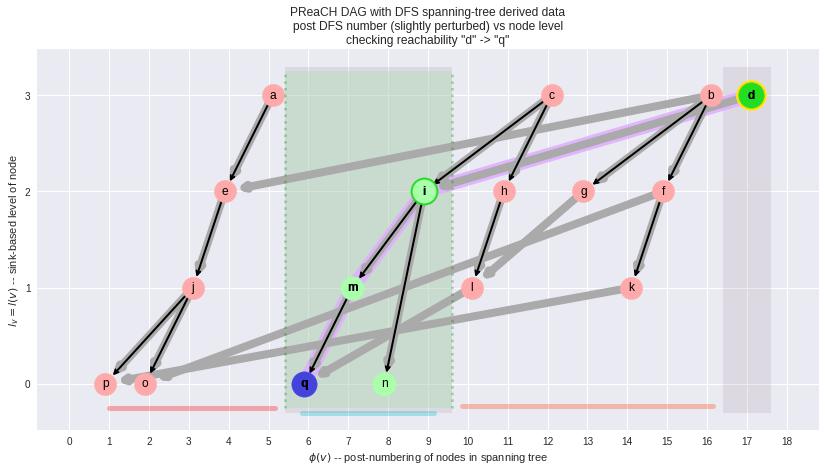

PReaCH DAG: d -> q
- 17 nodes
- r(d,q): True (NetworkX)
- r(d,q): True
{ 'access': 0,
  'depth': { 'd': 0},
  'len': 3,
  'len-post': 3,
  'len-pre': 0,
  'max_queue_size': 1,
  'negative-cut': { 'f_gap': [],
                    'f_max': [],
                    'f_min': [],
                    'level_full': [],
                    'level_lite': [],
                    'visited': []},
  'path': ['d', 'i', 'm', 'q'],
  'path-post': ['d', 'i', 'm', 'q'],
  'path-pre': ['d'],
  'positive-cut': { 'node': 'd', 'p_tree': 'i', 'type': 'min-post(p_tree)'},
  'prev': { 'd': None},
  'visited': set(['d']),
  'walk': ['d']}


In [575]:
#@title Reachability in PReaCH graph { run: "auto", form-width: "30%" }
import pprint

graph_name = 'PReaCH DAG'
node_color = "#ffaaaa" #@param ["y", "m", "c", "b", "g", "r"] {allow-input: true}

xtick_spacing = 1
ytick_spacing = 1
fig_sizex = 14
fig_sizey =  7

src = "d" #@param ["a","c","b","d","g","f","k"]
dst = "q" #@param ["p","o","q","n","l","e","i"]

fig = plt.figure()
fig.set_size_inches(fig_sizex,fig_sizey)

ax=plt.gca()

graph=ch
intervals=ch.mpi_x
lvls=ch.lvl
reachable=find_reachable(graph)

pos={v: (intervals[v]['post']+0.2*(lvls[v]%2)-0.1,
         lvls[v])
     for v in graph}
max_pos=(
  max([x for (x,y) in pos.values()]),
  max([y for (x,y) in pos.values()])
)
dd=(
  -0.30*(max_pos[0]/5.0),
  +0.14*(max_pos[1]/4.0)
)
max_level = max(lvls.values())

ax.xaxis.set_ticks(np.arange(0, max_pos[0]+1, xtick_spacing))
ax.yaxis.set_ticks(np.arange(0, max_pos[1]+2, ytick_spacing))

v = src
n_all=len(graph)

stats = {}
res = generic_is_reachable_large_bfs(ch,
                                     src,dst,
                                     l=ch.lvl,II=ch.mpi_x,
                                     stats=stats)

if True:
  if intervals[v]['p_tree'] is not None:
    p = intervals[v]['p_tree']
    vx= intervals[v]['post']
    yy=-0.3
    ax.add_line(Line2D([intervals[p]['min']-0.15,intervals[p]['post']+0.15],
                       [yy,yy],
                       lw=5., alpha=0.3, c='c'))
    ax.add_patch(Rectangle((intervals[p]['min']-0.6,-0.25),
                           intervals[p]['post']-intervals[p]['min']+1.2,
                           max_pos[1]+0.5, facecolor="#99ee99",alpha=0.3))
    ax.add_line(Line2D([intervals[p]['min']-0.6,intervals[p]['min']-0.6],
                       [-0.25,max_pos[1]+0.25],
                       linestyle='dotted',
                       lw=2.5,c='g',alpha=0.3))
    ax.add_line(Line2D([intervals[p]['post']+0.6,intervals[p]['post']+0.6],
                       [-0.25,max_pos[1]+0.25],
                       linestyle='dotted',
                       lw=2.5,c='g',alpha=0.3))
  
  if intervals[v]['post'] < n_all:
    ax.add_line(Line2D([intervals[v]['post']+1-0.15,n_all+0.15],
                       [-0.25,-0.25],
                       lw=5., alpha=0.3, c='r'))

  if intervals[v]['f_min'] > 1:
    ax.add_line(Line2D([1,intervals[v]['f_min']-1+0.15],
                       [-0.25,-0.25],
                       lw=5., alpha=0.3, c='r'))

  if lvls[dst] == 0:
    y_low = -0.30
  else:
    y_low = lvls[dst] - 0.5
  if lvls[src] == max_level:
    y_high = max_level + 0.30
  else:
    y_high = lvls[src] + 0.5
  if intervals[v]['f_gap'] is not None and \
     intervals[v]['f_gap']+1 <= intervals[v]['min']-1:
    ax.add_line(Line2D([intervals[v]['f_gap']+1-0.15,
                        intervals[v]['min']  -1+0.15],
                       [-0.23,-0.23],
                       lw=5., alpha=0.3, c='#ff4400'))
    ax.add_patch(Rectangle((intervals[v]['f_min']-0.6,y_low),
                           intervals[v]['f_gap']-intervals[v]['f_min']+1.2,
                           y_high-y_low, facecolor="#aa99aa",alpha=0.2))
    ax.add_patch(Rectangle((intervals[v]['min']  -0.6,y_low),
                           intervals[v]['post']-intervals[v]['min']+1.2,
                           y_high-y_low, facecolor="#aa99aa",alpha=0.2))
    
  else:
    ax.add_patch(Rectangle((intervals[v]['f_min']-0.6,y_low),
                           intervals[v]['post']-intervals[v]['f_min']+1.2,
                           y_high-y_low, facecolor="#aa88bb",alpha=0.2))
    
  if intervals[v]['min'] != intervals[v]['post']:
    ax.add_line(Line2D([intervals[v]['min']-0.15,intervals[v]['post']+0.15],
                       [-0.2,-0.2],
                       lw=5., alpha=0.3, c='b'))
    ax.add_patch(Rectangle((intervals[v]['min']-0.6,-0.25),
                           intervals[v]['post']-intervals[v]['min']+1.2,
                           max_pos[1]+0.5, facecolor="#99ff99",alpha=0.3))
    ax.add_line(Line2D([intervals[v]['min']-0.6,intervals[v]['min']-0.6],
                       [-0.25,max_pos[1]+0.25],
                       linestyle='dashed',
                       lw=2.5,c='g',alpha=0.3))
    ax.add_line(Line2D([intervals[v]['post']+0.6,intervals[v]['post']+0.6],
                       [-0.25,max_pos[1]+0.25],
                       linestyle='dashed',
                       lw=2.5,c='g',alpha=0.3))

  nx.draw_networkx_nodes(graph,
                         pos=pos,
                         nodelist=stats['depth'].keys(),
                         node_size=910,node_color='#ffffcc') # cream yellow
  nx.draw_networkx_nodes(graph,
                         pos=pos,
                         nodelist=stats['walk'],
                         node_size=900,node_color='#fedf00') # Yellow (Pantone)
  
  if intervals[v]['p_tree'] is not None:
    nx.draw_networkx_nodes(graph,
                           pos=pos,
                           nodelist=[p],
                           node_size=750,node_color='#22dd22')

#plt.axis('off')
plt.xlabel('$\phi(v)$ -- post-numbering of nodes in spanning tree')
plt.ylabel('$l_v = l(v)$ -- sink-based level of node')
plt.title(graph_name+' with DFS spanning-tree derived data\n'+
          'post DFS number (slightly perturbed) vs node level\n'+
          'checking reachability "'+str(src)+'" -> "'+str(dst)+'"')

# draw path, if it exists
if res:
  if 'path-pre' in stats:
    nx.draw_networkx_edges(graph,
                           pos=pos,
                           edgelist=zip(stats['path-pre'],
                                        stats['path-pre'][1:]),
                           width=16.0,edge_color='#A020F0',alpha=0.4,
                           arrowstyle='-')
    nx.draw_networkx_edges(graph,
                           pos=pos,
                           edgelist=zip(stats['path-post'],
                                        stats['path-post'][1:]),
                           width=14.0,edge_color='#E0B0FF',alpha=0.9,
                           arrowstyle='-')
  else:
    nx.draw_networkx_edges(graph,
                           pos=pos,
                           edgelist=zip(stats['path'],stats['path'][1:]),
                           width=16.0,edge_color='#f300fe',alpha=0.5,
                           arrowstyle='-')

nx.draw_networkx(graph,
                 pos=pos,
                 width=8.0,edge_color='#aaaaaa',
                 node_size=500,node_color=node_color)
nx.draw_networkx_edges(graph,
                       pos=pos,
                       edgelist=find_dfs_spanning(graph),
                       node_size=500,width=2.0,
                       arrowstyle='->')
nx.draw_networkx_nodes(graph,
                       pos=pos,
                       nodelist=reachable[src]+[src],
                       node_size=550,node_color='#aaffaa')
nx.draw_networkx_nodes(graph,
                       pos=pos,
                       nodelist=[src],
                       node_size=650,node_color='#22dd22')
nx.draw_networkx_nodes(graph,
                       pos=pos,
                       nodelist=[dst],
                       node_size=650,node_color='#4444dd')

if res:
  nx.draw_networkx_labels(graph,
                          pos=pos,
                          labels={n:n for n in stats['path']},
                          font_weight='bold')

plt.show()

print('%s: %s -> %s' % (graph_name, src, dst))
print('- %d nodes' % n_all)
print('- r(%s,%s): %r (NetworkX)' % (src, dst, nx.has_path(ch,src,dst)))

print('- r(%s,%s): %r' % (src, dst, res))
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(stats)


Test that using indices leads to accessing less nodes:

* didactic example of a DAG from Figure 6 in the FELINE paper, where FELINE index discards vertices
* example from Figure 9 in the FELINE paper, where there is false-implied path between them by FELINE index, but the *level filter* prunes the search
* example where we can use *min-post* indexing for a spanning tree extracted from the small DAG (Figure 8 in the FELINE paper) can answer reachability query without search
* example where we can use *min-post* indexing cannot answer reachability query without search

In [576]:
#@title generic_is_reachable in a didactic example of a DAG { form-width: "30%" }
stats = {}
result = generic_is_reachable(de, 'a', 'g', stats=stats)
print('r(%s,%s)=%r in %d steps (naive)\n  %r\n' %
      ('a', 'g', result, stats['access'], stats))
stats = {}
result = generic_is_reachable(de, 'a', 'g', i=de.pos, stats=stats)
print('r(%s,%s)=%r in %d steps (FELINE, pre-calculated)\n  %r' %
      ('a', 'g', result, stats['access'], stats))

a->['c', 'b', 'd']
c->['g']
b->['e', 'f']
e->[]
f->[]
d->['i', 'h']
i->[]
h->[]
r(a,g)=True in 8 steps (naive)
  {'access': 8, 'feline': [], 'walk': ['a', 'c', 'g', 'b', 'e', 'f', 'd', 'i', 'h'], 'level': []}

a->['c', 'b', 'd']
c->['g']
b->g FELINE cut ¬(1, 6) ≼ (5, 5)
d->g FELINE cut ¬(6, 1) ≼ (5, 5)
r(a,g)=True in 4 steps (FELINE, pre-calculated)
  {'access': 4, 'feline': ['b', 'd'], 'walk': ['a', 'c', 'g', 'b', 'd'], 'level': []}


In [577]:
stats = {}
result = generic_is_reachable_large(de, 'a', 'g', stats=stats)
print('r(%s,%s)=%r in %d steps (naive)\n  %r' %
      ('a', 'g', result, stats['access'], stats))
stats = {}
result = generic_is_reachable_large(de, 'a', 'g', i=de.pos, stats=stats)
print('r(%s,%s)=%r in %d steps (FELINE, pre-calculated)\n  %r' %
      ('a', 'g', result, stats['access'], stats))

r(a,g)=True in 8 steps (naive)
  {'access': 8, 'visited-filter': 0, 'maxdepth': 3, 'walk': ['a', 'd', 'h', 'i', 'b', 'f', 'e', 'c', 'g']}
r(a,g)=True in 4 steps (FELINE, pre-calculated)
  {'access': 4, 'visited-filter': 0, 'maxdepth': 2, 'feline-filter': ['d', 'b'], 'walk': ['a', 'd', 'b', 'c', 'g']}


In [578]:
if not hasattr(de, 'lvl'):
  print('find_levels(de)\n')
  de.lvl=find_levels(de)

stats = {}
result = generic_is_reachable(de, 'a', 'c', stats=stats)
print('r(%s,%s)=%r in %d steps (naive)\n' %
      ('a', 'c', result, stats['access']))
stats = {}
result = generic_is_reachable(de, 'a', 'c', l=de.lvl, stats=stats)
print('r(%s,%s)=%r in %d steps (levels)\n  %r\n' %
      ('a', 'c', result, stats['access'], stats))
stats = {}
result = generic_is_reachable(de, 'a', 'c', i=de.pos, stats=stats)
print('r(%s,%s)=%r in %d steps (FELINE, pre-calculated)\n  %r' %
      ('a', 'c', result, stats['access'], stats))

find_levels(de)

a->['c', 'b', 'd']
b->['e', 'f']
e->[]
f->[]
d->['i', 'h']
i->[]
h->[]
r(a,c)=True in 7 steps (naive)

a->['c', 'b', 'd']
b->c level cut ¬1 < 1
d->c level cut ¬1 < 1
r(a,c)=True in 3 steps (levels)
  {'access': 3, 'feline': [], 'walk': ['a', 'c', 'b', 'd'], 'level': ['b', 'd']}

a->['c', 'b', 'd']
b->c FELINE cut ¬(1, 6) ≼ (4, 4)
d->c FELINE cut ¬(6, 1) ≼ (4, 4)
r(a,c)=True in 3 steps (FELINE, pre-calculated)
  {'access': 3, 'feline': ['b', 'd'], 'walk': ['a', 'c', 'b', 'd'], 'level': []}


In [579]:
stats = {}
result = generic_is_reachable_large(de, 'a', 'c', stats=stats)
print('r(%s,%s)=%r in %d steps (naive)\n  %r' %
      ('a', 'c', result, stats['access'], stats))
stats = {}
result = generic_is_reachable_large(de, 'a', 'c', l=de.lvl, stats=stats)
print('r(%s,%s)=%r in %d steps (levels)\n  %r' %
      ('a', 'c', result, stats['access'], stats))
stats = {}
result = generic_is_reachable_large(de, 'a', 'c', i=de.pos, stats=stats)
print('r(%s,%s)=%r in %d steps (FELINE, pre-calculated)\n  %r' %
      ('a', 'c', result, stats['access'], stats))

r(a,c)=True in 7 steps (naive)
  {'access': 7, 'visited-filter': 0, 'maxdepth': 3, 'walk': ['a', 'd', 'h', 'i', 'b', 'f', 'e', 'c']}
r(a,c)=True in 3 steps (levels)
  {'access': 3, 'visited-filter': 0, 'maxdepth': 2, 'level-filter': ['d', 'b'], 'walk': ['a', 'd', 'b', 'c']}
r(a,c)=True in 3 steps (FELINE, pre-calculated)
  {'access': 3, 'visited-filter': 0, 'maxdepth': 2, 'feline-filter': ['d', 'b'], 'walk': ['a', 'd', 'b', 'c']}


In [580]:
#@title generic_is_reachable in a level-filter example { form-width: "30%" }
print('Level filter example (Figure 9 in FELINE paper)\n')

graph=lf
u='e'
v='g'
stats = {}
result = generic_is_reachable(graph, u, v, stats=stats)
print('r(%s,%s)=%r in %d steps (naive)\n' %
      (u, v, result, stats['access']))
stats = {}
result = generic_is_reachable(graph, u, v, i=graph.pos, stats=stats)
print('r(%s,%s)=%r in %d steps (FELINE, pre-calculated)\n' %
      (u, v, result, stats['access']))
stats = {}
result = generic_is_reachable(graph, u, v, l=graph.lvl, stats=stats)
print('r(%s,%s)=%r in %d steps (levels, pre-calculated)\n' %
      (u, v, result, stats['access']))
stats = {}
result = generic_is_reachable(graph, u, v, i=graph.pos, l=graph.lvl, stats=stats)
print('r(%s,%s)=%r in %d steps (FELINE+levels, pre-calculated)\n  %r' %
      (u, v, result, stats['access'], stats))


Level filter example (Figure 9 in FELINE paper)

e->['h']
h->[]
r(e,g)=False in 1 steps (naive)

e->['h']
h->[]
r(e,g)=False in 1 steps (FELINE, pre-calculated)

e->['h']
h->g level cut ¬0 < 0
r(e,g)=False in 1 steps (levels, pre-calculated)

e->['h']
h->g level cut ¬0 < 0
r(e,g)=False in 1 steps (FELINE+levels, pre-calculated)
  {'access': 1, 'feline': [], 'walk': ['e', 'h'], 'level': ['h']}


In [581]:
graph=lf
u='e'
v='g'
stats = {}
result = generic_is_reachable_large(graph, u, v, stats=stats)
print('r(%s,%s)=%r in %d steps (naive)\n  %r' %
      (u, v, result, stats['access'], stats))
stats = {}
result = generic_is_reachable_large(graph, u, v, i=graph.pos, stats=stats)
print('r(%s,%s)=%r in %d steps (FELINE, pre-calculated)\n  %r' %
      (u, v, result, stats['access'], stats))
stats = {}
result = generic_is_reachable_large(graph, u, v, l=graph.lvl, stats=stats)
print('r(%s,%s)=%r in %d steps (levels, pre-calculated)\n  %r' %
      (u, v, result, stats['access'], stats))
stats = {}
result = generic_is_reachable_large(graph, u, v, i=graph.pos, l=graph.lvl, stats=stats)
print('r(%s,%s)=%r in %d steps (FELINE+levels, pre-calculated)\n  %r' %
      (u, v, result, stats['access'], stats))

r(e,g)=False in 1 steps (naive)
  {'access': 1, 'visited-filter': 0, 'maxdepth': 0, 'walk': ['e', 'h']}
r(e,g)=False in 1 steps (FELINE, pre-calculated)
  {'access': 1, 'visited-filter': 0, 'maxdepth': 0, 'feline-filter': [], 'walk': ['e', 'h']}
r(e,g)=False in 1 steps (levels, pre-calculated)
  {'access': 1, 'visited-filter': 0, 'maxdepth': 0, 'level-filter': ['h'], 'walk': ['e', 'h']}
r(e,g)=False in 1 steps (FELINE+levels, pre-calculated)
  {'visited-filter': 0, 'level-filter': ['h'], 'walk': ['e', 'h'], 'access': 1, 'maxdepth': 0, 'feline-filter': []}


In [582]:
graph=lf
for (u,v) in [('a','h'), ('b','h')]:
  print('r(%s,%s) ###################################\n' % (u,v))
  stats = {}
  result = generic_is_reachable_large(graph, u, v, stats=stats)
  print('r(%s,%s)=%r in %d steps (naive)\n  %r' %
        (u, v, result, stats['access'], stats))

  stats = {}
  result = generic_is_reachable_large(graph, u, v, l=graph.lvl, stats=stats)
  print('r(%s,%s)=%r in %d steps (levels, pre-calculated)\n  %r' %
        (u, v, result, stats['access'], stats))

  stats = {}
  result = generic_is_reachable_large(graph, u, v, i=graph.pos, stats=stats)
  print('r(%s,%s)=%r in %d steps (FELINE, pre-calculated)\n  %r' %
      (u, v, result, stats['access'], stats))

  stats = {}
  result = generic_is_reachable_large(graph, u, v, i=graph.pos, l=graph.lvl, stats=stats)
  print('r(%s,%s)=%r in %d steps (FELINE+level, pre-calculated)\n  %r\n' %
        (u, v, result, stats['access'], stats))

r(a,h) ###################################

r(a,h)=True in 5 steps (naive)
  {'access': 5, 'visited-filter': 0, 'maxdepth': 2, 'walk': ['a', 'd', 'g', 'e', 'h']}
r(a,h)=True in 5 steps (levels, pre-calculated)
  {'access': 5, 'visited-filter': 0, 'maxdepth': 2, 'level-filter': ['g'], 'walk': ['a', 'd', 'g', 'e', 'h']}
r(a,h)=True in 4 steps (FELINE, pre-calculated)
  {'access': 4, 'visited-filter': 0, 'maxdepth': 2, 'feline-filter': ['d'], 'walk': ['a', 'd', 'e', 'h']}
r(a,h)=True in 4 steps (FELINE+level, pre-calculated)
  {'visited-filter': 0, 'level-filter': [], 'walk': ['a', 'd', 'e', 'h'], 'access': 4, 'maxdepth': 2, 'feline-filter': ['d']}

r(b,h) ###################################

r(b,h)=False in 3 steps (naive)
  {'access': 3, 'visited-filter': 0, 'maxdepth': 1, 'walk': ['b', 'f', 'g', 'i']}
r(b,h)=False in 3 steps (levels, pre-calculated)
  {'access': 3, 'visited-filter': 0, 'maxdepth': 1, 'level-filter': ['g', 'i'], 'walk': ['b', 'f', 'g', 'i']}
r(b,h)=False in 0 steps (FEL

In [583]:
#@title generic_is_reachable in a small DAG, with min-post intervals { form-width: "30%" }
print('Min-post interval filter example (Figure 8 in FELINE paper)\n')

u='a'
v='h'
print('r(%s,%s) ###################################\n' % (u,v))
stats = {}
result = generic_is_reachable(sd, u, v, stats=stats)
print('r(%s,%s)=%r in %d steps (naive)\n' %
      (u, v, result, stats['access']))
stats = {}
result = generic_is_reachable(sd, u, v, i=sd.pos, II=sd.mpi, stats=stats)
print('r(%s,%s)=%r in %d steps (FELINE+min-post, pre-calculated)\n  %r\n' %
      (u, v, result, stats['access'], stats))

u='b'
v='h'
print('r(%s,%s) ###################################\n' % (u,v))
stats = {}
result = generic_is_reachable(sd, u, v, stats=stats)
print('r(%s,%s)=%r in %d steps (naive)\n  %r\n' %
      (u, v, result, stats['access'], stats))
stats = {}
result = generic_is_reachable(sd, u, v, i=sd.pos, II=sd.mpi, stats=stats)
print('r(%s,%s)=%r in %d steps (FELINE+min-post, pre-calculated)\n  %r' %
      (u, v, result, stats['access'], stats))

Min-post interval filter example (Figure 8 in FELINE paper)

r(a,h) ###################################

a->['c', 'e', 'd']
c->['h']
e->['h']
d->[]
r(a,h)=True in 5 steps (naive)

a->h min-post resolved (1, 5) ⊆ (3, 3)
r(a,h)=True in 0 steps (FELINE+min-post, pre-calculated)
  {'access': 0, 'min-post': 'a', 'feline': [], 'walk': ['a'], 'level': []}

r(b,h) ###################################

b->['g', 'f']
g->[]
f->['h']
r(b,h)=True in 3 steps (naive)
  {'access': 3, 'feline': [], 'walk': ['b', 'g', 'f', 'h'], 'level': []}

b->['g', 'f']
g->h FELINE cut ¬(8, 2) ≼ (7, 8)
f->['h']
r(b,h)=True in 3 steps (FELINE+min-post, pre-calculated)
  {'access': 3, 'feline': ['g'], 'walk': ['b', 'g', 'f', 'h'], 'level': []}


In [584]:
u='a'
v='h'
print('r(%s,%s) ###################################\n' % (u,v))
stats = {}
result = generic_is_reachable_large(sd, u, v, stats=stats)
print('r(%s,%s)=%r in %d steps (naive)\n  %r' %
      (u, v, result, stats['access'], stats))
stats = {}
result = generic_is_reachable_large(sd, u, v, i=sd.pos, II=sd.mpi, stats=stats)
print('r(%s,%s)=%r in %d steps (FELINE+min-post, pre-calculated)\n  %r\n' %
      (u, v, result, stats['access'], stats))

u='b'
v='h'
print('r(%s,%s) ###################################\n' % (u,v))
stats = {}
result = generic_is_reachable_large(sd, u, v, stats=stats)
print('r(%s,%s)=%r in %d steps (naive)\n  %r' %
      (u, v, result, stats['access'], stats))
stats = {}
result = generic_is_reachable_large(sd, u, v, i=sd.pos, II=sd.mpi, stats=stats)
print('r(%s,%s)=%r in %d steps (FELINE+min-post, pre-calculated)\n  %r' %
      (u, v, result, stats['access'], stats))

r(a,h) ###################################

r(a,h)=True in 4 steps (naive)
  {'access': 4, 'visited-filter': 0, 'maxdepth': 2, 'walk': ['a', 'd', 'e', 'h']}
r(a,h)=True in 0 steps (FELINE+min-post, pre-calculated)
  {'visited-filter': 0, 'min-post': 'a', 'access': 0, 'maxdepth': 0, 'walk': ['a'], 'feline-filter': []}

r(b,h) ###################################

r(b,h)=True in 3 steps (naive)
  {'access': 3, 'visited-filter': 0, 'maxdepth': 1, 'walk': ['b', 'f', 'h']}
r(b,h)=True in 3 steps (FELINE+min-post, pre-calculated)
  {'access': 3, 'visited-filter': 0, 'maxdepth': 1, 'feline-filter': [], 'walk': ['b', 'f', 'h']}


#### Reachability query stats for sample

Given sample of $(u,v) \in V^2$ pairs and some "is reachable" query, gather statistics about processing reachability query, like e.g. number of nodes walked.

In [585]:
#@title TODO: def sample_queries { form-width: "25%" }

import itertools

graph = ch
srclist = ['a','c','b','d','g','f','k']
dstlist = ['p','o','q','n','l','e','i']

stats_x = {}

for (src,dst) in itertools.product(srclist,dstlist):
  stats_x[(src,dst)] = {}
  result = generic_is_reachable_large_bfs(graph, src, dst,
                                          l=graph.lvl, II=graph.mpi_x,
                                          i=graph.fel,
                                          stats=stats_x[(src,dst)])
  stats_x[(src,dst)]['result'] = result
  stats_x[(src,dst)]['has_path'] = nx.has_path(graph, src, dst)

stats_items = []
stats_columns = ['res','path','access','maxdepth','maxqueue',
                 'walk','len','len-pre',
                 'visited','lvl_lite','lvl_full',
                 'f_max','f_rest','p_tree','FEL','FEL/max','pos-cut']
for t in sorted(stats_x, key=lambda k: stats_x[k]['access']):
  stats_items_values = []
  for st in ['result','has_path','access']:
    stats_items_values.append(stats_x[t][st])
  stats_items_values.append(max(stats_x[t]['depth'].values()))
  for st in ['max_queue_size']:
    stats_items_values.append(stats_x[t][st])
  for st in ['walk']:
    stats_items_values.append(len(stats_x[t][st]))
  for st in ['len','len-pre']:
    if st in stats_x[t]:
      stats_items_values.append(stats_x[t][st])
    else:
      #stats_items_values.append(np.nan)
      stats_items_values.append(None)
      
  if 'negative-cut' in stats_x[t]:
    if 'visited' in stats_x[t]['negative-cut']:
      stats_items_values.append(len(stats_x[t]['negative-cut']['visited']))
    else:
      stats_items_values.append(np.nan)
    if 'level_full' in stats_x[t]['negative-cut']:
      stats_items_values.extend([
        len(stats_x[t]['negative-cut']['level_lite']),
        len(stats_x[t]['negative-cut']['level_full']),
      ])
    else:
      stats_items_values.extend([np.nan,np.nan])
    if 'f_max' in stats_x[t]['negative-cut']:
      stats_items_values.append(len(stats_x[t]['negative-cut']['f_max']))
    else:
      stats_items_values.append(np.nan)
    if 'f_min' in stats_x[t]['negative-cut']:
      stats_items_values.append(len(
            (set(stats_x[t]['negative-cut']['f_min']) |
             set(stats_x[t]['negative-cut']['f_gap']))
            -
            set(stats_x[t]['negative-cut']['f_max'])
      ))
      if 'positive-cut' in stats_x[t] and \
         'p_tree' in stats_x[t]['positive-cut']:
        stats_items_values.append(stats_x[t]['positive-cut']['p_tree'])
      else:
        stats_items_values.append(None)
    else:
      stats_items_values.extend([np.nan,np.nan])
    if 'FELINE' in stats_x[t]['negative-cut']:
      stats_items_values.append(len(stats_x[t]['negative-cut']['FELINE']))
      if 'f_max' in stats_x[t]['negative-cut']:
        stats_items_values.append(len(
            set(stats_x[t]['negative-cut']['FELINE']) -
            set(stats_x[t]['negative-cut']['f_max'])))
      else:
        stats_items_values.append(np.nan)
    else:
      stats_items_values.extend([np.nan,np.nan])
      
  else:
    stats_items_values.extend([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
  
  if 'positive-cut' in stats_x[t]:
    stats_items_values.append(True)
  else:
    stats_items_values.append(False)
  
  stats_items.append((t, stats_items_values))                         

# .astype({col: 'int64' for col in stats_columns[2:]})
stats_df = pd.DataFrame.from_items(stats_items,orient='index',
                                   columns=stats_columns)\
                       .sort_values('access', ascending=False)
#pp.pprint(stats_x)
stats_df.head()

,res,path,access,maxdepth,maxqueue,walk,len,len-pre,visited,lvl_lite,lvl_full,f_max,f_rest,p_tree,FEL,FEL/max,pos-cut
"(b, q)",True,True,4,2,3,5,3.0,2.0,0,0,0,1,1,q,1,0,True
"(b, n)",False,False,4,2,3,5,NaN,NaN,0,0,0,1,2,None,1,0,False
"(b, i)",False,False,3,1,3,4,NaN,NaN,0,0,3,1,1,None,1,0,False
"(b, l)",True,True,3,1,3,3,2.0,1.0,0,0,0,1,0,l,1,0,True
"(f, p)",True,True,2,1,2,2,2.0,1.0,0,0,0,0,0,p,0,0,True


In [586]:
#@title reachability queries for PReaCH graph { form-width: "25%" }
stats_df.describe()

,access,maxdepth,maxqueue,walk,len,len-pre,visited,lvl_lite,lvl_full,f_max,f_rest,FEL,FEL/max
count,49.000000,49.000000,49.000000,49.000000,20.000000,20.00000,49.0,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,0.367347,0.183673,1.183673,1.326531,2.000000,0.25000,0.0,0.040816,0.204082,0.163265,0.530612,0.367347,0.204082
std,1.014353,0.486204,0.565445,0.944011,0.858395,0.55012,0.0,0.199915,0.539274,0.373438,0.543984,0.487078,0.407206
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,1.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,1.000000,2.000000,0.00000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,3.000000,0.00000,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,4.000000,2.000000,3.000000,5.000000,3.000000,2.00000,0.0,1.000000,3.000000,1.000000,2.000000,1.000000,1.000000


In [587]:
print('positive queries: u can reach v:')
stats_df[stats_df['res']]['res'].sum()

positive queries: u can reach v:


20

#### Weak dominance drawing (and related drawing algorithms)

In [0]:
#@title def draw_dominance { form-width: "25%" }
def draw_dominance(graph,title=None,
                   draw_false_positives=False,square=False,
                   with_labels=True,
                   ax=None,node_color='y',node_size=500,edge_width=2.0):
  """Draw graph using weak dominance drawing with FELINE index
  
  The FELINE index, where every vertex in the DAG is associated with a pair
  (x,y) ∈ ℕ² can be represented graphically; each such pair is understood
  as 2D coordinates in the Cartesian plane.  This function uses this
  representation to draw given graph.
  
  TODO: using colormap to show level index value.
  TODO: modify false-positives marker width to match edges width.
  TODO: configure false-positives marker color.
  
  Parameters
  ----------
  graph : NetworkX graph
      Graph to draw.  If the graph has 'pos' attribute, or 'fel' attribute,
      its values are used as positions of vertices.  Otherwise `find_feline()`
      is used to calculate FELINE index and store it in 'fel' attribute
      of the graph.
      
  title : str, optional
      Title of the plot, shown above the drawn graph.
      
  draw_false_positives : bool (optional, default: False)
      Whether to draw arrows showing false positives, that is paths 
      falsely-implied by FELINE index.
      
      NOTE: currently not configurable wrt. color or arrow width/size.
      
  square : bool (optional, default: False)
      Whether to enforce square aspect ratio of the plot.
      
  with_labels : bool (optional, default: True)
      Set to True to draw labels on the nodes.  Not recommended for larger
      graphs.
      
  ax : Matplotlib Axes object, optional
       Draw the graph in the specified Matplotlib axes.
       
  node_color : color string (optional, default: 'y')
       Node color. Can be a single color format string,
       or may be a sequence of colors with the same length as nodelist.
       See matplotlib.scatter for more details.
       
  node_size : number (optional, default=500)
       Size of nodes.
       If an array is specified it must be the same length as nodelist.
       You are recommended to set it to sufficiently small value for
       large graphs.
       
  edge_width : float (optional, default: 2.0)
       Line width of edges.  You are recommended to set it to smaller value
       for large graphs.
  """
  try:
    pos=graph.pos
  except AttributeError:
    try:
      pos=graph.fel
    except AttributeError:
      graph.fel=find_feline(graph)
      pos=graph.fel
  
  if ax is None:
    ax=plt.gca()
  
  if title is not None:
    ax.set_title(title)
  
  if draw_false_positives:
    fp_pos=feline_fp(graph, pos)
    draw_fp(ax, pos, fp_pos)
    
  if square:
    ax.set(adjustable='box-forced', aspect='equal')

  nx.draw_networkx(graph,
                   pos=pos,
                   ax=ax,
                   with_labels=with_labels,
                   node_size=node_size,width=edge_width,
                   node_color=node_color)

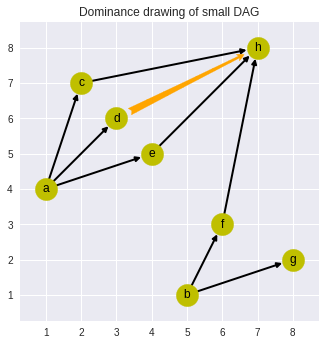

In [589]:
#@title test draw_dominance { run: "auto", form-width: "30%", display-mode: "form" }

graph_name = 'small DAG' #@param ["crown DAG", "small DAG", "didactic", "levels DAG"]
fig_false_positives = True #@param {type:"boolean"}
fig_square = True #@param {type:"boolean"}

graph=graphs[graph_name]

plt.title('Dominance drawing of '+graph_name)
draw_dominance(graph,
               draw_false_positives=fig_false_positives,
               square=fig_square)

#### TODO: Reverse FELINE index

In section _"4.3.3  FELINE-B Approach"_ (page 518) in FELINE paper, authors point out that in many graphs, the out-degrees and in-degrees follow different distribution.  They have examined FELINE index for reversed graph (with reversed edges) $G^T$, and noticed that they present different placements.

Obviously the query $r(u,v)$ in the DAG $G$ is equivalent to the $r(v,u)$ in the reversed DAG $G^T$, but as the vertices have different coordinates in each index, each one performs different to the same query.

## Version control graphs

In this section we will test how well FELINE index (and other things) help with version-control graphs, mainly with commit graphs in Git.

In [590]:
# http://gitpython.readthedocs.io/en/stable/intro.html#installing-gitpython
!pip install -q gitpython
import git

print git.__version__
git

2.1.9


<module 'git' from '/usr/local/lib/python2.7/dist-packages/git/__init__.pyc'>

The above ensures that [GitPython][] is installed.  This is one of ways to access Git repositories in Python, besides [pygit2][] and running and parsing git commands output.

[GitPython]: http://gitpython.readthedocs.io/en/stable/index.html "GitPython Documentation"
[pygit2]: http://www.pygit2.org/index.html "pygit2 documentation"

In [591]:
!git --version

git version 2.14.1


### git.git commit graph

In [592]:
%%time
!git clone -q https://github.com/git/git.git

fatal: destination path 'git' already exists and is not an empty directory.
CPU times: user 3 ms, sys: 9 ms, total: 12 ms
Wall time: 1.21 s


Time to clone `git.git` repository is counted in tens of seconds (around 20-30 s).

In [593]:
# get that repo to GitPython
repo = git.Repo('git')
repo

<git.Repo "/content/git/.git">

In [594]:
# use GitPython's git.Repo() to create graph of commits
# (limited to first 50 commits)
count = 0
for commit in repo.iter_commits(all=True, max_count=50):
  count += 1
  if count < 10:
    print(commit.hexsha)
    
print('\ncount:')
print(count)
!git -C git rev-list -50 --all | wc -l

75df6e6af6302e1b171a2e31a5d735b730e8a8d1
2c687f8fa1aa9c613a98e26bda517f87e63ed9a2
1ff845af15fe1149852691dd633a788bdc34becd
dbea1b27cc202973f684c2cf8cd51bcd5b9ecd37
704ccbe6f857643dd7e7f257423f42b9a8b1f59c
2b4f835970b9ed309d6fc0b0e765de6afb57f46e
0aa05b2ecc33e06995aadcd2471b1f36a4a75706
318c83441b112dfded7d0c71105794ae457a4ab2
3b5b96fae5fe812d3f1d369d7596f3a2c1dc705b

count:
50
50


In [595]:
# progress bar for Python
!pip install -q tqdm
from tqdm import tqdm
tqdm

# Google Colaboratory is incompatible with IPyWidgets
# https://stackoverflow.com/questions/47269168/ipywidgets-with-google-colaboratory
#!pip install -q ipywidgets
#from tqdm import tqdm, tnrange, tqdm_notebook
#from ipywidgets import IntProgress

tqdm._tqdm.tqdm

In [596]:
# create commit graph out of git command output
!git -C git log --format="%h %p" -10 --topo-order
!git -C git log --format="%h %p" -20 --topo-order >git-commit_list

1f1cddd55 cac7a2ba7
cac7a2ba7 bedb10c78 065feab4e
065feab4e 96c47d146
96c47d146 7dc0656e2
7dc0656e2 90bbd502d
bedb10c78 89e5aa3df 92a5dbbc2
92a5dbbc2 468165c1d
89e5aa3df 02645318f 11bc058ce
11bc058ce fc1395f4a
fc1395f4a e5e5e0883


In [597]:
# preliminary calculations for creating git.git commit graph
n_commits = 0
n_edges = 0
max_parents = 0

lines = [line.rstrip('\n') for line in open('git-commit_list')]
edges = []
for line in tqdm(lines):
  elems = line.split()
  commit, parents = (elems[0], elems[1:])
  n_commits += 1
  max_parents = max(max_parents, len(parents))
  for parent in parents:
    edges.append((commit, parent))
    n_edges += 1 

print('\n') # progress bar from tqdm
print('%d lines in "%s" file' % (len(lines), 'git-commit_list'))
print('commits = %d; edges = %d; max_parents = %d' % (n_commits, n_edges, max_parents))
print('edges=%r' % edges)

100%|██████████| 20/20 [00:00<00:00, 6279.37it/s]



20 lines in "git-commit_list" file
commits = 20; edges = 26; max_parents = 2
edges=[('1f1cddd55', 'cac7a2ba7'), ('cac7a2ba7', 'bedb10c78'), ('cac7a2ba7', '065feab4e'), ('065feab4e', '96c47d146'), ('96c47d146', '7dc0656e2'), ('7dc0656e2', '90bbd502d'), ('bedb10c78', '89e5aa3df'), ('bedb10c78', '92a5dbbc2'), ('92a5dbbc2', '468165c1d'), ('89e5aa3df', '02645318f'), ('89e5aa3df', '11bc058ce'), ('11bc058ce', 'fc1395f4a'), ('fc1395f4a', 'e5e5e0883'), ('e5e5e0883', 'd807c4a01'), ('d807c4a01', 'e233bef43'), ('e233bef43', 'fa2656f1d'), ('fa2656f1d', '8b026edac'), ('02645318f', '7a79d7e9f'), ('02645318f', '297e685cb'), ('297e685cb', '8796b307e'), ('8796b307e', '2e3efd061'), ('7a79d7e9f', 'beed7e22f'), ('7a79d7e9f', 'ca598d5f2'), ('ca598d5f2', '8b026edac'), ('beed7e22f', '3a940e90d'), ('beed7e22f', 'd8579accf')]


In [598]:
#%%prun
#repo_graph = nx.DiGraph()
#repo_graph.clear()
#print('nodes in graph: %d (clear)' % repo_graph.number_of_nodes())

#with tqdm(total=count,desc='commits') as pbar:
#  for commit in repo.iter_commits(all=True, max_count=50):
#    commit += 1
#    for parent in commit.iter_parents():
#      edges += 1
#      repo_graph.add_edge(commit.hexsha, parent.hexsha)
#    pbar.update(1)

print('create commit graph out of "edges" list, from "%s" file:' % 'git-commit_list')
%time repo_graph=nx.DiGraph(edges)

print('\n\nnodes in graph: %d' % repo_graph.number_of_nodes())
print('edges in graph: %d (graph size)' % repo_graph.size())
print('commits = %d; edges = %d' % (n_commits, n_edges))
print('graph: %r' % repo_graph)

create commit graph out of "edges" list, from "git-commit_list" file:
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 451 µs


nodes in graph: 26
edges in graph: 26 (graph size)
commits = 20; edges = 26
graph: <networkx.classes.digraph.DiGraph object at 0x7fb0d7f61750>


Note that the graph would have more than 20 nodes, because it includes parents of each of 20 commits.  
Time to create 20+ commit graph is around 200 microseconds.

#### Draw fragment of git.git commit graph

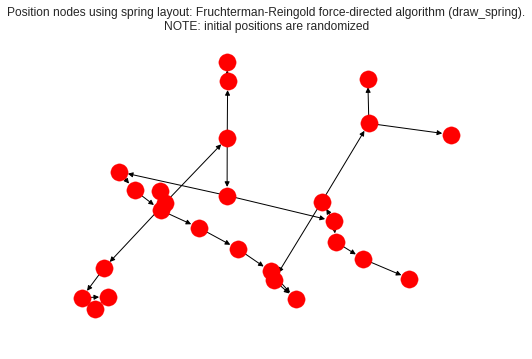

In [599]:
plt.title('Position nodes using spring layout: '+
          'Fruchterman-Reingold force-directed algorithm (draw_spring).\n'+
          'NOTE: initial positions are randomized')
nx.draw_spring(repo_graph)

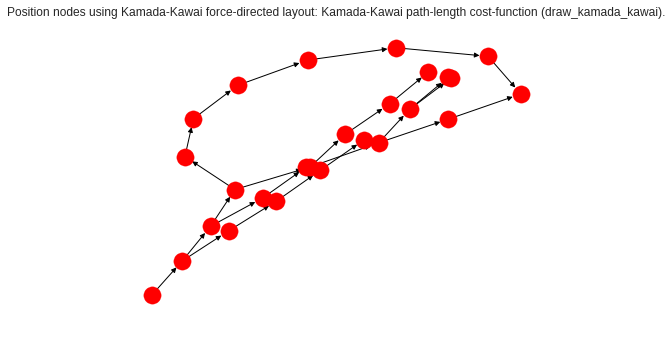

In [600]:
plt.title('Position nodes using Kamada-Kawai force-directed layout: '+
          'Kamada-Kawai path-length cost-function (draw_kamada_kawai).')
nx.draw_kamada_kawai(repo_graph)

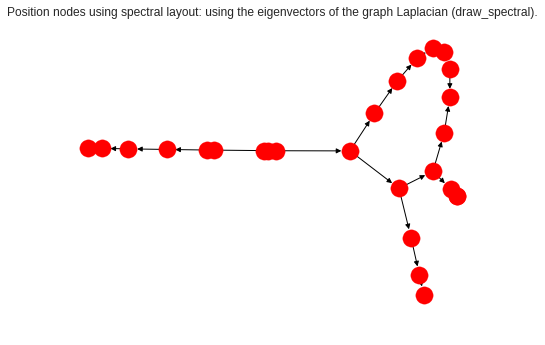

In [601]:
plt.title('Position nodes using spectral layout: '+
          'using the eigenvectors of the graph Laplacian (draw_spectral).')
nx.draw_spectral(repo_graph)

In [602]:
# git own's textual graphing
!git -C git log --graph --color=never --decorate --format="%h: %p" -20

* 1f1cddd55: cac7a2ba7
*   cac7a2ba7: bedb10c78 065feab4e
|\  
| * 065feab4e: 96c47d146
| * 96c47d146: 7dc0656e2
| * 7dc0656e2: 90bbd502d
* |   bedb10c78: 89e5aa3df 92a5dbbc2
|\ \  
| * | 92a5dbbc2: 468165c1d
* | |   89e5aa3df: 02645318f 11bc058ce
|\ \ \  
| * | | 11bc058ce: fc1395f4a
| * | | fc1395f4a: e5e5e0883
| * | | e5e5e0883: d807c4a01
| * | | d807c4a01: e233bef43
| * | | e233bef43: fa2656f1d
| * | | fa2656f1d: 8b026edac
* | | |   02645318f: 7a79d7e9f 297e685cb
|\ \ \ \  
| * | | | 297e685cb: 8796b307e
| * | | | 8796b307e: 2e3efd061
* | | | |   7a79d7e9f: beed7e22f ca598d5f2
|\ \ \ \ \  
| * | | | | ca598d5f2: 8b026edac
| | |/ / /  
| |/| | |   
* | | | |   beed7e22f: 3a940e90d d8579accf
|\ \ \ \ \  


In [603]:
!cat git-commit_list

1f1cddd55 cac7a2ba7
cac7a2ba7 bedb10c78 065feab4e
065feab4e 96c47d146
96c47d146 7dc0656e2
7dc0656e2 90bbd502d
bedb10c78 89e5aa3df 92a5dbbc2
92a5dbbc2 468165c1d
89e5aa3df 02645318f 11bc058ce
11bc058ce fc1395f4a
fc1395f4a e5e5e0883
e5e5e0883 d807c4a01
d807c4a01 e233bef43
e233bef43 fa2656f1d
fa2656f1d 8b026edac
02645318f 7a79d7e9f 297e685cb
297e685cb 8796b307e
8796b307e 2e3efd061
7a79d7e9f beed7e22f ca598d5f2
ca598d5f2 8b026edac
beed7e22f 3a940e90d d8579accf


In [604]:
# find all nodes, based on source used to create graph
import itertools
chain = itertools.chain.from_iterable([[a,b] for (a,b) in edges])
nodes = set(chain)
nodes

{'02645318f',
 '065feab4e',
 '11bc058ce',
 '1f1cddd55',
 '297e685cb',
 '2e3efd061',
 '3a940e90d',
 '468165c1d',
 '7a79d7e9f',
 '7dc0656e2',
 '8796b307e',
 '89e5aa3df',
 '8b026edac',
 '90bbd502d',
 '92a5dbbc2',
 '96c47d146',
 'bedb10c78',
 'beed7e22f',
 'ca598d5f2',
 'cac7a2ba7',
 'd807c4a01',
 'd8579accf',
 'e233bef43',
 'e5e5e0883',
 'fa2656f1d',
 'fc1395f4a'}

In [605]:
# find all nodes that have more than one incoming and more than one outcoming edge
from collections import defaultdict
in_degree =defaultdict(int)
out_degree=defaultdict(int)

for (u,v) in edges:
  out_degree[u] += 1
  in_degree[v]  += 1

print('out_degree=%r' % out_degree)
print(' in_degree=%r' %  in_degree)
print('')

# these may be no longer present in first 20 commits of newer clone
#for c in ['7be97e414', '6a0714835', '1614dd0fb']:
#  print c
#  print '  edges containing: ',[(u,v) for (u,v) in edges if u == c or v == c]
#  print '  in / out degrees: ',in_degree[c], out_degree[c]

print('nodes with  in-degree > 1:\n* %r' %
      [u for u in nodes if in_degree[u] > 1])
print('nodes with out-degree > 1:\n* %r' %
      [u for u in nodes if out_degree[u] > 1])
print('nodes with both in-degree and out-degree > 1:\n* %r' %
      [u for u in nodes if in_degree[u] > 1 and out_degree[u] > 1])

out_degree=defaultdict(<type 'int'>, {'e233bef43': 1, '96c47d146': 1, 'beed7e22f': 2, '297e685cb': 1, '065feab4e': 1, 'cac7a2ba7': 2, '89e5aa3df': 2, 'fa2656f1d': 1, '11bc058ce': 1, 'fc1395f4a': 1, 'bedb10c78': 2, 'e5e5e0883': 1, '1f1cddd55': 1, '02645318f': 2, '7a79d7e9f': 2, '8796b307e': 1, 'ca598d5f2': 1, '92a5dbbc2': 1, 'd807c4a01': 1, '7dc0656e2': 1})
 in_degree=defaultdict(<type 'int'>, {'297e685cb': 1, '90bbd502d': 1, '8b026edac': 2, '02645318f': 1, '7a79d7e9f': 1, 'd807c4a01': 1, '92a5dbbc2': 1, 'beed7e22f': 1, '11bc058ce': 1, 'd8579accf': 1, '8796b307e': 1, '2e3efd061': 1, 'e233bef43': 1, '065feab4e': 1, '89e5aa3df': 1, 'fa2656f1d': 1, '468165c1d': 1, 'bedb10c78': 1, '96c47d146': 1, '3a940e90d': 1, 'ca598d5f2': 1, 'cac7a2ba7': 1, 'fc1395f4a': 1, 'e5e5e0883': 1, '7dc0656e2': 1})

nodes with  in-degree > 1:
* ['8b026edac']
nodes with out-degree > 1:
* ['02645318f', '7a79d7e9f', 'beed7e22f', '89e5aa3df', 'bedb10c78', 'cac7a2ba7']
nodes with both in-degree and out-degree > 1:
* []

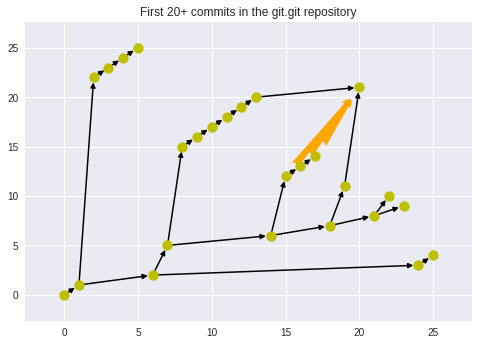

In [606]:
plt.title('First 20+ commits in the git.git repository')
draw_dominance(repo_graph,with_labels=False,draw_false_positives=True,node_size=100,edge_width=1.5)

#### Draw fragment of larger part of git.git commit graph

In [607]:
!git -C git log --format="%h %p" origin/master origin/next origin/maint --topo-order -40 >git-commit_list_x

edges = []
with open('git-commit_list_x', 'r') as f:
  for line in f:
    elems = line.split()
    commit, parents = (elems[0], elems[1:])
    for parent in parents:
      edges.append((commit, parent))
repo_graph_x = nx.DiGraph(edges)

print('repo_graph_x %r has %d nodes and %d edges' %
      (repo_graph_x, repo_graph_x.number_of_nodes(), repo_graph_x.size()))

repo_graph_x <networkx.classes.digraph.DiGraph object at 0x7fb0dbba9b50> has 49 nodes and 53 edges


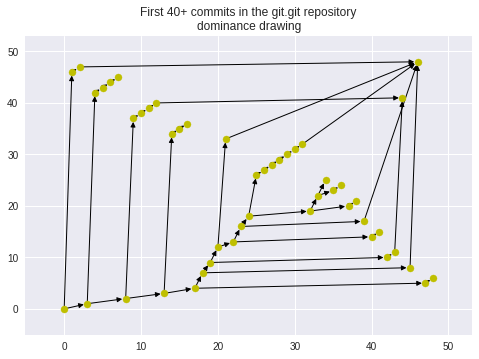

In [608]:
plt.title('First 40+ commits in the git.git repository\ndominance drawing')
draw_dominance(repo_graph_x,with_labels=False,draw_false_positives=False,node_size=50,edge_width=1.0)

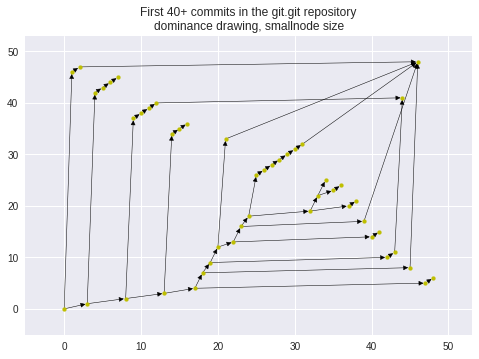

In [609]:
plt.title('First 40+ commits in the git.git repository\ndominance drawing, smallnode size')
draw_dominance(repo_graph_x,with_labels=False,node_size=15,edge_width=0.5)

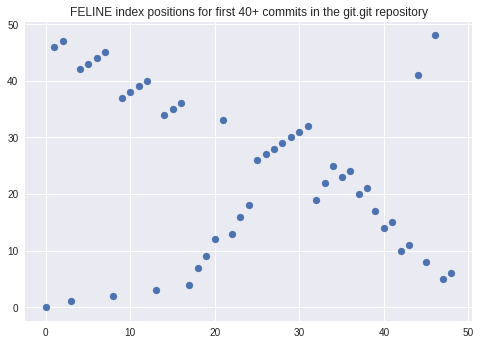

In [610]:
plt.title('FELINE index positions for first 40+ commits in the git.git repository')
plt.scatter(x=np.array([x for (x,y) in repo_graph_x.fel.values()]),
            y=np.array([y for (x,y) in repo_graph_x.fel.values()]))
plt.show()

In [0]:
#@title def draw_feline { form-width: "25%" }
def draw_feline(graph,title=None,color='b'):
  """Draw FELINE index positions for a graph
  
  The FELINE index, where every vertex in the DAG is associated with a pair
  (x,y) ∈ ℕ² can be represented graphically; each such pair is understood
  as 2D coordinates in the Cartesian plane.  This function uses this
  representation to draw scatter plot.
  
  TODO: draw multiple graphs, or multiple versions of FELINE index, like
  FELINE and FELINE-I (for inverted graph) on one plot.
  
  Parameters
  ----------
  graph : NetworkX graph
      Graph to draw.  If the graph has 'pos' attribute, or 'fel' attribute,
      its values are used as positions of vertices.  Otherwise `find_feline()`
      is used to calculate FELINE index and store it in 'fel' attribute
      of the graph.
      
  title : str, optional
      Title of the plot, shown above the drawn graph.
            
  color : color string (optional, default: 'b')
       Node color. Can be a single color format string,
       or may be a sequence of colors with the same length as nodelist.
       See matplotlib.scatter for more details.
  """
  try:
    pos=graph.pos
  except AttributeError:
    try:
      pos=graph.fel
    except AttributeError:
      graph.fel=find_feline(graph)
      pos=graph.fel
  
  if title is not None:
    plt.title(title)
    
  plt.scatter(x=np.array([x for (x,y) in pos.values()]),
              y=np.array([y for (x,y) in pos.values()]),
              c=color)
  plt.show()
  

#### Full git.git commit graph and its properties

In [612]:
%%time
!git -C git log --format="%h %p" --all --topo-order >git-commit_list_full

edges = []
commits = []
with open('git-commit_list_full', 'r') as f:
  for line in f:
    elems = line.split()
    commit, parents = (elems[0], elems[1:])
    commits.append(commit)
    for parent in parents:
      edges.append((commit, parent))
repo_graph_full = nx.DiGraph(edges)

CPU times: user 568 ms, sys: 97 ms, total: 665 ms
Wall time: 2.6 s


In [613]:
print('%d commits, %d edges' % (len(commits), len(edges)))

53266 commits, 66309 edges


In [614]:
repo_graph_full.topo=commits
repo_graph_full.topo[:6]

['75df6e6af', 'b731591f5', '4dbd0b376', 'b00e076be', '5ae8d126c', '9cdb6cb65']

Creating `git.git` commit graph takes around 2.5 seconds (in remote runtime)

In [615]:
print('find levels:')
%time repo_graph_full.lvl = find_levels(repo_graph_full)
print('\nfind FELINE:')
%time repo_graph_full.fel = find_feline(repo_graph_full)
print('\nfind min-post intervals:')
%time repo_graph_full.mpi = find_dfs_intervals(repo_graph_full)

find levels:
CPU times: user 964 ms, sys: 5 ms, total: 969 ms
Wall time: 971 ms

find FELINE:
CPU times: user 816 ms, sys: 12 ms, total: 828 ms
Wall time: 829 ms

find min-post intervals:
CPU times: user 1.39 s, sys: 63 ms, total: 1.46 s
Wall time: 1.46 s


All times to calculate different graph indices for `git.git` commit graph take around 1 second;  
levels / generation numbers and FELINE index around 0.8 s, while min-post intervals around 1.3 s.

The **Table 1: Datasets** in FELINE paper (page 517) describes various small and large, sparse and dense real-world DAGs.  This tale shows some characteristics of graphs, such as:

*   number of vertices $\lvert V \rvert$
*   number of edges $\lvert E \rvert$, where $E \subseteq V^2$
*   clustering coefficient
*   effective diameter (instead of diameter)
*   number of "roots", vertices with no incoming edges
*   number of "leafs", vertices with no outgoing edges

The authors (of either the dataset collection, or of FELINE paper) used the SNAP software <http://snap.stanford.edu/snap/> to compute these values.

The NetworkX package has []`average_clustering`][average_clustering] method to estimate the clustering coefficient (or to be more exact, for DAG `graph` it is `nx.average_clustering(graph.to_undirected())`).

[average_clustering]: https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.approximation.clustering_coefficient.average_clustering.html#networkx.algorithms.approximation.clustering_coefficient.average_clustering

In [616]:
#@title Table 1: Datasets { form-width: "25%" }

import io

csv=u"""Graph;vertices;edges;Cluster coeff.;Eff. diameter;roots;leafs
arXiv;6000;66707;0.35;5.48;961;624
Yago;6642;42392;0.24;6.57;5176;263
Go;6793;13361;0.07;10.92;64;3087
Pubmed;9000;40028;0.10;6.32;2609;4702
citeseer;10720;44258;0.28;8.36;4572;1868
Uniprot22m;1595444;1595442;0.00;3.3;1556157;1
Cit-patents;3774768;16518047;0.09;10.5;515785;1685423
citeseerx;6540401;15011260;0.06;8.4;567149;5740710
Go-uniprot;6967956;34770235;0.00;4.8;6945721;4
Uniprot100m;16087295;16087293;0.00;4.1;14598959;1
Uniprot150m;25037600;25037598;0.00;4.4;21650056;1
"""
csv_stream = io.StringIO(csv)

table_1=pd.read_csv(csv_stream,sep=';',index_col=0)
table_1.insert(loc=2,column='edges[%]',
               value=100.0*(table_1['edges']/(table_1['vertices']**2)))
table_1.insert(loc=3,column='edges/vertices',
               value=table_1['edges']/table_1['vertices'])
table_1

,vertices,edges,edges[%],edges/vertices,Cluster coeff.,Eff. diameter,roots,leafs
Graph,,,,,,,,
arXiv,6000,66707,0.185297,11.117833,0.35,5.48,961,624
Yago,6642,42392,0.096092,6.382415,0.24,6.57,5176,263
Go,6793,13361,0.028954,1.966878,0.07,10.92,64,3087
Pubmed,9000,40028,0.049417,4.447556,0.10,6.32,2609,4702
citeseer,10720,44258,0.038513,4.128545,0.28,8.36,4572,1868
Uniprot22m,1595444,1595442,0.000063,0.999999,0.00,3.30,1556157,1
Cit-patents,3774768,16518047,0.000116,4.375911,0.09,10.50,515785,1685423
citeseerx,6540401,15011260,0.000035,2.295159,0.06,8.40,567149,5740710
Go-uniprot,6967956,34770235,0.000072,4.990019,0.00,4.80,6945721,4


In [617]:
%%time

graph = repo_graph_full
graph_name = 'git.git'

n_nodes = graph.number_of_nodes()
n_edges = graph.size()
print('%s commit graph has %d nodes and %d edges (size)' %
      (graph_name, n_nodes, n_edges))
print('%s commit graph has %d possible paths\n' %
      (graph_name, n_nodes*(n_nodes-1)))

heads = find_heads(graph)
roots = find_roots(graph)
print('%s commit graph has %d tips / heads ("roots"): %r' %
      (graph_name, len(heads),heads))
print('%s commit graph has %d roots ("leaves"): %r' %
      (graph_name, len(roots),roots))

clustering_coeff = nx.average_clustering(graph.to_undirected())
print('%s commit graph has average clustering coefficient %g (%d trials ?)\n' %
      (graph_name, clustering_coeff, 1000))
# NetworkXError: Found infinite path length because the digraph is not strongly connected
#print('%s commit graph has the diameter of %g\n' %
#      (graph_name, nx.diameter(graph)))

commit_graphs_df = pd.DataFrame({
    'Graph': [graph_name],
    'vertices': [n_nodes],
    'edges': [n_edges],
    'Cluster coeff.': [clustering_coeff],
    'roots': [len(heads)],
    'leafs': [len(roots)],
},columns=['Graph','vertices','edges',
           'Cluster coeff.','Eff. diameter',
           'roots','leafs']).set_index('Graph')

git.git commit graph has 53266 nodes and 66309 edges (size)
git.git commit graph has 2837213490 possible paths

git.git commit graph has 4 tips / heads ("roots"): ['4582c99ba', 'fedc7d545', '75df6e6af', '2c687f8fa']
git.git commit graph has 9 roots ("leaves"): ['16d6b8ab6', '1bd90415d', '0ca71b373', 'cb07fc2a2', 'e83c51633', '161332a52', '1db95b00a', '2744b2344', '7d77f2e9c']
git.git commit graph has average clustering coefficient 0.000408157 (1000 trials ?)

CPU times: user 3.23 s, sys: 68 ms, total: 3.3 s
Wall time: 3.28 s


Wall time for computing different parameters of the git.git commit graph take around 2.5 seconds; mainly (?) in finding estimation of the clustering coefficient.

In [618]:
#@title git.git commit graph dataset { form-width: "25%" }
df=commit_graphs_df

df.insert(loc=2,column='edges[%]',
          value=100.0*(df['edges']/(df['vertices']**2)))
df.insert(loc=3,column='edges/vertices',
          value=df['edges']/df['vertices'])
commit_graphs_df

,vertices,edges,edges[%],edges/vertices,Cluster coeff.,Eff. diameter,roots,leafs
Graph,,,,,,,,
git.git,53266,66309,0.002337,1.244865,0.000408,NaN,4,9


In [619]:
table_1

,vertices,edges,edges[%],edges/vertices,Cluster coeff.,Eff. diameter,roots,leafs
Graph,,,,,,,,
arXiv,6000,66707,0.185297,11.117833,0.35,5.48,961,624
Yago,6642,42392,0.096092,6.382415,0.24,6.57,5176,263
Go,6793,13361,0.028954,1.966878,0.07,10.92,64,3087
Pubmed,9000,40028,0.049417,4.447556,0.10,6.32,2609,4702
citeseer,10720,44258,0.038513,4.128545,0.28,8.36,4572,1868
Uniprot22m,1595444,1595442,0.000063,0.999999,0.00,3.30,1556157,1
Cit-patents,3774768,16518047,0.000116,4.375911,0.09,10.50,515785,1685423
citeseerx,6540401,15011260,0.000035,2.295159,0.06,8.40,567149,5740710
Go-uniprot,6967956,34770235,0.000072,4.990019,0.00,4.80,6945721,4


In [620]:
# calculating parameters of the git.git commit graphs: distribution of in-degree, out-degree and level
graph_info_df=pd.DataFrame.from_dict(repo_graph_full.lvl,orient='index').rename(columns={0: 'level'})
graph_info_df.index.name='node'
graph_info_df['FELINE']=pd.Series(repo_graph_full.fel)
graph_info_df['min-post']=pd.Series(repo_graph_full.mpi)
graph_info_df['in degree']=pd.Series(dict(repo_graph_full.in_degree()))
graph_info_df['out degree']=pd.Series(dict(repo_graph_full.out_degree()))
graph_info_df.head()

,level,FELINE,min-post,in degree,out degree
node,,,,,
dfe0171c4,10703,"(30952, 30930)","[1, 22120]",1,2
61d15cd63,18286,"(3118, 2737)","[52033, 52059]",1,1
21e4631c0,12036,"(26178, 26004)","[22121, 26857]",1,1
7bfffdc8a,12921,"(23153, 22605)","[26858, 30100]",2,2
dce5ef142,9970,"(33038, 33032)","[20256, 20258]",1,1


In [621]:
graph_info_df.describe()

,level,in degree,out degree
count,53266.000000,53266.000000,53266.000000
mean,10288.687925,1.244865,1.244865
std,5558.774582,1.319447,0.433490
min,0.000000,0.000000,0.000000
25%,5741.000000,1.000000,1.000000
50%,11268.500000,1.000000,1.000000
75%,14959.000000,1.000000,1.000000
max,18552.000000,89.000000,6.000000


count    18553.000000
mean         2.871018
std          2.931226
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         93.000000
Name: level, dtype: float64

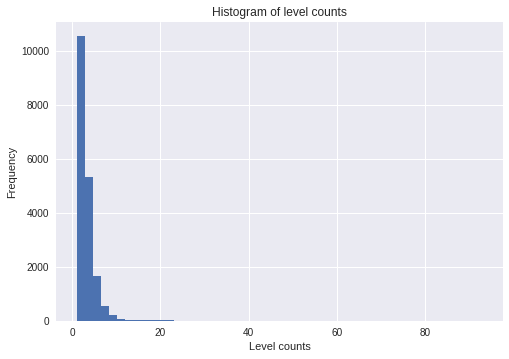

In [622]:
level_counts=graph_info_df['level'].value_counts()
level_counts_values=level_counts.values

plt.title('Histogram of level counts')
plt.xlabel('Level counts')
level_counts.plot.hist(bins=50)
#pd.cut(level_counts_values,50)

level_counts.describe()

,count,mean,std,min,25%,50%,75%,max
level counts,18553.0,2.871018,2.931226,1.0,1.0,2.0,3.0,93.0


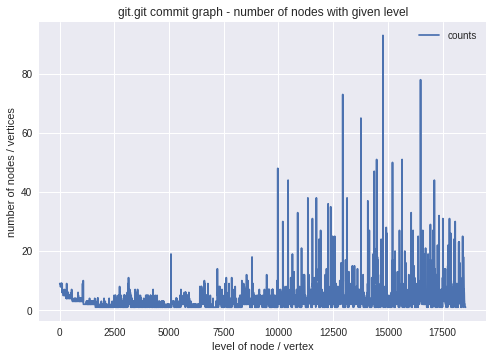

In [623]:
#@title git.git levels count plot { form-width: "30%" }
import seaborn as sns
sns.set()

level_counts_df=pd.DataFrame({'counts': level_counts})
level_counts_df.index.name='level'
level_counts_df.sort_index(inplace=True)
level_counts_df.plot();

plt.title('%s commit graph - number of nodes with given level' %
          'git.git');
plt.xlabel('level of node / vertex');
plt.ylabel('number of nodes / vertices');

level_counts_df.describe().T.rename(index={'counts': 'level counts'})

,count,mean,std,min,10%,25%,50%,75%,90%,99%,max
level counts,18553.0,2.871018,2.931226,1.0,1.0,1.0,2.0,3.0,5.0,13.0,93.0
roll=10,18553.0,1.907400,1.150513,1.0,1.0,1.0,2.0,2.0,3.0,6.0,9.0
roll=20,18553.0,1.710667,1.012983,1.0,1.0,1.0,1.0,2.0,3.0,5.0,9.0


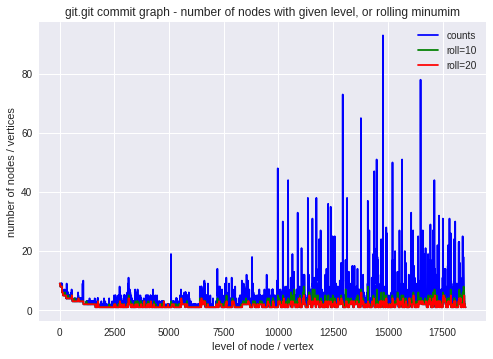

In [624]:
roll_10=level_counts_df.rolling(10, min_periods=1).min().rename(columns={'counts': 'roll=10'})
roll_20=level_counts_df.rolling(20, min_periods=1).min().rename(columns={'counts': 'roll=20'})
combined_df=level_counts_df.join(roll_10).join(roll_20)
combined_df.plot(color=['b','g','r']);

plt.title('%s commit graph - number of nodes with given level, or rolling minumim' %
          'git.git');
plt.xlabel('level of node / vertex');
plt.ylabel('number of nodes / vertices');

combined_df.describe(percentiles=[.1, .25, .5, .75, .9, .99]).T.rename(index={'counts': 'level counts'})

CPU times: user 916 ms, sys: 153 ms, total: 1.07 s
Wall time: 895 ms


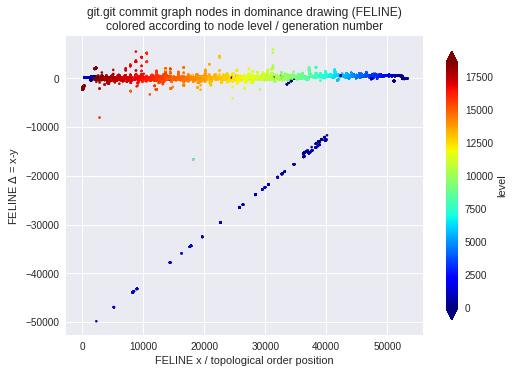

In [625]:
#@title git.git feline plot, level colormap { form-width: "30%" }
%%time
graph=repo_graph_full
pos=graph.fel

plt.title('git.git commit graph nodes in dominance drawing (FELINE)\n'+
          'colored according to node level / generation number')
plt.xlabel('FELINE x / topological order position')
plt.ylabel('FELINE $\Delta$ = x-y')


xarr = np.array([x for (x,y) in pos.values()])
yarr = np.array([(x-y) for (x,y) in pos.values()])
larr = np.array([graph.lvl[n] for n in pos.keys()])

ax = plt.gca()
sc = plt.scatter(x=xarr, y=yarr,
                 c=larr, cmap=plt.cm.jet,
                 s=5,
                 label='graph')
cbar = plt.colorbar(sc, extend='both', shrink=0.9, ax=ax)
cbar.set_label('level')
plt.draw()

CPU times: user 938 ms, sys: 168 ms, total: 1.11 s
Wall time: 919 ms


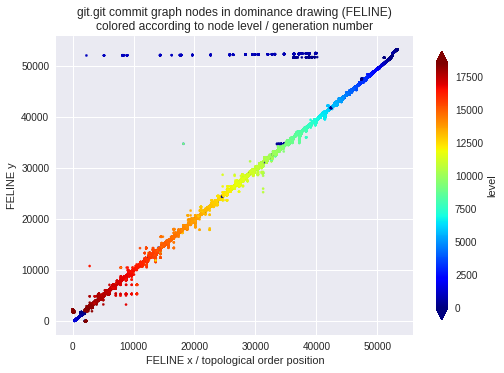

In [626]:
%%time
graph=repo_graph_full
pos=graph.fel

plt.title('git.git commit graph nodes in dominance drawing (FELINE)\n'+
          'colored according to node level / generation number')
plt.xlabel('FELINE x / topological order position')
plt.ylabel('FELINE y')


xarr = np.array([x for (x,y) in pos.values()])
yarr = np.array([y for (x,y) in pos.values()])
larr = np.array([graph.lvl[n] for n in pos.keys()])

ax = plt.gca()
sc = plt.scatter(x=xarr, y=yarr,
                 c=larr, cmap=plt.cm.jet,
                 s=5,
                 label='graph')
cbar = plt.colorbar(sc, extend='both', shrink=0.9, ax=ax)
cbar.set_label('level')
plt.draw()

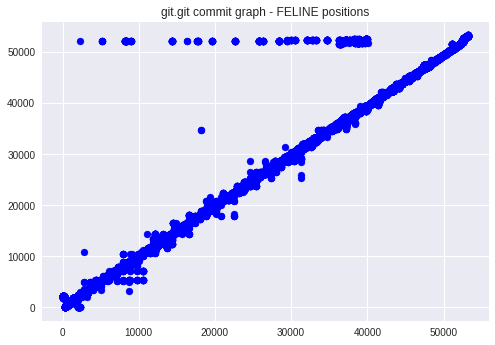

In [627]:
#@title git.git draw_feline { form-width: "30%" }
draw_feline(repo_graph_full, title='git.git commit graph - FELINE positions')

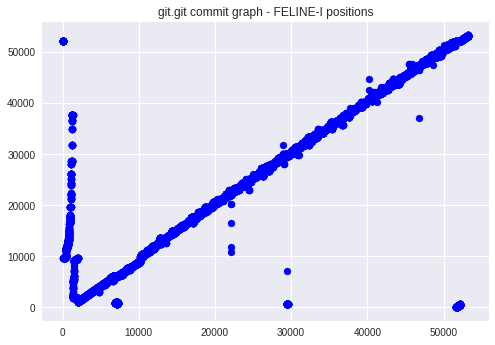

In [628]:
draw_feline(repo_graph_full.reverse(copy=True),
            title='git.git commit graph - FELINE-I positions')

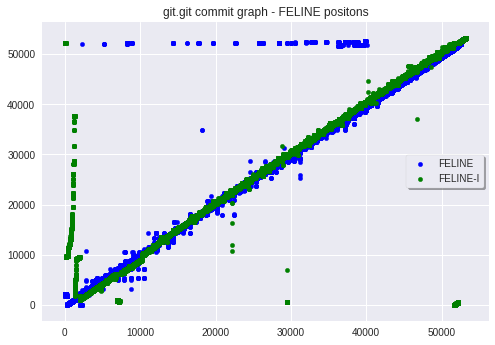

In [629]:
#@title git.git FELINE and FELINE-I { form-width: "30%" }
plt.title('git.git commit graph - FELINE positons')

pos=repo_graph_full.fel
plt.scatter(x=np.array([x for (x,y) in pos.values()]),
            y=np.array([y for (x,y) in pos.values()]),
            c='b',s=20, label='FELINE')
pos=find_feline(repo_graph_full.reverse())
plt.scatter(x=np.array([x for (x,y) in pos.values()]),
            y=np.array([y for (x,y) in pos.values()]),
            c='g',s=20, label='FELINE-I')
plt.legend(frameon=True,fancybox=True,shadow=True)
plt.show()

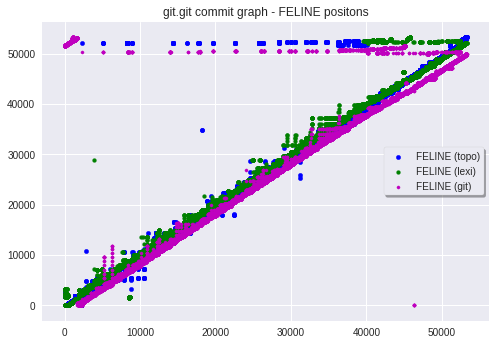

In [630]:
plt.title('git.git commit graph - FELINE positons')

pos=repo_graph_full.fel
plt.scatter(x=np.array([x for (x,y) in pos.values()]),
            y=np.array([y for (x,y) in pos.values()]),
            c='b',s=20, label='FELINE (topo)')
pos=find_feline(repo_graph_full,topological_sort=nx.lexicographical_topological_sort)
plt.scatter(x=np.array([x for (x,y) in pos.values()]),
            y=np.array([y for (x,y) in pos.values()]),
            c='g',s=15, label='FELINE (lexi)')
pos=find_feline(repo_graph_full,topological_sort=lambda G: G.topo)
plt.scatter(x=np.array([x for (x,y) in pos.values()]),
            y=np.array([y for (x,y) in pos.values()]),
            c='m',s=10, label='FELINE (git)')
plt.legend(frameon=True,fancybox=True,shadow=True)
plt.show()

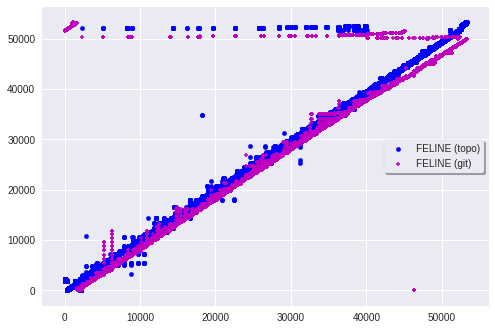

In [631]:
pos=repo_graph_full.fel
plt.scatter(x=np.array([x for (x,y) in pos.values()]),
            y=np.array([y for (x,y) in pos.values()]),
            c='b',s=20, label='FELINE (topo)')
#pos=find_feline(repo_graph_full,topological_sort=nx.lexicographical_topological_sort)
#plt.scatter(x=np.array([x for (x,y) in pos.values()]),
#            y=np.array([y for (x,y) in pos.values()]),
#            c='g',s=15, label='FELINE (lexi)')
pos=find_feline(repo_graph_full,topological_sort=lambda G: G.topo)
plt.scatter(x=np.array([x for (x,y) in pos.values()]),
            y=np.array([y for (x,y) in pos.values()]),
            c='m',s=15, alpha=0.9, marker='+', label='FELINE (git)')
plt.legend(frameon=True,fancybox=True,shadow=True)
plt.show()

#### Finding paths / checking reachability between two commits

In [632]:
%%time
graph = repo_graph_full

print('max level in %s commit graph is %d (out of %d nodes)\n' % 
      ('git.git', max(graph.lvl.values()),graph.number_of_nodes()))

max level in git.git commit graph is 18552 (out of 53266 nodes)

CPU times: user 4 ms, sys: 1e+03 µs, total: 5 ms
Wall time: 4.68 ms


In [633]:
print('max commits at given level: %d' %max(level_counts))
lmax=max(level_counts.keys(), key=lambda k: level_counts[k])
print('level with max commits is %d (out of %d) with %d commits' %
      (lmax, max(graph.lvl.values()), level_counts[lmax]))

max commits at given level: 93
level with max commits is 14776 (out of 18552) with 93 commits


In [634]:
%%time
graph = repo_graph_full

print('commits with level %d:\n* %r\n' %
      (lmax, [c for (c,l) in graph.lvl.items() if l == lmax]))

commits with level 14776:
* ['777c55a61', '414382fb0', '4bf256d67', '66d2e04ec', '8c1e9f40f', 'db8d75087', 'fddfaf8a2', '83e085a1f', 'c2048f0b3', '8b9c2dd4d', '129260cbd', '1044b1f6a', '0b1f688bf', 'bac2c5bf1', 'e34f80278', 'cb64800d8', 'eb86a507a', 'f6a1e1e28', '22946a942', '9bdc5173f', 'c8a70d350', 'cd82b7a0f', '64f2589a0', '0bbc971ab', 'c9e1f2c7f', '4aff646d1', 'd89df367f', 'ee0e38727', '270f0a8cb', 'ad3967a5a', '2bf15a333', '16272c7db', '6c3b2afe6', '852ff1c36', 'b6e8a3b54', '9e8f8dea4', 'a9c4641df', '838d6a928', '5dcd1b157', 'fbfa0973f', '5e0be134d', '0eeb077be', '77fdb8a82', 'b4bba8de1', '1d968ca69', '5efc60c12', '862e730ec', '999027391', '2bd07065c', '29abb3397', '189c860c9', 'f98c2f7e5', '1de2e442a', '7fcec48da', '9a6f1287f', 'a3e1fa97b', '17d65f03e', 'b25c46995', 'cb5add586', 'c9d441a89', 'e53a64b98', 'eb32c66e8', 'd91302276', '72dbb3655', '7886cfa08', '599d22310', '0544574cd', 'd5c4b1855', '7d782416c', 'ac179b4d9', '25143a54f', 'be510e010', 'd95138e69', '975e382d1', '70320541

In [635]:
tags = sorted([tagref for tagref in repo.tags if tagref.object.object.type == 'commit'], 
              key=lambda t: t.commit.committed_datetime,
              reverse=True)
[(t, str(t.commit.hexsha[:9])) for t in tags[:10]]

[(<git.TagReference "refs/tags/v2.17.0">, '468165c1d'),
 (<git.TagReference "refs/tags/v2.17.0-rc2">, '03df49594'),
 (<git.TagReference "refs/tags/v2.16.3">, 'd32eb83c1'),
 (<git.TagReference "refs/tags/v2.17.0-rc1">, '085f5f95a'),
 (<git.TagReference "refs/tags/v2.17.0-rc0">, '0afbf6caa'),
 (<git.TagReference "refs/tags/v2.16.2">, 'ffa952497'),
 (<git.TagReference "refs/tags/v2.16.1">, '8279ed033'),
 (<git.TagReference "refs/tags/v2.16.0">, '2512f1544'),
 (<git.TagReference "refs/tags/v2.16.0-rc2">, 'c6c75c93a'),
 (<git.TagReference "refs/tags/v2.16.0-rc1">, '36438dc19')]

In [636]:
graph = repo_graph_full

c='468165c1d'
l=graph.lvl[c]
n=level_counts[l]

#print('commit %s in %s commit graph has level=%d;\n'+
#      'there are %d commits with the same level' %
#      (c, 'git.git', l, n))
print('commit %s in %s commit graph has level=%d\nthere are %d commits with the same level\n* %r' %
      (c, 'git.git', l, n,
       [cc for (cc,ll) in graph.lvl.items() if ll == l]))

commit 468165c1d in git.git commit graph has level=18418
there are 6 commits with the same level
* ['7cbae724a', '2b5ed3736', 'f24cd4189', '6d2f9acc0', '9153dde5e', '468165c1d']


In [637]:
hex1 = repo.tag('refs/tags/v2.17.0').tag.object.hexsha
print('%s -> %s\n         %r' %
      ('v2.17.0', hex1, [n for n in repo_graph_full if hex1.startswith(n)]))
hex2 = repo.tag('refs/tags/v2.17.0-rc2').tag.object.hexsha
print('%s -> %s\n             %r' %
      ('v2.17.0-rc2', hex2, [n for n in repo_graph_full if hex2.startswith(n)]))
hex3 = repo.tag('refs/tags/v2.16.2').tag.object.hexsha
print('%s -> %s\n         %r' %
      ('v2.16.2', hex3, [n for n in repo_graph_full if hex3.startswith(n)]))

v2.17.0 -> 468165c1d8a442994a825f3684528361727cd8c0
         ['468165c1d']
v2.17.0-rc2 -> 03df4959472e7d4b5117bb72ac86e1e2bcf21723
             ['03df49594']
v2.16.2 -> ffa952497288d29d94b16675c6789ef83850def3
         ['ffa952497']


In [638]:
!git -C git rev-list --count v2.17.0-rc2..v2.17.0
!git -C git rev-list --count v2.16.2..v2.17.0
!git -C git rev-list --count v2.16.2..v2.17.0-rc2

28
703
675


In [639]:
!git -C git rev-list --count v2.17.0-rc2..2b5ed3736

6


In [640]:
#@title git.git: v2.17.0 -> v2.17.0-rc2 { form-width: "30%" }
%%time
import pprint

stats_l={
    'naive': {},
    'level': {},
    'feline': {},
    'level+feline':{},
    'level+feline+mpi':{},
}
u='468165c1d' # v2.17.0
#u='2b5ed3736'
v='03df49594' # v2.17.0-rc2
#v='ffa952497' # v2.16.2
print('%s -> %s' %(u,v))

graph = repo_graph_full

if u in graph and v in graph:

  print('- naive')
  generic_is_reachable_large(graph, u, v,
                             stats=stats_l['naive'])
  print('- level (generation numbers)')
  generic_is_reachable_large(graph, u, v,
                             l=graph.lvl,
                             stats=stats_l['level'])
  print('- FELINE')
  generic_is_reachable_large(graph, u, v,
                             i=graph.fel,
                             stats=stats_l['feline'])
  print('- FELINE+level')
  generic_is_reachable_large(graph, u, v,
                             l=graph.lvl,i=graph.fel,
                             stats=stats_l['level+feline'])
  print('- FELINE+level+min-post')
  generic_is_reachable_large(graph, u, v,
                             l=graph.lvl,i=graph.fel,II=graph.mpi,
                             stats=stats_l['level+feline+mpi'])
  
  pp = pprint.PrettyPrinter(indent=4)
  stats_l['naive']['len(walk)'] = len(stats_l['naive']['walk'])
  del stats_l['naive']['walk']
  pp.pprint(stats_l)
  
else:
  print('not in graph')

468165c1d -> 03df49594
- naive
- level (generation numbers)
- FELINE
- FELINE+level
- FELINE+level+min-post
{   'feline': {   'access': 7,
                  'feline-filter': ['8bb6d60dd', 'fd2fb4aa0', 'c7620bd0f'],
                  'maxdepth': 1,
                  'visited-filter': 0,
                  'walk': [   '468165c1d',
                              '1614dd0fb',
                              '8bb6d60dd',
                              '5f9441769',
                              'fd2fb4aa0',
                              'c2a499e6c',
                              'c7620bd0f',
                              '03df49594']},
    'level': {   'access': 7,
                 'level-filter': ['8bb6d60dd', 'fd2fb4aa0', 'c7620bd0f'],
                 'maxdepth': 1,
                 'visited-filter': 0,
                 'walk': [   '468165c1d',
                             '1614dd0fb',
                             '8bb6d60dd',
                             '5f9441769',
                         

In [641]:
!git -C git rev-list --topo-order --count 03df49594..468165c1d

28


In [642]:
def rev_to_node(repo, graph, revision):
  """Find node in [commit] graph corresponding to given revision
  
  Parameters
  ----------
  repo : GitPython repository
      git.Repo used to resolve revisions.  Should be the same repository
      the commit graph was created from.
      
  graph : NetworkX DiGraph
      The DAG representing subset of the commit graph of repository.  This
      function finds matching nodes in this graph.  It is assumed that node
      names are shortened SHA-1 identifiers of commit objects.
      
  revision : str or unicode
      String that can be parsed as git revision in given repository.  It may
      be full SHA-1 identifier, or shortened SHA-1, or branch, or tag name.
      
  Returns
  -------
  node : str
      Node corresponding to given revision.
  """
  try:
    hexsha = str(repo.rev_parse(revision+'^{}').hexsha)
    nodes = [n for n in graph if hexsha.startswith(n)]
    if nodes:
      return nodes[0]
    else:
      return None
    
  except git.exc.BadName:
    return None
  

rev_to_node(repo, repo_graph_full, 'v2.17.0')

'468165c1d'

In [643]:
rev_to_node(repo, repo_graph_full, '468165c1d')

'468165c1d'

In [644]:
#@title git.git: src -> dst { form-width: "30%" }
src = "468165c1d" #@param ["468165c1d", "2b5ed3736", "03df49594"] {allow-input: true}
dst = "66d2e04ec" #@param ["03df49594", "ffa952497", '777c55a61', '414382fb0', '4bf256d67', "66d2e04ec"]  {allow-input: true}

stats_l={
    'naive': {},
    'level': {},
    'feline': {},
    'level+feline':{},
    'level+feline+mpi':{},
}
print('src=%s -> dst=%s' %(src, dst))

v=rev_to_node(repo, repo_graph_full, src)
u=rev_to_node(repo, repo_graph_full, dst)

graph = repo_graph_full

if (u is None) or (v is None):
  if u is None:
    print('src=%s not in repo or not in graph' % src)
  if v is None:
    print('dst=%s not in repo or not in graph' % dst)

elif u in graph and v in graph:
  print('u = %s -> v = %s' %(u,v))
  print('* %s has level %d which it shares with %d commits' %
        (u, graph.lvl[u], level_counts[graph.lvl[u]]))
  print('* %s has level %d which it shares with %d commits' %
        (v, graph.lvl[v], level_counts[graph.lvl[v]]))
  print('* gen(%s) - gen(%s) = %d' %
        (u, v, graph.lvl[u] - graph.lvl[v]))
  print('')

  #print('- naive')
  generic_is_reachable_large(graph, u, v,
                             stats=stats_l['naive'])
  #print('- level (generation numbers)')
  generic_is_reachable_large(graph, u, v,
                             l=graph.lvl,
                             stats=stats_l['level'])
  #print('- FELINE')
  generic_is_reachable_large(graph, u, v,
                             i=graph.fel,
                             stats=stats_l['feline'])
  #print('- FELINE+level')
  generic_is_reachable_large(graph, u, v,
                             l=graph.lvl,i=graph.fel,
                             stats=stats_l['level+feline'])
  #print('- FELINE+level+min-post')
  generic_is_reachable_large(graph, u, v,
                             l=graph.lvl,i=graph.fel,II=graph.mpi,
                             stats=stats_l['level+feline+mpi'])
  
  for t in stats_l:
    for st in ('walk', 'feline-filter', 'level-filter'):
      if st in stats_l[t]:
        stats_l[t]['len(%s)' % st] = len(stats_l[t][st])
        del stats_l[t][st]
     
  pp = pprint.PrettyPrinter(indent=4)
  pp.pprint(stats_l)
  
else:
  print('not in graph')

src=468165c1d -> dst=66d2e04ec
u = 66d2e04ec -> v = 468165c1d
* 66d2e04ec has level 14776 which it shares with 93 commits
* 468165c1d has level 18418 which it shares with 6 commits
* gen(66d2e04ec) - gen(468165c1d) = -3642

{   'feline': {   'access': 0,
                  'len(feline-filter)': 1,
                  'len(walk)': 1,
                  'maxdepth': 0,
                  'visited-filter': 0},
    'level': {   'access': 0,
                 'len(level-filter)': 1,
                 'len(walk)': 1,
                 'maxdepth': 0,
                 'visited-filter': 0},
    'level+feline': {   'access': 0,
                        'len(feline-filter)': 1,
                        'len(level-filter)': 1,
                        'len(walk)': 1,
                        'maxdepth': 0,
                        'visited-filter': 0},
    'level+feline+mpi': {   'access': 0,
                            'len(feline-filter)': 1,
                            'len(level-filter)': 1,
               

In [645]:
# testing different versions of FELINE,
# with different topological ordering

graph = repo_graph_full
stats_x = {}

if (u is None) or (v is None):
  if u is None:
    print('src=%s not in repo or not in graph' % src)
  if v is None:
    print('dst=%s not in repo or not in graph' % dst)

elif u in graph and v in graph:
  print('u = %s -> v = %s: %r' %(u,v,nx.has_path(graph,u,v)))
  print('* %s has level %d which it shares inclusively with %d commits' %
        (u, graph.lvl[u], level_counts[graph.lvl[u]]))
  print('* %s has level %d which it shares inclusively with %d commits' %
        (v, graph.lvl[v], level_counts[graph.lvl[v]]))
  print('* gen(%s) - gen(%s) = %d' %
        (u, v, graph.lvl[u] - graph.lvl[v]))
  
  gray_count = 0
  for n in graph:
    if graph.lvl[u] >= graph.lvl[n] and \
       graph.lvl[n] >= graph.lvl[v]:
      gray_count += 1
  print('* %d nodes (around) out of %d in levels inclusion zone' %
        (gray_count, graph.number_of_nodes()))
  
  print('')
  
  stats_x['naive'] = {}
  generic_is_reachable_large(graph, u, v,
                             stats=stats_x['naive'])
  stats_x['level'] = {}
  generic_is_reachable_large(graph, u, v,
                             l=graph.lvl,
                             stats=stats_x['level'])
  
  for (pos, name) in [(graph.fel, 'feline'),
                      (find_feline(repo_graph_full,
                                   topological_sort=nx.lexicographical_topological_sort),'feline(lexi)'),
                      (find_feline(repo_graph_full,
                                   topological_sort=lambda G: G.topo),'feline(git)')]:
    stats_x[name] = {}
    generic_is_reachable_large(graph, u, v,
                               i=pos,
                               stats=stats_x[name])
    stats_x['lvl+'+name] = {}
    generic_is_reachable_large(graph, u, v,
                               l=graph.lvl,i=pos,
                               stats=stats_x['lvl+'+name])
    stats_x['lvl+'+name+'+mpi'] = {}
    generic_is_reachable_large(graph, u, v,
                               l=graph.lvl,i=pos,II=graph.mpi,
                               stats=stats_x['lvl+'+name+'+mpi'])
  
  stats_n = {}
  for t in sorted(stats_x, key=lambda k: stats_x[k]['access']):
    stats_n[t] = {}
    for st in stats_x[t]:
      if isinstance(stats_x[t][st], list):
        stats_n[t]['len(%s)' % st] = len(stats_x[t][st])
      elif isinstance(stats_x[t][st], int) or \
           isinstance(stats_x[t][st], float):
        stats_n[t][st] = stats_x[t][st]
      else:
        stats_n[t][st] = bool(stats_x[t][st])
        
  stats_df = pd.DataFrame.from_dict(stats_n,orient='index')\
                         .sort_index(axis=0,ascending=False)\
                         .filter(items=['access','len(walk)','maxdepth','visited-filter',
                                        'len(level-filter)','len(feline-filter)','min-post'])\
                         .sort_values('access', ascending=False)
  print(stats_df)

u = 66d2e04ec -> v = 468165c1d: False
* 66d2e04ec has level 14776 which it shares inclusively with 93 commits
* 468165c1d has level 18418 which it shares inclusively with 6 commits
* gen(66d2e04ec) - gen(468165c1d) = -3642
* 0 nodes (around) out of 53266 in levels inclusion zone

                      access  len(walk)  maxdepth  visited-filter  \
naive                  44960      36653       198            8308   
lvl+feline+mpi             0          1         0               0   
lvl+feline(lexi)+mpi       0          1         0               0   
lvl+feline(lexi)           0          1         0               0   
lvl+feline(git)+mpi        0          1         0               0   
lvl+feline(git)            0          1         0               0   
lvl+feline                 0          1         0               0   
level                      0          1         0               0   
feline(lexi)               0          1         0               0   
feline(git)                0 

In [646]:
stats_df

,access,len(walk),maxdepth,visited-filter,len(level-filter),len(feline-filter)
naive,44960,36653,198,8308,NaN,NaN
lvl+feline+mpi,0,1,0,0,1.0,1.0
lvl+feline(lexi)+mpi,0,1,0,0,1.0,1.0
lvl+feline(lexi),0,1,0,0,1.0,1.0
lvl+feline(git)+mpi,0,1,0,0,1.0,1.0
lvl+feline(git),0,1,0,0,1.0,1.0
lvl+feline,0,1,0,0,1.0,1.0
level,0,1,0,0,1.0,NaN
feline(lexi),0,1,0,0,NaN,1.0
feline(git),0,1,0,0,NaN,1.0


In [647]:
!git -C git describe 468165c1d
!git -C git describe 66d2e04ec

v2.17.0
v2.0.5-5-g66d2e04ec


In [648]:
%%time

graph=repo_graph_full
stats_l={
    'naive': {},
    'level': {},
    'feline': {},
    'level+feline':{},
    #'level+feline+mpi':{},
}

(u,v) = (v,u)
print('%s -> %s' % (u,v))

#print('- naive')
generic_is_reachable_large(graph, u, v,
                           stats=stats_l['naive'])
#print('- level (generation numbers)')
generic_is_reachable_large(graph, u, v,
                           l=graph.lvl,
                           stats=stats_l['level'])
#print('- FELINE')
generic_is_reachable_large(graph, u, v,
                           i=graph.fel,
                           stats=stats_l['feline'])
#print('- FELINE+level')
generic_is_reachable_large(graph, u, v,
                           l=graph.lvl,i=graph.fel,
                           stats=stats_l['level+feline'])
#print('- FELINE+level+min-post')
#generic_is_reachable_large(graph, u, v,
#                           l=graph.lvl,i=graph.fel,II=graph.mpi,
#                           stats=stats_l['level+feline+mpi'])

468165c1d -> 66d2e04ec
CPU times: user 111 ms, sys: 18 ms, total: 129 ms
Wall time: 129 ms


In [649]:
pos=graph.fel

# Matplotlib recognizes the following formats to specify a color:
# + one of {'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'}
# - one of {'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'}
#color=np.full(len(pos),'b')
#for (i,k) in enumerate(pos):
#  if k in stats_l['naive']['walk']:
#    color[i] = 'c'
#  if k in stats_l['level']['walk']:
#    color[i] = 'g'
#  if k in stats_l['level+feline']['walk']:
#    color[i] = 'r'
#  if k in stats_l['level+feline']['feline-filter']:
#    color[i] = 'm'
#  if graph.lvl[k] == graph.lvl[u] or \
#     graph.lvl[k] == graph.lvl[v]:
#    color[i] = 'k'
#
#plt.title('c for naive, g for levels, r for FELINE')
#plt.vlines([pos[u][0],pos[v][0]],0,50000,lw=1.5,linestyles='dotted')
#plt.hlines([pos[u][1],pos[v][1]],0,50000,lw=1.5,linestyles='dotted')
#plt.scatter(x=np.array([x for (x,y) in pos.values()]),
#            y=np.array([y for (x,y) in pos.values()]),
#            c=color,s=5,alpha=0.5)
#plt.show()
#print(color)
print('u=%s position is %r, level is %d' % (u,pos[u],graph.lvl[u]))
print('v=%s position is %r, level is %d' % (v,pos[v],graph.lvl[v]))

u=468165c1d position is (2591, 2590), level is 18418
v=66d2e04ec position is (13847, 13532), level is 14776


In [0]:
def walk_colorize_rgba(i, u, v, nodes, stats, levels):
  k = nodes[i]
  
  # bracketing levels
  if (levels[k] == levels[u]) or (levels[k] == levels[v]):
    return (0.0,0.0,0.0,1.0) # black
  # FELINE - negative cuts
  if k in stats['level+feline']['feline-filter']:
    return (1.0,0.5,0.0,1.0) # orange
  if k in stats['level+feline']['level-filter']:
    return (1.0,0.0,0.5,1.0) # magenta-ish
  # FELINE - walk
  if k in stats['level+feline']['walk']:
    return (1.0,0.0,0.0,1.0) # red
  # levels - negative cuts
  if k in stats['level']['level-filter']:
    return (0.0,0.4,0.0,1.0) # dark green
  # levels - walk
  if k in stats['level']['walk']:
    return (0.0,1.0,0.0,1.0) # green
  # naive  - walk
  if k in stats['naive']['walk']:
    return (0.0,0.5,1.0,0.5) # cyan
  # the rest
  return   (0.0,0.0,0.9,0.2) # blue
  
  
def prepared_stats(stats_l):
  stats = {}
  for walk in ('naive', 'level', 'level+feline'):
    if walk in stats_l:
      stats[walk] = {}
      for attr in stats_l[walk]:
        if isinstance(stats_l[walk][attr], list):
          stats[walk][attr] = set(stats_l[walk][attr])
          
  return stats

array_for
CPU times: user 81 ms, sys: 0 ns, total: 81 ms
Wall time: 81 ms
(53266, 4): array([[0. , 0.5, 1. , 0.5],
       [0. , 0.5, 1. , 0.5],
       [0. , 0.5, 1. , 0.5],
       ...,
       [0. , 0.5, 1. , 0.5],
       [0. , 0. , 0.9, 0.2],
       [0. , 1. , 0. , 1. ]])



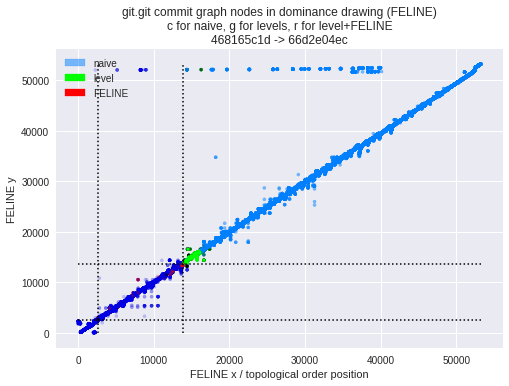

u=468165c1d position is (2591, 2590), level is 18418
v=66d2e04ec position is (13847, 13532), level is 14776
- naive walked 39590
- level walked 2491
- level+feline walked 233


In [651]:
#@title git.git: src -> dst plots { form-width: "30%" }
graph=repo_graph_full
pos=graph.fel

# https://stackoverflow.com/questions/35215161/most-efficient-way-to-map-function-over-numpy-array/35215329
# https://stackoverflow.com/questions/7994394/efficient-thresholding-filter-of-an-array-with-numpy
nodes=pos.keys()
stats=prepared_stats(stats_l)
vc=np.vectorize(lambda i: walk_colorize_rgba(i,u,v,nodes,stats,graph.lvl))

print('array_for') # CPU times: user 77 ms, sys: 1e+03 µs, total: 78 ms; Wall time: 78.3 ms
%time color = np.array([walk_colorize_rgba(i,u,v,nodes,stats,graph.lvl) for i in xrange(0,len(nodes))])
print('%r: %r\n' % (color.shape, color))

#print('array_map') # CPU times: user 77 ms, sys: 1e+03 µs, total: 78 ms; Wall time: 77.5 ms
#%time color = np.array(map(lambda i: walk_colorize_rgba(i,u,v,nodes,stats,graph.lvl), xrange(0,len(nodes))))
#print('%r: %r\n' % (color.shape, color))

#print('vectorized') # does not return np.array for some reason...
#%time color = vc(np.arange(len(nodes)))
#print('%r: %r\n' % (color.shape, color))

# Matplotlib recognizes the following formats to specify a color:
# - one of {'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'}
# - one of {'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'}
# + an RGB or RGBA tuple of float values in [0, 1] (e.g., (0.1, 0.2, 0.5) or (0.1, 0.2, 0.5, 0.3));
# - a hex RGB or RGBA string (e.g., '#0F0F0F' or '#0F0F0F0F');
# - a string representation of a float value in [0, 1] inclusive for gray level (e.g., '0.5');
# - a X11/CSS4 color name;
# - ...

import matplotlib.patches as mpatches

plt.title('git.git commit graph nodes in dominance drawing (FELINE)\n'+
          'c for naive, g for levels, r for level+FELINE\n'+
          ''+u+' -> '+v+'')
plt.xlabel('FELINE x / topological order position')
plt.ylabel('FELINE y')
plt.legend(handles=[mpatches.Patch(color=(0.0,0.5,1.0,0.5), label='naive'),
                    mpatches.Patch(color=(0.0,1.0,0.0,1.0), label='level'),
                    mpatches.Patch(color=(1.0,0.0,0.0,1.0), label='FELINE')],
           loc='upper left')
xarr = np.array([x for (x,y) in pos.values()])
yarr = np.array([y for (x,y) in pos.values()])
plt.vlines([pos[u][0],pos[v][0]],0,np.amax(yarr),lw=1.5,linestyles='dotted')
plt.hlines([pos[u][1],pos[v][1]],0,np.amax(xarr),lw=1.5,linestyles='dotted')
plt.scatter(x=xarr,
            y=yarr,
            c=color,s=10)
plt.show()
#print(color)
print('u=%s position is %r, level is %d' % (u,pos[u],graph.lvl[u]))
print('v=%s position is %r, level is %d' % (v,pos[v],graph.lvl[v]))
for walk in sorted(stats, key=lambda k: len(stats[k]['walk']), reverse=True):
  print('- %s walked %d' % (walk, len(stats[walk]['walk'])))

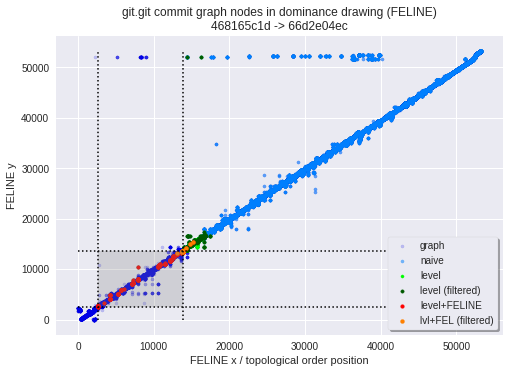

u=468165c1d position is (2591, 2590), level is 18418
v=66d2e04ec position is (13847, 13532), level is 14776
- naive walked 39590
- level walked 2491
- level+feline walked 233
there are 10893 nodes out of 53266 in inclusion zone


In [652]:
#@title git.git: src -> dst feline plot { form-width: "30%" }
graph=repo_graph_full
pos=graph.fel

plt.title('git.git commit graph nodes in dominance drawing (FELINE)\n'+
          ''+u+' -> '+v+'')
plt.xlabel('FELINE x / topological order position')
plt.ylabel('FELINE y')

show_levels = True #@param {type:"boolean"}
show_feline = True #@param {type:"boolean"}

ax=plt.gca()
ax.add_patch(
  mpatches.Rectangle(
    pos[u],
    pos[v][0] - pos[u][0],
    pos[v][1] - pos[u][1],
    facecolor="grey",alpha=0.25
  )
)

xarr = np.array([x for (x,y) in pos.values()])
yarr = np.array([y for (x,y) in pos.values()])
plt.vlines([pos[u][0],pos[v][0]],0,np.amax(yarr),lw=1.5,linestyles='dotted')
plt.hlines([pos[u][1],pos[v][1]],0,np.amax(xarr),lw=1.5,linestyles='dotted')
plt.scatter(x=xarr, y=yarr, s=10,
            c=(0.0,0.0,0.9,0.2), label='graph')

xarr = np.array([x for (n,(x,y)) in pos.items() if n in stats['naive']['walk']])
yarr = np.array([y for (n,(x,y)) in pos.items() if n in stats['naive']['walk']])
plt.scatter(x=xarr, y=yarr, s=10,
            c=(0.0,0.5,1.0,0.5), label='naive')

if show_levels:
  xarr = np.array([x for (n,(x,y)) in pos.items() if n in stats['level']['walk']])
  yarr = np.array([y for (n,(x,y)) in pos.items() if n in stats['level']['walk']])
  plt.scatter(x=xarr, y=yarr, s=10,
              c=(0.0,1.0,0.0,1.0), label='level')

  xarr = np.array([x for (n,(x,y)) in pos.items() if n in stats['level']['level-filter']])
  yarr = np.array([y for (n,(x,y)) in pos.items() if n in stats['level']['level-filter']])
  plt.scatter(x=xarr, y=yarr, s=12,
              c=(0.0,0.35,0.0,1.0), label='level (filtered)')
  
if show_feline:
  xarr = np.array([x for (n,(x,y)) in pos.items() if n in stats['level+feline']['walk']])
  yarr = np.array([y for (n,(x,y)) in pos.items() if n in stats['level+feline']['walk']])
  plt.scatter(x=xarr, y=yarr, s=14,
              c=(1.0,0.0,0.0,1.0), label='level+FELINE')
  
  xarr = np.array([x for (n,(x,y)) in pos.items()
                   if n in stats['level+feline']['level-filter'] or 
                      n in stats['level+feline']['feline-filter']])
  yarr = np.array([y for (n,(x,y)) in pos.items()
                   if n in stats['level+feline']['level-filter'] or 
                      n in stats['level+feline']['feline-filter']])
  plt.scatter(x=xarr, y=yarr, s=16,
              c=(1.0,0.5,0.0,1.0), label='lvl+FEL (filtered)')

plt.legend(frameon=True,fancybox=True,shadow=True)
plt.show()

print('u=%s position is %r, level is %d' % (u,pos[u],graph.lvl[u]))
print('v=%s position is %r, level is %d' % (v,pos[v],graph.lvl[v]))
for walk in sorted(stats, key=lambda k: len(stats[k]['walk']), reverse=True):
  print('- %s walked %d' % (walk, len(stats[walk]['walk'])))
  
gray_count = 0
for n in pos:
  if is_pair_leq(pos[u], pos[n]) and \
     is_pair_leq(pos[n], pos[v]):
    gray_count += 1
print('there are %d nodes out of %d in inclusion zone' %
      (gray_count, graph.number_of_nodes()))

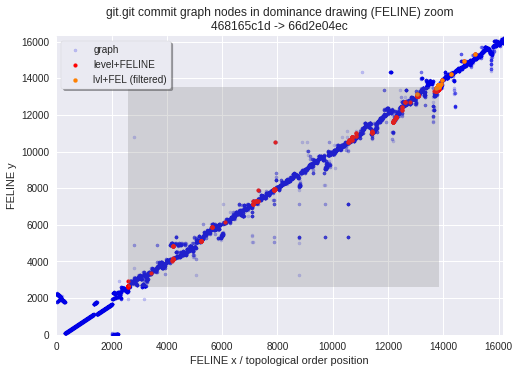

u=468165c1d position is (2591, 2590), level is 18418
v=66d2e04ec position is (13847, 13532), level is 14776
- naive walked 39590
- level walked 2491
- level+feline walked 233
there are 10893 nodes out of 53266 in inclusion zone


In [653]:
#@title git.git: src -> dst feline zoom { form-width: "30%" }
graph=repo_graph_full
pos=graph.fel

plt.title('git.git commit graph nodes in dominance drawing (FELINE) zoom\n'+
          ''+u+' -> '+v+'')
plt.xlabel('FELINE x / topological order position')
plt.ylabel('FELINE y')

ax=plt.gca()
ax.add_patch(
  mpatches.Rectangle(
    pos[u],
    pos[v][0] - pos[u][0],
    pos[v][1] - pos[u][1],
    facecolor="grey",alpha=0.25
  )
)

xarr = np.array([x for (x,y) in pos.values()])
yarr = np.array([y for (x,y) in pos.values()])
#plt.vlines([pos[u][0],pos[v][0]],0,np.amax(yarr),lw=1.5,linestyles='dotted')
#plt.hlines([pos[u][1],pos[v][1]],0,np.amax(xarr),lw=1.5,linestyles='dotted')
plt.scatter(x=xarr, y=yarr, s=10,
            c=(0.0,0.0,0.9,0.2), label='graph')

xarr = np.array([x for (n,(x,y)) in pos.items() if n in stats['level+feline']['walk']])
yarr = np.array([y for (n,(x,y)) in pos.items() if n in stats['level+feline']['walk']])
plt.scatter(x=xarr, y=yarr, s=14,
            c=(1.0,0.0,0.0,1.0), label='level+FELINE')

xmax = np.amax(xarr)
ymax = np.amax(yarr)

xarr = np.array([x for (n,(x,y)) in pos.items()
                 if n in stats['level+feline']['level-filter'] or 
                    n in stats['level+feline']['feline-filter']])
yarr = np.array([y for (n,(x,y)) in pos.items()
                 if n in stats['level+feline']['level-filter'] or 
                    n in stats['level+feline']['feline-filter']])
plt.scatter(x=xarr, y=yarr, s=16,
            c=(1.0,0.5,0.0,1.0), label='lvl+FEL (filtered)')

plt.legend(frameon=True,fancybox=True,shadow=True)
ax.set_xlim(0,xmax+1000)
ax.set_ylim(0,ymax+1000)
plt.show()

print('u=%s position is %r, level is %d' % (u,pos[u],graph.lvl[u]))
print('v=%s position is %r, level is %d' % (v,pos[v],graph.lvl[v]))
for walk in sorted(stats, key=lambda k: len(stats[k]['walk']), reverse=True):
  print('- %s walked %d' % (walk, len(stats[walk]['walk'])))
  
gray_count = 0
for n in pos:
  if is_pair_leq(pos[u], pos[n]) and \
     is_pair_leq(pos[n], pos[v]):
    gray_count += 1
print('there are %d nodes out of %d in inclusion zone' %
      (gray_count, graph.number_of_nodes()))

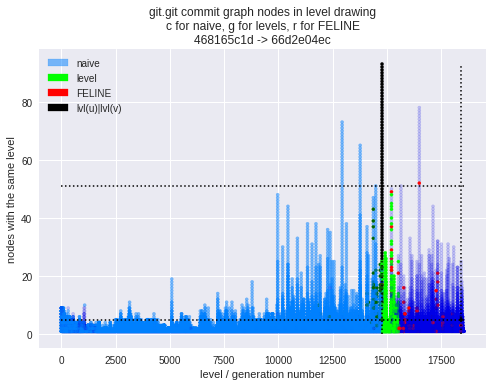

u=468165c1d position is (18418, 5), level is 18418
v=66d2e04ec position is (14776, 51), level is 14776
- naive walked 39590
- level walked 2491
- level+feline walked 233


In [654]:
graph = repo_graph_full

level_counts_dict = defaultdict(int)
graph.lvlpos = {}
for node in graph:
  x = graph.lvl[node]
  level_counts_dict[x] += 1
  y = level_counts_dict[x]
  
  graph.lvlpos[node] = (x, y)
  
pos = graph.lvlpos

plt.title('git.git commit graph nodes in level drawing\n'+
          'c for naive, g for levels, r for FELINE\n'+
          ''+u+' -> '+v+'')
plt.xlabel('level / generation number')
plt.ylabel('nodes with the same level')
plt.legend(handles=[mpatches.Patch(color=(0.0,0.5,1.0,0.5), label='naive'),
                    mpatches.Patch(color=(0.0,1.0,0.0,1.0), label='level'),
                    mpatches.Patch(color=(1.0,0.0,0.0,1.0), label='FELINE'),
                    mpatches.Patch(color=(0.0,0.0,0.0,1.0), label='lvl(u)|lvl(v)')],
           loc='upper left')
xarr = np.array([x for (x,y) in pos.values()])
yarr = np.array([y for (x,y) in pos.values()])
plt.vlines([pos[u][0],pos[v][0]],0,np.amax(yarr),lw=1.5,linestyles='dotted')
plt.hlines([pos[u][1],pos[v][1]],0,np.amax(xarr),lw=1.5,linestyles='dotted')
plt.scatter(x=xarr,
            y=yarr,
            c=color,s=10)
plt.show()
#print(color)
print('u=%s position is %r, level is %d' % (u,pos[u],graph.lvl[u]))
print('v=%s position is %r, level is %d' % (v,pos[v],graph.lvl[v]))
for walk in sorted(stats, key=lambda k: len(stats[k]['walk']), reverse=True):
  print('- %s walked %d' % (walk, len(stats[walk]['walk'])))

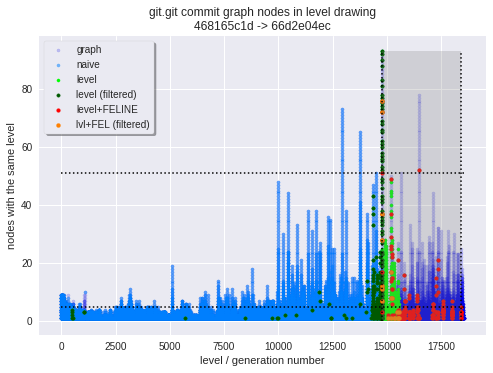

u=468165c1d position is (18418, 5), level is 18418
v=66d2e04ec position is (14776, 51), level is 14776
- naive walked 39590
- level walked 2491
- level+feline walked 233
there are 13575 nodes out of 53266 in inclusion zone


In [655]:
#@title git.git: src -> dst levels plot { form-width: "30%" }
graph=repo_graph_full
pos=graph.lvlpos

plt.title('git.git commit graph nodes in level drawing\n'+
          ''+u+' -> '+v+'')
plt.xlabel('level / generation number')
plt.ylabel('nodes with the same level')

show_levels = True #@param {type:"boolean"}
show_feline = True #@param {type:"boolean"}

xarr = np.array([x for (x,y) in pos.values()])
yarr = np.array([y for (x,y) in pos.values()])

ax=plt.gca()
ax.add_patch(
  mpatches.Rectangle(
    (pos[u][0], 0),
    pos[v][0] - pos[u][0],
    np.amax(yarr),
    facecolor="grey",alpha=0.25
  )
)

plt.vlines([pos[u][0],pos[v][0]],0,np.amax(yarr),lw=1.5,linestyles='dotted')
plt.hlines([pos[u][1],pos[v][1]],0,np.amax(xarr),lw=1.5,linestyles='dotted')
plt.scatter(x=xarr, y=yarr, s=10,
            c=(0.0,0.0,0.9,0.2), label='graph')

xarr = np.array([x for (n,(x,y)) in pos.items() if n in stats['naive']['walk']])
yarr = np.array([y for (n,(x,y)) in pos.items() if n in stats['naive']['walk']])
plt.scatter(x=xarr, y=yarr, s=10,
            c=(0.0,0.5,1.0,0.5), label='naive')

if show_levels:
  xarr = np.array([x for (n,(x,y)) in pos.items() if n in stats['level']['walk']])
  yarr = np.array([y for (n,(x,y)) in pos.items() if n in stats['level']['walk']])
  plt.scatter(x=xarr, y=yarr, s=10,
              c=(0.0,1.0,0.0,1.0), label='level')

  xarr = np.array([x for (n,(x,y)) in pos.items() if n in stats['level']['level-filter']])
  yarr = np.array([y for (n,(x,y)) in pos.items() if n in stats['level']['level-filter']])
  plt.scatter(x=xarr, y=yarr, s=12,
              c=(0.0,0.35,0.0,1.0), label='level (filtered)')
  
if show_feline:
  xarr = np.array([x for (n,(x,y)) in pos.items() if n in stats['level+feline']['walk']])
  yarr = np.array([y for (n,(x,y)) in pos.items() if n in stats['level+feline']['walk']])
  plt.scatter(x=xarr, y=yarr, s=14,
              c=(1.0,0.0,0.0,1.0), label='level+FELINE')
  
  xarr = np.array([x for (n,(x,y)) in pos.items()
                   if n in stats['level+feline']['level-filter'] or 
                      n in stats['level+feline']['feline-filter']])
  yarr = np.array([y for (n,(x,y)) in pos.items()
                   if n in stats['level+feline']['level-filter'] or 
                      n in stats['level+feline']['feline-filter']])
  plt.scatter(x=xarr, y=yarr, s=16,
              c=(1.0,0.5,0.0,1.0), label='lvl+FEL (filtered)')

plt.legend(frameon=True,fancybox=True,shadow=True)
plt.show()

print('u=%s position is %r, level is %d' % (u,pos[u],graph.lvl[u]))
print('v=%s position is %r, level is %d' % (v,pos[v],graph.lvl[v]))
for walk in sorted(stats, key=lambda k: len(stats[k]['walk']), reverse=True):
  print('- %s walked %d' % (walk, len(stats[walk]['walk'])))
  
  
gray_count = 0
for n in pos:
  if graph.lvl[u] >= graph.lvl[n] and \
     graph.lvl[n] >= graph.lvl[v]:
    gray_count += 1
print('there are %d nodes out of %d in inclusion zone' %
      (gray_count, graph.number_of_nodes()))

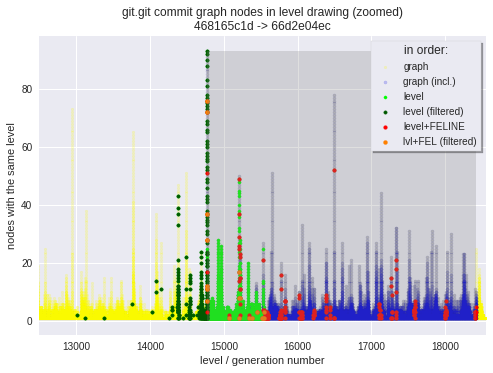

u=468165c1d position is (18418, 5), level is 18418
v=66d2e04ec position is (14776, 51), level is 14776
- naive walked 39590
- level walked 2491
- level+feline walked 233
there are 13575 nodes out of 53266 in inclusion zone


In [656]:
#@title git.git: src -> dst levels zoom { form-width: "30%" }
graph=repo_graph_full
pos=graph.lvlpos

plt.title('git.git commit graph nodes in level drawing (zoomed)\n'+
          ''+u+' -> '+v+'')
plt.xlabel('level / generation number')
plt.ylabel('nodes with the same level')

show_levels = True #@param {type:"boolean"}
show_feline = True #@param {type:"boolean"}
xmin_plot = 12500 #@param {type:"slider", min:0, max:14776, step:1}

xarr = np.array([x for (x,y) in pos.values()])
yarr = np.array([y for (x,y) in pos.values()])

ax=plt.gca()
ax.add_patch(
  mpatches.Rectangle(
    (pos[u][0], 0),
    pos[v][0] - pos[u][0],
    np.amax(yarr),
    facecolor="grey",alpha=0.25
  )
)

plt.scatter(x=xarr, y=yarr, s=8,
            c=(1.0,1.0,0.0,0.2), label='graph')

node_test = lambda n: \
  graph.lvl[u] >= graph.lvl[n] and \
  graph.lvl[n] >= graph.lvl[v]
xarr = np.array([x for (n,(x,y)) in pos.items()
                 if node_test(n)])
yarr = np.array([y for (n,(x,y)) in pos.items()
                 if node_test(n)])

#plt.vlines([pos[u][0],pos[v][0]],0,np.amax(yarr),lw=1.5,linestyles='dotted')
#plt.hlines([pos[u][1],pos[v][1]],0,np.amax(xarr),lw=1.5,linestyles='dotted')
plt.scatter(x=xarr, y=yarr, s=10,
            c=(0.0,0.0,0.9,0.2), label='graph (incl.)')

if show_levels:
  xarr = np.array([x for (n,(x,y)) in pos.items()
                   if n in stats['level']['walk']])
  yarr = np.array([y for (n,(x,y)) in pos.items()
                   if n in stats['level']['walk']])
  plt.scatter(x=xarr, y=yarr, s=10,
              c=(0.0,1.0,0.0,1.0), label='level')

  xarr = np.array([x for (n,(x,y)) in pos.items()
                   if n in stats['level']['level-filter']])
  yarr = np.array([y for (n,(x,y)) in pos.items()
                   if n in stats['level']['level-filter']])
  plt.scatter(x=xarr, y=yarr, s=12,
              c=(0.0,0.35,0.0,1.0), label='level (filtered)')
  
if show_feline:
  xarr = np.array([x for (n,(x,y)) in pos.items() if n in stats['level+feline']['walk']])
  yarr = np.array([y for (n,(x,y)) in pos.items() if n in stats['level+feline']['walk']])
  plt.scatter(x=xarr, y=yarr, s=14,
              c=(1.0,0.0,0.0,1.0), label='level+FELINE')
  
  xarr = np.array([x for (n,(x,y)) in pos.items()
                   if n in stats['level+feline']['level-filter'] or 
                      n in stats['level+feline']['feline-filter']])
  yarr = np.array([y for (n,(x,y)) in pos.items()
                   if n in stats['level+feline']['level-filter'] or 
                      n in stats['level+feline']['feline-filter']])
  plt.scatter(x=xarr, y=yarr, s=16,
              c=(1.0,0.5,0.0,1.0), label='lvl+FEL (filtered)')

plt.legend(frameon=True,fancybox=False,shadow=True,
           title='in order:')
ax.set_xlim(12500,max(graph.lvl.values()))
plt.show()

print('u=%s position is %r, level is %d' % (u,pos[u],graph.lvl[u]))
print('v=%s position is %r, level is %d' % (v,pos[v],graph.lvl[v]))
for walk in sorted(stats, key=lambda k: len(stats[k]['walk']), reverse=True):
  print('- %s walked %d' % (walk, len(stats[walk]['walk'])))
  
  
gray_count = 0
for n in pos:
  if graph.lvl[u] >= graph.lvl[n] and \
     graph.lvl[n] >= graph.lvl[v]:
    gray_count += 1
print('there are %d nodes out of %d in inclusion zone' %
      (gray_count, graph.number_of_nodes()))

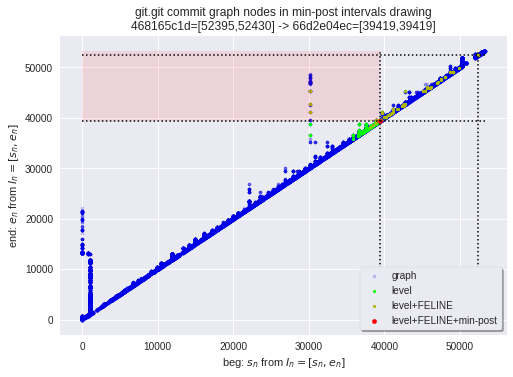

In [657]:
#@title git.git: src -> dst min-post plot { form-width: "30%" }
graph=repo_graph_full
pos=graph.mpi

plt.title('git.git commit graph nodes in min-post intervals drawing\n'+
          u+'=['+str(pos[u][0])+','+str(pos[u][1])+'] -> '+
          v+'=['+str(pos[v][0])+','+str(pos[v][1])+']')
plt.xlabel('beg: $s_n$ from $I_n = [s_n, e_n]$')
plt.ylabel('end: $e_n$ from $I_n = [s_n, e_n]$')

xarr = np.array([x for (x,y) in pos.values()])
yarr = np.array([y for (x,y) in pos.values()])

ax=plt.gca()
ax.add_patch(
  mpatches.Rectangle(
    pos[v],
    - pos[v][0],
    np.amax(yarr) - pos[v][1],
    facecolor="red",alpha=0.10
  )
)

plt.vlines([pos[u][0],pos[v][0]],0,np.amax(yarr),lw=1.5,linestyles='dotted')
plt.hlines([pos[u][1],pos[v][1]],0,np.amax(xarr),lw=1.5,linestyles='dotted')
plt.scatter(x=xarr, y=yarr, s=10,
            c=(0.0,0.0,0.9,0.2), label='graph')

xarr = np.array([x for (n,(x,y)) in pos.items()
                 if n in stats['level']['walk']])
yarr = np.array([y for (n,(x,y)) in pos.items()
                 if n in stats['level']['walk']])
plt.scatter(x=xarr, y=yarr, s=8,
            c=(0.0,1.0,0.0,1.0), label='level')

xarr = np.array([x for (n,(x,y)) in pos.items()
                 if n in stats['level+feline']['walk']])
yarr = np.array([y for (n,(x,y)) in pos.items()
                 if n in stats['level+feline']['walk']])
plt.scatter(x=xarr, y=yarr, s=8,
            c=(0.7,0.7,0.0,1.0), label='level+FELINE')

xarr = np.array([x for (n,(x,y)) in pos.items()
                 if n in stats_x['lvl+feline+mpi']['walk']])
yarr = np.array([y for (n,(x,y)) in pos.items()
                 if n in stats_x['lvl+feline+mpi']['walk']])
plt.scatter(x=xarr, y=yarr, s=20,
            c=(1.0,0.0,0.0,1.0), label='level+FELINE+min-post')

plt.legend(frameon=True,fancybox=True,shadow=True)
plt.show()

Here the commit marked as walked 'level+FELINE+min-post' (using <span style="text-color: red;">**red**</span> color) that is in the light-red area for target commit $v$ is the one that positive-cut of min-post interval filter finds as being child of $v$.

#### N^2 connectivity on \[random sample of\] commit graph nodes

In [658]:
import datetime
print('date = %s' % datetime.datetime.now())

graph = repo_graph

#print('git commit graph was created from %d edges' % (len(edges)))
n_nodes = graph.number_of_nodes()
print('git commit graph has %d nodes and %d edges (size)' %
      (n_nodes, graph.size()))
print('git commit graph has %d possible paths\n' % (n_nodes*(n_nodes-1)))

if False:
  %time graph.lvl = find_levels(graph)
  %time graph.fel = find_feline(graph)

  %time lvl_fp = level_fp(graph, graph.lvl)
  %time fel_fp = feline_fp(graph, graph.fel)

  n_lvl_fp = len(lvl_fp)
  n_fel_fp = len(fel_fp)
  print('\nlevel-filter has %5d = %5.2f%% false positives' %
        (n_lvl_fp, 100.0*n_lvl_fp/(n_nodes*(n_nodes-1))))
  print('FELINE index has %5d = %5.2f%% false positives' %
        (n_fel_fp, 100.0*n_fel_fp/(n_nodes*(n_nodes-1))))

date = 2018-05-01 14:19:16.277004
git commit graph has 26 nodes and 26 edges (size)
git commit graph has 650 possible paths



In [659]:
print('repo_graph_full (for git.git)')
graph = repo_graph_full

print('git commit graph was created from %d edges' % (len(edges)))
n_nodes_full = graph.number_of_nodes()
print('git commit graph has %d nodes and %d edges (size)' %
      (n_nodes_full, graph.size()))
print('git commit graph has %d possible paths\n' % (n_nodes*(n_nodes-1)))

repo_graph_full (for git.git)
git commit graph was created from 66309 edges
git commit graph has 53266 nodes and 66309 edges (size)
git commit graph has 650 possible paths



In [660]:
%time conns = [(u,v) for u in repo_graph_x for v in repo_graph_x if u != v]
print('possible connections in repo_graph_x = %d' % len(conns))
conns[:10]

CPU times: user 0 ns, sys: 1 ms, total: 1 ms
Wall time: 919 µs
possible connections in repo_graph_x = 2352


[('cf98a52ba', '0210231b0'),
 ('cf98a52ba', '79f62e7dd'),
 ('cf98a52ba', '2a1fd8217'),
 ('cf98a52ba', '23f875f6b'),
 ('cf98a52ba', '8b44b2be8'),
 ('cf98a52ba', '3bb0923f0'),
 ('cf98a52ba', '31076c52a'),
 ('cf98a52ba', '969e05fae'),
 ('cf98a52ba', '427cbc9db'),
 ('cf98a52ba', 'f68f2dd57')]

In [661]:
import numpy as np
choice = np.random.choice(n_nodes_full*n_nodes_full, 10000)
conn_choice = [(x % n_nodes_full,x // n_nodes_full) for x in choice]
print choice[:10]
print conn_choice[:10]


[1147880944 2454793829  463187809 1023827141  841473495 1362889826
  709767948   57711245 1606526438 1618858045]
[(51910, 21549), (30219, 46085), (39939, 8695), (1355, 19221), (30493, 15797), (25950, 25586), (51764, 13324), (24167, 1083), (23878, 30160), (51039, 30391)]


In [0]:
nodes_dict = {num: v for (num,v) in enumerate(list(repo_graph_full))}
conn_nodes = {(nodes_dict[u], nodes_dict[v]) for (u,v) in conn_choice}
#conn_nodes

In [0]:
#@title def split_connected { form-width: "25%" }
def split_connected(DG, conn):
  has = []
  hasnot = []
  
  for (u,v) in conn:
    if u == v:
      continue
    if nx.has_path(DG,u,v):
      has.append((u,v))
    else:
      hasnot.append((u,v))
      
  return has, hasnot

def split_connected_ex(DG, conn):
  has = []
  hasnot = []
  r = {}
  for (u,v) in conn:
    if u == v:
      r[(u,v)] = True
      continue
    if nx.has_path(DG,u,v):
      r[(u,v)] = True
      has.append((u,v))
    else:
      r[(u,v)] = False
      hasnot.append((u,v))
      
  return has, hasnot, r

In [664]:
#@title git.git: run split_connected { form-width: "25%" }

%time pos,neg = split_connected(repo_graph_full, conn_nodes)
print('%4d nodes' % len(conn_nodes))
print('%4d connected:     %r' % (len(pos), pos[:10]))
print('%4d not connected: %r' % (len(neg), neg[:10]))

CPU times: user 1min 49s, sys: 0 ns, total: 1min 49s
Wall time: 1min 50s
10000 nodes
4489 connected:     [('8642abc76', '9c20a4706'), ('8ffc33135', 'f53d39778'), ('15dc3b916', '9760adccc'), ('577dfd030', '8bb45b25b'), ('42f939e47', '0a7a9a12d'), ('cbcd2cbd5', '71ee7fd15'), ('6ecfd91df', '53a291a43'), ('715fc7613', 'f14acabf3'), ('2247b45c6', '0cc6d3464'), ('a279b74c6', 'ad874608d')]
5511 not connected: [('8cc6a0831', 'ad57ef9da'), ('48cbf915a', 'a28705da9'), ('86e4ca69e', '5bf6529aa'), ('9969b6499', '6538d1ef3'), ('6b3c4c054', '636161555'), ('c2c487cf3', '03a2b6eff'), ('b549be0da', '2184d4ba0'), ('d6678c28e', '2dc53617a'), ('f6f00b46a', '93dd544f5'), ('6fc301bbf', '9845bbba9')]


In [665]:
graph = repo_graph_full

print('git commit graph was created from %d edges' % (len(edges)))
n_nodes = graph.number_of_nodes()
print('git commit graph has %d nodes and %d edges (size)' %
      (n_nodes, graph.size()))
print('git commit graph has %d possible paths\n' % (n_nodes*(n_nodes-1)))
print('sample has %d nodes: %d connected and %d not' %
      (len(conn_nodes),len(pos),len(neg)))

%time graph.lvl = find_levels(graph)
%time graph.fel = find_feline(graph)

git commit graph was created from 66309 edges
git commit graph has 53266 nodes and 66309 edges (size)
git commit graph has 2837213490 possible paths

sample has 10000 nodes: 4489 connected and 5511 not
CPU times: user 867 ms, sys: 2 ms, total: 869 ms
Wall time: 870 ms
CPU times: user 865 ms, sys: 3 ms, total: 868 ms
Wall time: 868 ms


In [666]:
graph = repo_graph_full

heads = find_heads(graph)
roots = find_roots(graph)
print('git commit graph has %d tips / heads ("roots"): %r' % (len(heads),heads))
print('git commit graph has %d roots ("leaves"): %r' % (len(roots),roots))

print('git commit graph has average clustering coefficient %g (%d trials ?)' %
      (nx.average_clustering(graph.to_undirected()), 1000))
#print('git commit graph has the diameter of %g' % nx.diameter(graph))

git commit graph has 4 tips / heads ("roots"): ['4582c99ba', 'fedc7d545', '75df6e6af', '2c687f8fa']
git commit graph has 9 roots ("leaves"): ['16d6b8ab6', '1bd90415d', '0ca71b373', 'cb07fc2a2', 'e83c51633', '161332a52', '1db95b00a', '2744b2344', '7d77f2e9c']
git commit graph has average clustering coefficient 0.000408157 (1000 trials ?)


In [667]:
#@title git.git: false positives in random sample { form-width: "25%" }
graph = repo_graph_full

print('git commit graph was created from %d edges' % (len(edges)))
n_nodes = graph.number_of_nodes()
print('git commit graph has %d nodes and %d edges (size)' %
      (n_nodes, graph.size()))
print('git commit graph has %d possible paths\n' % (n_nodes*(n_nodes-1)))
print('sample has %d nodes [%g%%]: %d connected and %d not\n' %
      (len(conn_nodes),100.0*len(conn_nodes)/(n_nodes*(n_nodes-1)),
       len(pos),len(neg)))

%time lvl_fp = level_fp_sample(graph, graph.lvl, neg)
%time fel_fp = feline_fp_sample(graph, graph.fel, neg)

n_lvl_fp = len(lvl_fp)
n_fel_fp = len(fel_fp)
n_samples = len(neg)
print('\nlevel-filter has %5d = %5.2f%% false positives' %
      (n_lvl_fp, 100.0*n_lvl_fp/n_samples))
print('FELINE index has %5d = %5.2f%% false positives' %
      (n_fel_fp, 100.0*n_fel_fp/n_samples))
print('FELINE index has %g less false positives than level filter' %
      (float(n_lvl_fp)/float(n_fel_fp)))

git commit graph was created from 66309 edges
git commit graph has 53266 nodes and 66309 edges (size)
git commit graph has 2837213490 possible paths

sample has 10000 nodes [0.000352458%]: 4489 connected and 5511 not

CPU times: user 3.86 s, sys: 2 ms, total: 3.86 s
Wall time: 3.87 s
CPU times: user 2.48 s, sys: 1e+03 µs, total: 2.48 s
Wall time: 2.48 s

level-filter has   470 =  8.53% false positives
FELINE index has   455 =  8.26% false positives
FELINE index has 1.03297 less false positives than level filter


### Linux kernel commit graph

In [668]:
import git
git

<module 'git' from '/usr/local/lib/python2.7/dist-packages/git/__init__.pyc'>

In [0]:
%%time
!git clone https://git.kernel.org/pub/scm/linux/kernel/git/torvalds/linux.git

Cloning into 'linux'...
remote: Counting objects: 6010383, done.
remote: Compressing objects: 100% (241/241), done.
remote: Total 6010383 (delta 164), reused 115 (delta 67)
Receiving objects: 100% (6010383/6010383), 1.00 GiB | 21.81 MiB/s, done.


In [122]:
linux_repo = git.Repo('linux')
linux_repo

<git.Repo "/content/linux/.git">

#### Full linux kernel commit graph and its properties

In [123]:
%%time
!git -C linux log --format="%h %p" --all --topo-order >linux-commit_list_full

edges = []
with open('linux-commit_list_full', 'r') as f:
  for line in f:
    elems = line.split()
    commit, parents = (elems[0], elems[1:])
    for parent in parents:
      edges.append((commit, parent))
linux_graph_full = nx.DiGraph(edges)

CPU times: user 8.33 s, sys: 1.51 s, total: 9.84 s
Wall time: 24 s


In [124]:
%%time
graph = linux_graph_full

print('linux commit graph was created from %d edges' % (len(edges)))
n_nodes = graph.number_of_nodes()
print('linux commit graph has %d nodes and %d edges (size)' %
      (n_nodes, graph.size()))
print('linux commit graph has %d possible paths\n' % (n_nodes*(n_nodes-1)))

print('\ncalculating levels')
%time graph.lvl = find_levels(graph)
print('\ncalculating FELINE index')
%time graph.fel = find_feline(graph)
print('\nfind min-post intervals:')
%time graph.mpi = find_dfs_intervals(graph)
print('\nfind min-post intervals with extra data:')
%time graph.mpi_x = find_dfs_intervals_extra(graph)

linux commit graph was created from 813898 edges
linux commit graph has 752749 nodes and 813894 edges (size)
linux commit graph has 566630304252 possible paths


calculating levels
CPU times: user 12.9 s, sys: 238 ms, total: 13.2 s
Wall time: 13.2 s

calculating FELINE index
CPU times: user 13.4 s, sys: 603 ms, total: 14 s
Wall time: 14 s

find min-post intervals:
CPU times: user 22.3 s, sys: 1.37 s, total: 23.6 s
Wall time: 23.6 s

find min-post intervals with extra data:
CPU times: user 24.4 s, sys: 1.04 s, total: 25.4 s
Wall time: 25.4 s
CPU times: user 1min 13s, sys: 3.25 s, total: 1min 17s
Wall time: 1min 17s


In [125]:
%%time

graph = linux_graph_full
graph_name = 'linux kernel'

n_nodes = graph.number_of_nodes()
n_edges = graph.size()
print('%s commit graph has %d nodes and %d edges (size)' %
      (graph_name, n_nodes, n_edges))
print('%s commit graph has %d possible paths\n' %
      (graph_name, n_nodes*(n_nodes-1)))

heads = find_heads(graph)
roots = find_roots(graph)
print('%s commit graph has %d tips / heads ("roots"): %r' %
      (graph_name, len(heads),heads))
print('%s commit graph has %d roots ("leaves"): %r' %
      (graph_name, len(roots),roots))

clustering_coeff = nx.average_clustering(graph.to_undirected())
print('%s commit graph has average clustering coefficient %g (%d trials ?)\n' %
      (graph_name, clustering_coeff, 1000))
# NetworkXError: Found infinite path length because the digraph is not strongly connected
#print('%s commit graph has the diameter of %g\n' %
#      (graph_name, nx.diameter(graph)))

linux_df = pd.DataFrame({
    'Graph': [graph_name],
    'vertices': [n_nodes],
    'edges': [n_edges],
    'Cluster coeff.': [clustering_coeff],
    'roots': [len(heads)],
    'leafs': [len(roots)],
},columns=['Graph','vertices','edges',
           'Cluster coeff.','Eff. diameter',
           'roots','leafs']).set_index('Graph')

linux kernel commit graph has 752749 nodes and 813894 edges (size)
linux kernel commit graph has 566630304252 possible paths

linux kernel commit graph has 1 tips / heads ("roots"): ['6da6c0db5316']
linux kernel commit graph has 4 roots ("leaves"): ['a101ad945113', '1da177e4c3f4', 'be0e5c097fc2', 'cd26f1bd6bf3']
linux kernel commit graph has average clustering coefficient 0.000317817 (1000 trials ?)

CPU times: user 38.3 s, sys: 552 ms, total: 38.8 s
Wall time: 38.9 s


In [126]:
#@title linux commit graph dataset { form-width: "25%" }
df=linux_df

df.insert(loc=2,column='edges[%]',
          value=100.0*(df['edges']/(df['vertices']**2)))
df.insert(loc=3,column='edges/vertices',
          value=df['edges']/df['vertices'])
df

,vertices,edges,edges[%],edges/vertices,Cluster coeff.,Eff. diameter,roots,leafs
Graph,,,,,,,,
linux kernel,752749,813894,0.000144,1.081229,0.000318,NaN,1,4


In [0]:
commit_graphs_df.append(linux_df)

,vertices,edges,edges[%],edges/vertices,Cluster coeff.,Eff. diameter,roots,leafs
Graph,,,,,,,,
git.git,53128,66124,0.002343,1.244617,0.000409,NaN,4,9
linux kernel,752282,813354,0.000144,1.081182,0.000318,NaN,1,4


In [0]:
table_1

,vertices,edges,edges[%],edges/vertices,Cluster coeff.,Eff. diameter,roots,leafs
Graph,,,,,,,,
arXiv,6000,66707,0.185297,11.117833,0.35,5.48,961,624
Yago,6642,42392,0.096092,6.382415,0.24,6.57,5176,263
Go,6793,13361,0.028954,1.966878,0.07,10.92,64,3087
Pubmed,9000,40028,0.049417,4.447556,0.10,6.32,2609,4702
citeseer,10720,44258,0.038513,4.128545,0.28,8.36,4572,1868
Uniprot22m,1595444,1595442,0.000063,0.999999,0.00,3.30,1556157,1
Cit-patents,3774768,16518047,0.000116,4.375911,0.09,10.50,515785,1685423
citeseerx,6540401,15011260,0.000035,2.295159,0.06,8.40,567149,5740710
Go-uniprot,6967956,34770235,0.000072,4.990019,0.00,4.80,6945721,4


In [127]:
# calculating parameters of the linux commit graph: distribution of in-degree, out-degree and level
graph = linux_graph_full

linux_info_df=pd.DataFrame.from_dict(graph.lvl,orient='index').rename(columns={0: 'level'})
linux_info_df.index.name='node'
if hasattr(graph, 'fel'):
  linux_info_df['FELINE']=pd.Series(graph.fel)
if hasattr(graph, 'mpi'):
  linux_info_df['min-post']=pd.Series(graph.mpi)
linux_info_df['in  degree']=pd.Series(dict(graph.in_degree()))
linux_info_df['out degree']=pd.Series(dict(graph.out_degree()))
linux_info_df.head()

,level,FELINE,min-post,in degree,out degree
node,,,,,
e6db1119318a,28491,"(696589, 696525)","[56062, 56160]",1,1
cb026e398852,124513,"(111421, 111090)","[146068, 633253]",1,1
159793001d7d,98470,"(325138, 317086)","[427602, 427611]",1,1
8a77b8d0744a,67794,"(565090, 564954)","[187654, 187659]",1,1
944ea4dd38b8,89753,"(393864, 395379)","[358854, 358885]",1,1


In [128]:
linux_info_df.describe()

,level,in degree,out degree
count,752749.000000,752749.000000,752749.000000
mean,87862.921761,1.081229,1.081229
std,34304.489238,2.139424,0.352181
min,0.000000,0.000000,0.000000
25%,67921.000000,1.000000,1.000000
50%,91621.000000,1.000000,1.000000
75%,116566.000000,1.000000,1.000000
max,138685.000000,527.000000,66.000000


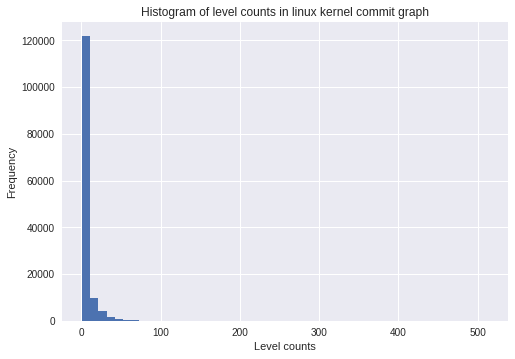

In [129]:
#@title linux kernel level counts hist { form-width: "30%" }
linux_level_counts=linux_info_df['level'].value_counts()
linux_level_counts_values=linux_level_counts.values

plt.title('Histogram of level counts in linux kernel commit graph')
plt.xlabel('Level counts')
plt.ylabel('Number of level with given count')
linux_level_counts.plot.hist(bins=50)
plt.show()

In [130]:
pd.DataFrame({'level counts':linux_level_counts.describe()})

,level counts
count,138686.000000
mean,5.427722
std,10.699336
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,513.000000


In [146]:
pd.DataFrame({'level counts': {'MAD':linux_level_counts.mad()}})

,level counts
MAD,5.345756


,count,mean,std,min,25%,50%,75%,max
level counts,138686.0,5.427722,10.699336,1.0,1.0,2.0,5.0,513.0


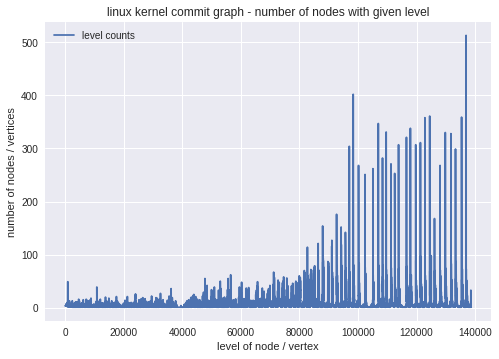

In [132]:
#@title linux kernel levels count plot { form-width: "30%" }
import seaborn as sns
sns.set()

linux_level_counts_df=pd.DataFrame({'level counts': linux_level_counts})
linux_level_counts_df.index.name='level'
linux_level_counts_df.sort_index(inplace=True)
linux_level_counts_df.plot();

plt.title('%s commit graph - number of nodes with given level' %
          'linux kernel');
plt.xlabel('level of node / vertex');
plt.ylabel('number of nodes / vertices');

linux_level_counts_df.describe().T.rename(index={'counts': 'level counts'})

CPU times: user 11.2 s, sys: 172 ms, total: 11.3 s
Wall time: 11.2 s


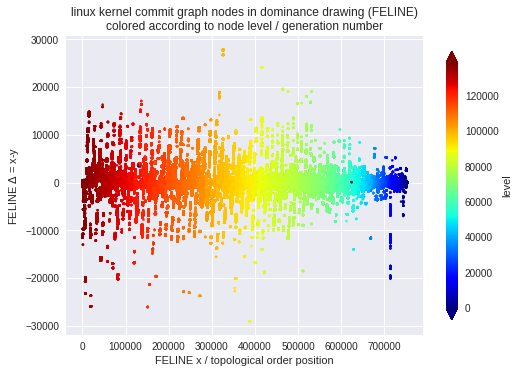

In [133]:
#@title linux kernel feline plot, skewed { form-width: "30%" }
%%time
graph=linux_graph_full
pos=graph.fel

plt.title('linux kernel commit graph nodes in dominance drawing (FELINE)\n'+
          'colored according to node level / generation number')
plt.xlabel('FELINE x / topological order position')
plt.ylabel('FELINE $\Delta$ = x-y')


xarr = np.array([x for (x,y) in pos.values()])
yarr = np.array([(x-y) for (x,y) in pos.values()])
larr = np.array([graph.lvl[n] for n in pos.keys()])

ax = plt.gca()
sc = plt.scatter(x=xarr, y=yarr,
                 c=larr, cmap=plt.cm.jet,
                 s=5,
                 label='graph')
cbar = plt.colorbar(sc, extend='both', shrink=0.9, ax=ax)
cbar.set_label('level')
plt.draw()

CPU times: user 11.1 s, sys: 221 ms, total: 11.4 s
Wall time: 11.2 s


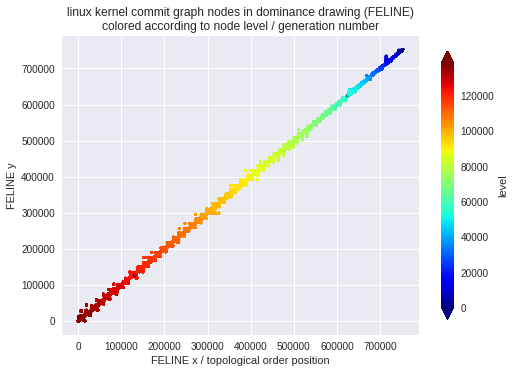

In [134]:
#@title linux kernel feline plot { form-width: "30%" }
%%time
graph=linux_graph_full
pos=graph.fel

plt.title('linux kernel commit graph nodes in dominance drawing (FELINE)\n'+
          'colored according to node level / generation number')
plt.xlabel('FELINE x / topological order position')
plt.ylabel('FELINE y')


xarr = np.array([x for (x,y) in pos.values()])
yarr = np.array([y for (x,y) in pos.values()])
larr = np.array([graph.lvl[n] for n in pos.keys()])

ax = plt.gca()
sc = plt.scatter(x=xarr, y=yarr,
                 c=larr, cmap=plt.cm.jet,
                 s=5,
                 label='graph')
cbar = plt.colorbar(sc, extend='both', shrink=0.9, ax=ax)
cbar.set_label('level')
plt.draw()

CPU times: user 12.3 s, sys: 279 ms, total: 12.6 s
Wall time: 12.4 s


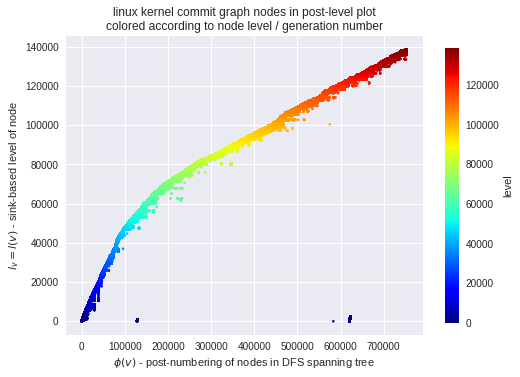

In [138]:
#@title linux kernel post-levels plot { form-width: "30%" }
%%time
graph=linux_graph_full
pos={v: (graph.mpi_x[v]['post'], graph.lvl[v])
     for v in graph}

plt.title('linux kernel commit graph nodes in post-level plot\n'+
          'colored according to node level / generation number')

plt.xlabel('$\phi(v)$ - post-numbering of nodes in DFS spanning tree')
plt.ylabel('$l_v = l(v)$ - sink-based level of node')

xarr = np.array([x for (x,y) in pos.values()])
yarr = np.array([y for (x,y) in pos.values()])
larr = np.array([graph.lvl[n] for n in pos.keys()])

ax = plt.gca()
sc = plt.scatter(x=xarr, y=yarr,
                 c=larr, cmap=plt.cm.jet,
                 s=5,
                 label='graph')
cbar = plt.colorbar(sc, extend='neither', shrink=0.92, ax=ax)
cbar.set_label('level')
plt.draw()

#### Finding paths / checking reachability between two commits

In [139]:
%%time
graph = linux_graph_full

print('max level in linux kernel commit graph is %d (out of %d nodes)' % 
      (max(graph.lvl.values()),graph.number_of_nodes()))

max level in linux kernel commit graph is 138685 (out of 752749 nodes)
CPU times: user 90 ms, sys: 0 ns, total: 90 ms
Wall time: 90.4 ms


In [140]:
#print sorted(linux_repo.tags,key=lambda x: x.tag.tag,reverse=True)[:20]
hex1 = linux_repo.tag('refs/tags/v4.9').tag.object.hexsha
print('%s: %r' % ('v4.9', [n for n in linux_graph_full if hex1.startswith(n)]))
hex2 = linux_repo.tag('refs/tags/v4.9-rc5').tag.object.hexsha
print('%s: %r' % ('v4.9-rc5', [n for n in linux_graph_full if hex2.startswith(n)]))
hex3 = linux_repo.tag('refs/tags/v4.8').tag.object.hexsha
print('%s: %r' % ('v4.8', [n for n in linux_graph_full if hex3.startswith(n)]))

v4.9: ['69973b830859']
v4.9-rc5: ['a25f0944ba9b']
v4.8: ['c8d2bc9bc39e']


In [141]:
!git -C linux log --oneline --decorate --color=never v4.9-rc5..v4.9 | wc -l 

954


In [142]:
#@title linux: v4.9 -> v4.8 { form-width: "30%" }
%%time
import pprint

stats_l={
    'naive': {},
    'level': {},
    'feline': {},
    'level+feline':{},
}
u='69973b830859'
#v='a25f0944ba9b'
v='c8d2bc9bc39e'
print('%s -> %s' %(u,v))
# recursion limit exceeded for'naive' (worst case scenario)
print('- naive')
%time generic_is_reachable_large(linux_graph_full,u,v,stats=stats_l['naive'])
print('- level (generation numbers)')
generic_is_reachable_large(linux_graph_full,u,v,
                           l=linux_graph_full.lvl,
                           stats=stats_l['level'])
print('- FELINE')
generic_is_reachable_large(linux_graph_full,u,v,
                           i=linux_graph_full.fel,
                           stats=stats_l['feline'])
print('- FELINE+level')
generic_is_reachable_large(linux_graph_full,u,v,
                           l=linux_graph_full.lvl,i=linux_graph_full.fel,
                           stats=stats_l['level+feline'])
pp = pprint.PrettyPrinter(indent=4)

stats_n = {}
for t in sorted(stats_l, key=lambda k: stats_l[k]['access']):
  stats_n[t] = {}
  for st in stats_l[t]:
    if isinstance(stats_l[t][st], list):
      stats_n[t]['len(%s)' % st] = len(stats_l[t][st])
    elif isinstance(stats_l[t][st], int) or \
         isinstance(stats_l[t][st], float):
      stats_n[t][st] = stats_l[t][st]
    else:
      stats_n[t][st] = bool(stats_l[t][st])

pp.pprint(stats_n)

69973b830859 -> c8d2bc9bc39e
- naive
CPU times: user 1.91 s, sys: 238 ms, total: 2.14 s
Wall time: 2.14 s
- level (generation numbers)
- FELINE
- FELINE+level
{   'feline': {   'access': 165,
                  'len(feline-filter)': 4,
                  'len(walk)': 133,
                  'maxdepth': 34,
                  'visited-filter': 0},
    'level': {   'access': 1450,
                 'len(level-filter)': 14,
                 'len(walk)': 1303,
                 'maxdepth': 90,
                 'visited-filter': 115},
    'level+feline': {   'access': 165,
                        'len(feline-filter)': 4,
                        'len(level-filter)': 3,
                        'len(walk)': 133,
                        'maxdepth': 34,
                        'visited-filter': 0},
    'naive': {   'access': 670858,
                 'len(walk)': 621234,
                 'maxdepth': 967,
                 'visited-filter': 49592}}
CPU times: user 1.92 s, sys: 243 ms, total: 2.16 s
Wall 

In [143]:
stats_df = pd.DataFrame.from_dict(stats_n,orient='index')\
                       .sort_index(axis=0,ascending=False)\
                       .filter(items=['access','len(walk)','maxdepth','visited-filter',
                                      'len(level-filter)','len(feline-filter)'])\
                       .sort_values('access', ascending=False)
stats_df

,access,len(walk),maxdepth,visited-filter,len(level-filter),len(feline-filter)
naive,670858,621234,967,49592,NaN,NaN
level,1450,1303,90,115,14.0,NaN
level+feline,165,133,34,0,3.0,4.0
feline,165,133,34,0,NaN,4.0


In [147]:
graph = linux_graph_full

print('max commits at given level: %d' %max(linux_level_counts))
lmax=max(linux_level_counts.keys(), key=lambda k: linux_level_counts[k])
print('level with max commits is %d (out of %d) with %d commits' %
      (lmax, max(graph.lvl.values()), linux_level_counts[lmax]))

print('commits with level %d:\n* %r\n' %
      (lmax, [c for (c,l) in graph.lvl.items() if l == lmax]))

print('levels with max commits:')
cc=10
for (ll,lc) in sorted(linux_level_counts.items(), key=lambda kv: kv[1], reverse=True):
  print('- level %d has %d commits: %r' %
        (ll,lc,[c for (c,l) in graph.lvl.items() if l == ll]))
  cc -= 1
  if cc <= 0:
    print('- ...')
    break

max commits at given level: 513
level with max commits is 136939 (out of 138685) with 513 commits
commits with level 136939:
* ['cefcf59421fe', 'dde5953f05a8', 'c37e627f9565', 'f15092f8482b', 'cd21ac8c161a', 'c92614022c6d', 'd060b40523dc', 'f305fe81ab8f', '61feead8d78f', 'b2c93e300a11', '9123ea9ff5bc', 'abd6360591d3', '2d02d1580476', '6b4af818c7d7', '46a9100c8a94', '49527bc0e8d2', '91880a6b6ba3', 'bde0716d1f07', 'f40a1e3705be', 'e0b9f3aa45fc', 'd8d579c316e8', 'cbc23b742464', '6d516d6798cd', '496037c01507', '1a012cb2569f', 'bd1de6a3c692', '01182d6529ae', 'b6d7974d10b3', '7480389fb0d8', 'f31b323675c1', '7c5925afbc58', 'aebbf9cc42d6', '51bef5c65b29', '54e02162d445', 'b5311eede823', '1736353f17e1', '7d7eff8f1afc', '7c4304288083', '7be893aa2d6a', '35090321a297', '4e46c228c793', '3ac9ce8858ae', '8a94cd7ec05e', '5425fb15d8ee', 'fd7c728de88e', '58bd2934923b', '3e32a3ff800b', '8dc906d3ae08', '02b7b2844c2f', '205adda79a40', 'dead99e8579b', '1fe20f1b8454', 'e17ee5f08b98', '0c0eb4caf03b', 'af8d30a

- level 135403 has 359 commits: ['75eccf5ed832', 'edefc8f387a8', 'b88a17cb93db', '943293232ca4', '34354d4bf845', 'e9cd3444e8e0', '79b4885967cf', '15d8374874de', '277631ccff50', '5478e478eee3', 'c0ee554906c3', 'f30a4c313eb6', 'fb2c445277e7', '251c201bf4f8', 'd1b726a9018e', 'd809aa238744', 'ef2e8175eb19', 'c7eb47f9e452', '0021ca8ef7ca', '955999c90232', 'a12aa8a68dfe', '4dbd91549200', '2b83ff96f51d', 'd04c413f2ab3', '17102eaae46a', '540c11159dce', '38680bc6b1e3', 'a1fcc455899a', 'ba8dd49f9431', 'd6b4dcf5c580', '66d76e92d34c', 'ec6449a9c229', '869de5cf96cf', 'f42a5298d99c', 'ddedd797943d', 'bdfe4cebea11', '06512c539ff1', '3dcf01c9707d', 'e04db58c1252', '74c76497946e', '1e4a36afe04b', '3f3522184230', '40555946447a', '494665a0f91b', '2d18baf6ed8e', 'd790405d1b23', 'c7b92172a61b', '50dd2ea8ef67', '92ae112e477a', '16eab16ef938', 'a7c42106ead7', '1ded879e1231', '13d5ea5f10b7', '3a41092709a1', '5ddf755e4439', 'f2eef045de9d', '8f275615a623', '866b9c81ad84', '40b84884617d', '9f97df50c52c', '741f5a

- level 129838 has 330 commits: ['4cdcf1efcc26', '1df09bc66f9b', '1c750fc116e1', '99b3c58f7ba7', '079e3bc58846', 'dc43f46a9b69', '266e4e9d9150', 'a27b49b8afd4', 'f88b8e7365e5', '24a0f5c539f9', 'd1a26232c3ce', '4ca3fbd981ef', 'fe953904f346', '62b97d502bb7', '478de2ba0d2d', '747868aeb03b', 'aace34c0bb8e', 'b7c752d68aee', 'f752413e26bd', 'fce8dc5e50e4', '76bf569466c6', '5cbd6784823f', '0378bb966765', '3941dae15ed9', '5800b6970c64', 'a8ea49d7f589', '95c278b24301', 'cd307124ad9b', '993d668183fa', 'e8fa1a492984', '289d72afddf8', 'b28b9149b37f', '64f7d692c5bd', '8e2d163b736e', 'f44848b6f7ca', '9f57fd6ee43d', 'f83914fdfcc3', '09effa5c31ca', '020c5260c2b1', 'a7cc722fff0b', '16e9ab820ad4', 'cfc5604c488c', '6bb8536cba15', '1d917530c9ed', '7b87fe94299c', 'c929500d7a5a', 'f746aa5e8636', '27d9fa06c122', 'c571123c8a94', '8ebe5c541a00', 'a3b882f9867f', 'd8d673433e96', '06a3067e93bf', '2f7337c3f3fa', '92f468d2c587', '9c5f6908de03', '5c7024ae7e67', '8d4a6cad7adb', '7de35c122e2d', 'da6ee0c300b8', '1dbe0c

In [148]:
#@title linux: v4.9 -> dst { form-width: "30%" }
%%time

graph = linux_graph_full
stats_l={
    'naive': {},
    'level': {},
    'feline': {},
    'level+feline': {},
    'level+feline+mpi': {},
}
u='69973b830859'
v='e31108cad3de'
print('%s -> %s' %(u,v))
print('* %s has level %d which it shares with %d commits' %
      (u, graph.lvl[u], linux_level_counts[graph.lvl[u]]))
print('* %s has level %d which it shares with %d commits' %
      (v, graph.lvl[v], linux_level_counts[graph.lvl[v]]))
print('* gen(%s) - gen(%s) = %d' %
      (u, v, graph.lvl[u] - graph.lvl[v]))
print('')

print('- naive')
generic_is_reachable_large(linux_graph_full,u,v,stats=stats_l['naive'])
print('- level (generation numbers)')
generic_is_reachable_large(linux_graph_full,u,v,
                           l=linux_graph_full.lvl,
                           stats=stats_l['level'])
print('- FELINE')
generic_is_reachable_large(linux_graph_full,u,v,
                           i=linux_graph_full.fel,
                           stats=stats_l['feline'])
print('- FELINE+level')
generic_is_reachable_large(linux_graph_full,u,v,
                           l=linux_graph_full.lvl,i=linux_graph_full.fel,
                           stats=stats_l['level+feline'])
print('- FELINE+level+min-post')
generic_is_reachable_large(graph, u, v,
                           l=graph.lvl,i=graph.fel,II=graph.mpi,
                           stats=stats_l['level+feline+mpi'])
print('')

stats_n = {}
for t in sorted(stats_l, key=lambda k: stats_l[k]['access']):
  stats_n[t] = {}
  for st in stats_l[t]:
    if isinstance(stats_l[t][st], list):
      stats_n[t]['len(%s)' % st] = len(stats_l[t][st])
    elif isinstance(stats_l[t][st], int) or \
         isinstance(stats_l[t][st], float):
      stats_n[t][st] = stats_l[t][st]
    else:
      stats_n[t][st] = bool(stats_l[t][st])
      
stats_df = pd.DataFrame.from_dict(stats_n,orient='index')\
                       .sort_index(axis=0,ascending=False)\
                       .filter(items=['access','len(walk)','maxdepth','visited-filter',
                                      'len(level-filter)','len(feline-filter)'])\
                       .sort_values('access', ascending=False)
stats_df

69973b830859 -> e31108cad3de
* 69973b830859 has level 125001 which it shares with 13 commits
* e31108cad3de has level 98366 which it shares with 402 commits
* gen(69973b830859) - gen(e31108cad3de) = 26635

- naive
- level (generation numbers)
- FELINE
- FELINE+level
- FELINE+level+min-post

CPU times: user 979 ms, sys: 16 ms, total: 995 ms
Wall time: 997 ms


In [149]:
stats_df

,access,len(walk),maxdepth,visited-filter,len(level-filter),len(feline-filter)
naive,468369,435826,967,32364,NaN,NaN
level,9798,9059,195,560,299.0,NaN
level+feline,1505,1326,182,0,6.0,37.0
feline,1505,1326,182,0,NaN,37.0
level+feline+mpi,56,42,15,0,0.0,0.0


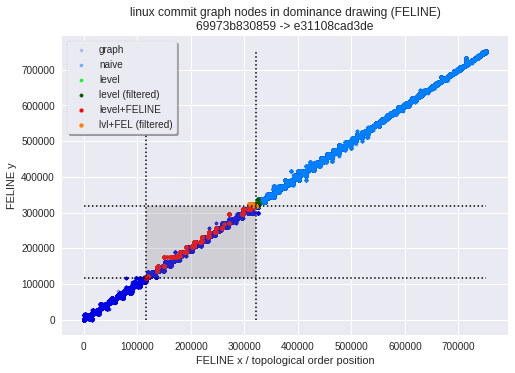

u=69973b830859 position is (116739, 116724), level is 125001
v=e31108cad3de position is (322134, 318010), level is 98366
- naive walked 435550
- level walked 9022
- level+feline walked 1326
there are 199709 nodes out of 752282 in inclusion zone


In [0]:
#@title linux: v4.9 -> dst feline plot { form-width: "30%" }
graph=linux_graph_full
stats=prepared_stats(stats_l)
pos=graph.fel

plt.title('linux commit graph nodes in dominance drawing (FELINE)\n'+
          ''+u+' -> '+v+'')
plt.xlabel('FELINE x / topological order position')
plt.ylabel('FELINE y')

show_graph  = True #@param {type:"boolean"}
show_naive  = True #@param {type:"boolean"}
show_levels = True #@param {type:"boolean"}
show_feline = True #@param {type:"boolean"}

ax=plt.gca()
ax.add_patch(
  mpatches.Rectangle(
    pos[u],
    pos[v][0] - pos[u][0],
    pos[v][1] - pos[u][1],
    facecolor="grey",alpha=0.25
  )
)

xarr = np.array([x for (x,y) in pos.values()])
yarr = np.array([y for (x,y) in pos.values()])
plt.vlines([pos[u][0],pos[v][0]],0,np.amax(yarr),lw=1.5,linestyles='dotted')
plt.hlines([pos[u][1],pos[v][1]],0,np.amax(xarr),lw=1.5,linestyles='dotted')
if show_graph:
  plt.scatter(x=xarr, y=yarr, s=10,
             c=(0.0,0.0,0.9,0.2), label='graph')

if show_naive:
  xarr = np.array([x for (n,(x,y)) in pos.items()
                   if n in stats['naive']['walk']])
  yarr = np.array([y for (n,(x,y)) in pos.items()
                   if n in stats['naive']['walk']])
  plt.scatter(x=xarr, y=yarr, s=10,
              c=(0.0,0.5,1.0,0.5), label='naive')

if show_levels:
  xarr = np.array([x for (n,(x,y)) in pos.items() if n in stats['level']['walk']])
  yarr = np.array([y for (n,(x,y)) in pos.items() if n in stats['level']['walk']])
  plt.scatter(x=xarr, y=yarr, s=10,
              c=(0.0,1.0,0.0,1.0), label='level')

  xarr = np.array([x for (n,(x,y)) in pos.items() if n in stats['level']['level-filter']])
  yarr = np.array([y for (n,(x,y)) in pos.items() if n in stats['level']['level-filter']])
  plt.scatter(x=xarr, y=yarr, s=12,
              c=(0.0,0.35,0.0,1.0), label='level (filtered)')
  
if show_feline:
  xarr = np.array([x for (n,(x,y)) in pos.items() if n in stats['level+feline']['walk']])
  yarr = np.array([y for (n,(x,y)) in pos.items() if n in stats['level+feline']['walk']])
  plt.scatter(x=xarr, y=yarr, s=14,
              c=(1.0,0.0,0.0,1.0), label='level+FELINE')
  
  xarr = np.array([x for (n,(x,y)) in pos.items()
                   if n in stats['level+feline']['level-filter'] or 
                      n in stats['level+feline']['feline-filter']])
  yarr = np.array([y for (n,(x,y)) in pos.items()
                   if n in stats['level+feline']['level-filter'] or 
                      n in stats['level+feline']['feline-filter']])
  plt.scatter(x=xarr, y=yarr, s=16,
              c=(1.0,0.5,0.0,1.0), label='lvl+FEL (filtered)')

plt.legend(frameon=True,fancybox=True,shadow=True)
plt.show()

print('u=%s position is %r, level is %d' % (u,pos[u],graph.lvl[u]))
print('v=%s position is %r, level is %d' % (v,pos[v],graph.lvl[v]))
for walk in sorted(stats, key=lambda k: len(stats[k]['walk']), reverse=True):
  print('- %s walked %d' % (walk, len(stats[walk]['walk'])))
  
gray_count = 0
for n in pos:
  if is_pair_leq(pos[u], pos[n]) and \
     is_pair_leq(pos[n], pos[v]):
    gray_count += 1
print('there are %d nodes out of %d in inclusion zone' %
      (gray_count, graph.number_of_nodes()))

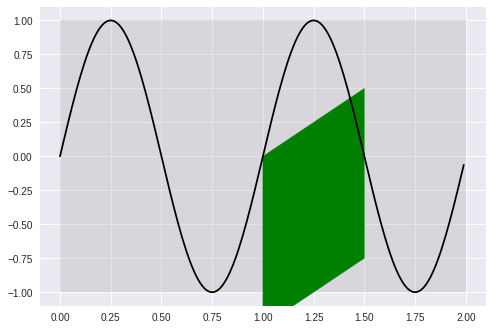

In [24]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

ax = plt.gca()

t = np.arange(0.0, 2, 0.01)
s = np.sin(2*np.pi*t)

clip_rect = mpatches.Rectangle((0,-1),2,2,color='#aaaaaa',alpha=0.3)
patch = mpatches.Polygon(
        [[1.0,0.0],[1.5,0.5],[1.5,-0.75],[1.0,-1.25]],
        closed=True,
        color='g',fill=True,
        clip_path=clip_rect,clip_on=True,
    )
# for some reason it doesn't work...
patch.set_clip_path(clip_rect)

ax.add_patch(clip_rect)
ax.add_patch(patch)

plt.plot(t, s, color='black', label='sin(x)')
xslack=0.1
yslack=0.1
ax.set_xbound( 0-xslack, 2+xslack)
ax.set_ybound(-1-yslack, 1+yslack)
plt.show()

#matplotlib.artist.getp(patch)

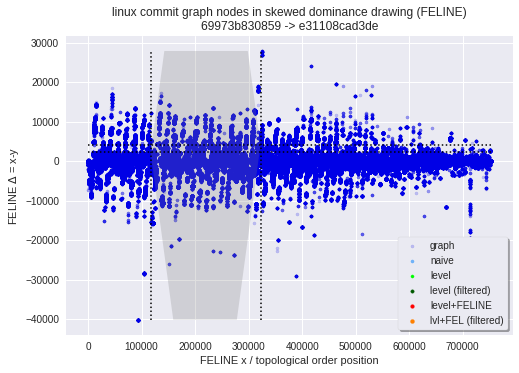

- naive walked 39590
- level walked 2491
- level+feline walked 215
there are 199709 nodes out of 752373 in inclusion zone
CPU times: user 39.2 s, sys: 820 ms, total: 40 s
Wall time: 39.7 s


In [0]:
#@title linux: v4.9 -> dst feline skewed { form-width: "30%" }
%%time

graph=linux_graph_full
if not stats:
  stats=prepared_stats(stats_l)
pos=graph.fel

plt.title('linux commit graph nodes in skewed dominance drawing (FELINE)\n'+
          ''+u+' -> '+v+'')
plt.xlabel('FELINE x / topological order position')
plt.ylabel('FELINE $\Delta$ = x-y')

show_graph  = True #@param {type:"boolean"}
show_naive  = True #@param {type:"boolean"}
show_levels = True #@param {type:"boolean"}
show_feline = True #@param {type:"boolean"}

xarr = np.array([x for (x,y) in pos.values()])
yarr = np.array([(x-y) for (x,y) in pos.values()])
xmin = np.amin(xarr)
xmax = np.amax(xarr)
ymin = np.amin(yarr)
ymax = np.amax(yarr)
yamax = max(-ymin,ymax)

ax=plt.gca()
ax.add_patch(
  # assume clipped TODO: fix!!!
  mpatches.Polygon(
    xy=np.array([
        (pos[u][0], pos[u][0]-pos[u][1]),
        (pos[u][0]-(pos[u][0]-pos[u][1])+ymax, ymax),
        (pos[v][0]+(pos[v][0]-pos[v][1])-ymax, ymax),
        (pos[v][0], pos[v][0]-pos[v][1]),
        (pos[v][0]-(pos[v][0]-pos[v][1])+ymin, ymin),
        (pos[u][0]+(pos[u][0]-pos[u][1])-ymin, ymin),
    ]),
    closed=True,
    facecolor="grey",alpha=0.25
  )
)

plt.vlines([pos[u][0],pos[v][0]],
           np.amin(yarr),np.amax(yarr),
           lw=1.5,linestyles='dotted')
plt.hlines([pos[u][0]-pos[u][1],pos[v][0]-pos[v][1]],
           0,np.amax(xarr),
           lw=1.5,linestyles='dotted')
if show_graph:
  plt.scatter(x=xarr, y=yarr, s=10,
              c=(0.0,0.0,0.9,0.2), label='graph')

if show_naive:
  xarr = np.array([x for (n,(x,y)) in pos.items()
                   if n in stats['naive']['walk']])
  yarr = np.array([(x-y) for (n,(x,y)) in pos.items()
                   if n in stats['naive']['walk']])
  plt.scatter(x=xarr, y=yarr, s=10,
              c=(0.0,0.5,1.0,0.5), label='naive')

if show_levels:
  xarr = np.array([x for (n,(x,y)) in pos.items() if n in stats['level']['walk']])
  yarr = np.array([(x-y) for (n,(x,y)) in pos.items() if n in stats['level']['walk']])
  plt.scatter(x=xarr, y=yarr, s=10,
              c=(0.0,1.0,0.0,1.0), label='level')

  xarr = np.array([x for (n,(x,y)) in pos.items() if n in stats['level']['level-filter']])
  yarr = np.array([(x-y) for (n,(x,y)) in pos.items() if n in stats['level']['level-filter']])
  plt.scatter(x=xarr, y=yarr, s=12,
              c=(0.0,0.35,0.0,1.0), label='level (filtered)')
  
if show_feline:
  xarr = np.array([x for (n,(x,y)) in pos.items() if n in stats['level+feline']['walk']])
  yarr = np.array([(x-y) for (n,(x,y)) in pos.items() if n in stats['level+feline']['walk']])
  plt.scatter(x=xarr, y=yarr, s=14,
              c=(1.0,0.0,0.0,1.0), label='level+FELINE')
  
  xarr = np.array([x for (n,(x,y)) in pos.items()
                   if n in stats['level+feline']['level-filter'] or 
                      n in stats['level+feline']['feline-filter']])
  yarr = np.array([(x-y) for (n,(x,y)) in pos.items()
                   if n in stats['level+feline']['level-filter'] or 
                      n in stats['level+feline']['feline-filter']])
  plt.scatter(x=xarr, y=yarr, s=16,
              c=(1.0,0.5,0.0,1.0), label='lvl+FEL (filtered)')

ax.set_ybound(-yamax*1.1, yamax*1.1)
  
plt.legend(frameon=True,fancybox=True,shadow=True)
plt.show()

#print('u=%s position is %r, level is %d' % (u,pos[u],graph.lvl[u]))
#print('v=%s position is %r, level is %d' % (v,pos[v],graph.lvl[v]))
for walk in sorted(stats, key=lambda k: len(stats[k]['walk']), reverse=True):
  print('- %s walked %d' % (walk, len(stats[walk]['walk'])))
  
gray_count = 0
for n in pos:
  if is_pair_leq(pos[u], pos[n]) and \
     is_pair_leq(pos[n], pos[v]):
    gray_count += 1
print('there are %d nodes out of %d in inclusion zone' %
      (gray_count, graph.number_of_nodes()))

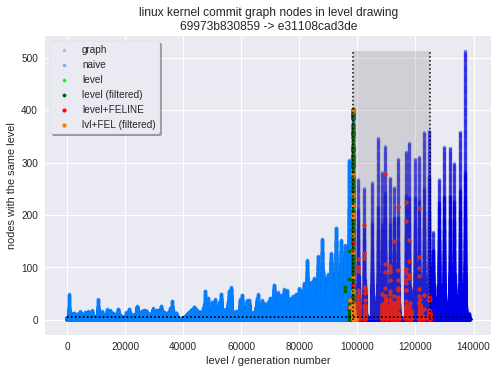

u=69973b830859 position is (125001, 5), level is 125001
v=e31108cad3de position is (98366, 5), level is 98366
- naive walked 435550
- level walked 9022
- level+feline walked 1326
there are 216310 nodes out of 752282 in level-cut inclusion zone
CPU times: user 44.5 s, sys: 1.37 s, total: 45.8 s
Wall time: 45 s


In [0]:
#@title linux: v4.9 -> dst levels plot { form-width: "30%" }
%%time
graph = linux_graph_full

level_counts_dict = defaultdict(int)
graph.lvlpos = {}
for node in graph:
  x = graph.lvl[node]
  level_counts_dict[x] += 1
  y = level_counts_dict[x]
  
  graph.lvlpos[node] = (x, y)
  
pos = graph.lvlpos

plt.title('linux kernel commit graph nodes in level drawing\n'+
          ''+u+' -> '+v+'')
plt.xlabel('level / generation number')
plt.ylabel('nodes with the same level')

show_levels = True #@param {type:"boolean"}
show_feline = True #@param {type:"boolean"}

xarr = np.array([x for (x,y) in pos.values()])
yarr = np.array([y for (x,y) in pos.values()])

ax=plt.gca()
ax.add_patch(
  mpatches.Rectangle(
    (pos[u][0], 0),
    pos[v][0] - pos[u][0],
    np.amax(yarr),
    facecolor="grey",alpha=0.25
  )
)

plt.vlines([pos[u][0],pos[v][0]],0,np.amax(yarr),lw=1.5,linestyles='dotted')
plt.hlines([pos[u][1],pos[v][1]],0,np.amax(xarr),lw=1.5,linestyles='dotted')
plt.scatter(x=xarr, y=yarr, s=10,
            c=(0.0,0.0,0.9,0.2), label='graph')

xarr = np.array([x for (n,(x,y)) in pos.items()
                 if n in stats['naive']['walk']])
yarr = np.array([y for (n,(x,y)) in pos.items()
                 if n in stats['naive']['walk']])
plt.scatter(x=xarr, y=yarr, s=10,
            c=(0.0,0.5,1.0,0.5), label='naive')

if show_levels:
  xarr = np.array([x for (n,(x,y)) in pos.items()
                   if n in stats['level']['walk']])
  yarr = np.array([y for (n,(x,y)) in pos.items()
                   if n in stats['level']['walk']])
  plt.scatter(x=xarr, y=yarr, s=10,
              c=(0.0,1.0,0.0,1.0), label='level')

  xarr = np.array([x for (n,(x,y)) in pos.items()
                   if n in stats['level']['level-filter']])
  yarr = np.array([y for (n,(x,y)) in pos.items()
                   if n in stats['level']['level-filter']])
  plt.scatter(x=xarr, y=yarr, s=12,
              c=(0.0,0.35,0.0,1.0), label='level (filtered)')
  
if show_feline:
  xarr = np.array([x for (n,(x,y)) in pos.items()
                   if n in stats['level+feline']['walk']])
  yarr = np.array([y for (n,(x,y)) in pos.items()
                   if n in stats['level+feline']['walk']])
  plt.scatter(x=xarr, y=yarr, s=14,
              c=(1.0,0.0,0.0,1.0), label='level+FELINE')
  
  xarr = np.array([x for (n,(x,y)) in pos.items()
                   if n in stats['level+feline']['level-filter'] or 
                      n in stats['level+feline']['feline-filter']])
  yarr = np.array([y for (n,(x,y)) in pos.items()
                   if n in stats['level+feline']['level-filter'] or 
                      n in stats['level+feline']['feline-filter']])
  plt.scatter(x=xarr, y=yarr, s=16,
              c=(1.0,0.5,0.0,1.0), label='lvl+FEL (filtered)')

plt.legend(frameon=True,fancybox=True,shadow=True)
plt.show()

print('u=%s position is %r, level is %d' % (u,pos[u],graph.lvl[u]))
print('v=%s position is %r, level is %d' % (v,pos[v],graph.lvl[v]))
for walk in sorted(stats, key=lambda k: len(stats[k]['walk']), reverse=True):
  print('- %s walked %d' % (walk, len(stats[walk]['walk'])))
  
gray_count = 0
for n in pos:
  if graph.lvl[u] >= graph.lvl[n] and \
     graph.lvl[n] >= graph.lvl[v]:
    gray_count += 1
print('there are %d nodes out of %d in level-cut inclusion zone' %
      (gray_count, graph.number_of_nodes()))

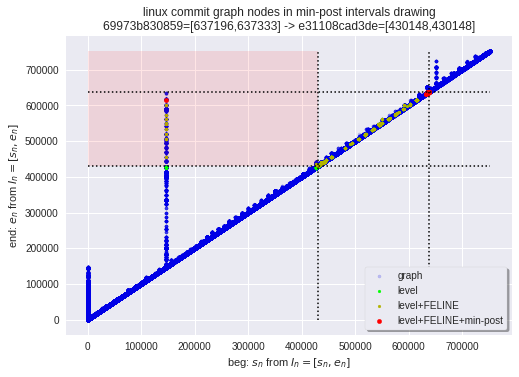

CPU times: user 26.7 s, sys: 946 ms, total: 27.6 s
Wall time: 27 s


In [0]:
#@title linux: v4.9 -> dst min-post plot { form-width: "30%" }
%%time
graph=linux_graph_full
pos=graph.mpi

plt.title('linux commit graph nodes in min-post intervals drawing\n'+
          u+'=['+str(pos[u][0])+','+str(pos[u][1])+'] -> '+
          v+'=['+str(pos[v][0])+','+str(pos[v][1])+']')
plt.xlabel('beg: $s_n$ from $I_n = [s_n, e_n]$')
plt.ylabel('end: $e_n$ from $I_n = [s_n, e_n]$')

xarr = np.array([x for (x,y) in pos.values()])
yarr = np.array([y for (x,y) in pos.values()])

ax=plt.gca()
ax.add_patch(
  mpatches.Rectangle(
    pos[v],
    - pos[v][0],
    np.amax(yarr) - pos[v][1],
    facecolor="red",alpha=0.10
  )
)

plt.vlines([pos[u][0],pos[v][0]],0,np.amax(yarr),lw=1.5,linestyles='dotted')
plt.hlines([pos[u][1],pos[v][1]],0,np.amax(xarr),lw=1.5,linestyles='dotted')
plt.scatter(x=xarr, y=yarr, s=10,
            c=(0.0,0.0,0.9,0.2), label='graph')

xarr = np.array([x for (n,(x,y)) in pos.items()
                 if n in stats['level']['walk']])
yarr = np.array([y for (n,(x,y)) in pos.items()
                 if n in stats['level']['walk']])
plt.scatter(x=xarr, y=yarr, s=8,
            c=(0.0,1.0,0.0,1.0), label='level')

xarr = np.array([x for (n,(x,y)) in pos.items()
                 if n in stats['level+feline']['walk']])
yarr = np.array([y for (n,(x,y)) in pos.items()
                 if n in stats['level+feline']['walk']])
plt.scatter(x=xarr, y=yarr, s=8,
            c=(0.7,0.7,0.0,1.0), label='level+FELINE')

xarr = np.array([x for (n,(x,y)) in pos.items()
                 if n in stats_l['level+feline+mpi']['walk']])
yarr = np.array([y for (n,(x,y)) in pos.items()
                 if n in stats_l['level+feline+mpi']['walk']])
plt.scatter(x=xarr, y=yarr, s=20,
            c=(1.0,0.0,0.0,1.0), label='level+FELINE+min-post')

plt.legend(frameon=True,fancybox=True,shadow=True)
plt.show()

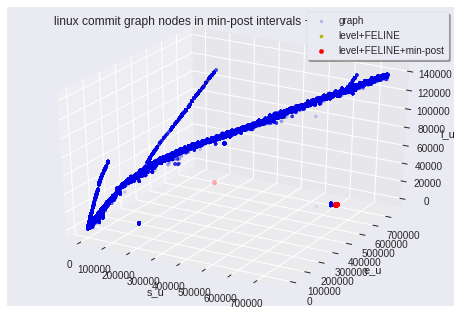

In [0]:
#%%time
from mpl_toolkits.mplot3d import Axes3D

graph=linux_graph_full
pos=graph.mpi

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_title('linux commit graph nodes in min-post intervals + levels 3d drawing')

xarr = np.array([x for (x,y) in pos.values()])
yarr = np.array([y for (x,y) in pos.values()])
larr = np.array([graph.lvl[n] for n in pos.keys()])

ax.scatter(xarr, yarr, larr, s=10,
           c=(0.0,0.0,0.9,0.2), label='graph')

xarr = np.array([x for (n,(x,y)) in pos.items()
                 if n in stats['level+feline']['walk']])
yarr = np.array([y for (n,(x,y)) in pos.items()
                 if n in stats['level+feline']['walk']])
larr = np.array([graph.lvl[n] for (n,(x,y)) in pos.items()
                 if n in stats['level+feline']['walk']])
ax.scatter(xarr, yarr, larr, s=10,
           c=(0.7,0.7,0.0,1.0), label='level+FELINE')

xarr = np.array([x for (n,(x,y)) in pos.items()
                 if n in stats_l['level+feline+mpi']['walk']])
yarr = np.array([y for (n,(x,y)) in pos.items()
                 if n in stats_l['level+feline+mpi']['walk']])
larr = np.array([graph.lvl[n] for (n,(x,y)) in pos.items()
                 if n in stats_l['level+feline+mpi']['walk']])
plt.scatter(x=xarr, y=yarr, s=20,
            c=(1.0,0.0,0.0,1.0), label='level+FELINE+min-post')

ax.set_xlabel('s_u')
ax.set_ylabel('e_u')
ax.set_zlabel('l_u')

plt.legend(frameon=True,fancybox=True,shadow=True)
plt.show()


#### N^2 connectivity on random sample of commits / nodes

In [0]:
%%time

graph = linux_graph_full
n_nodes = graph.number_of_nodes()

choice = np.random.choice(n_nodes*n_nodes, 10000)
conn_choice = [(x % n_nodes,x // n_nodes) for x in choice]

nodes_dict = {num: v for (num,v) in enumerate(list(graph))}
conn_nodes = {(nodes_dict[u], nodes_dict[v]) for (u,v) in conn_choice}

print('%4d sample size' % len(conn_nodes))

In [0]:
%%time

graph = linux_graph_full

heads = find_heads(graph)
roots = find_roots(graph)
print('linux commit graph has %d tips / heads ("roots"): %r' % (len(heads),heads))
print('linux commit graph has %d roots ("leaves"): %r' % (len(roots),roots))

print('linux commit graph has average clustering coefficient %g (%d trials ?)\n' %
      (nx.average_clustering(graph.to_undirected()), 1000))
#print('linux commit graph has the diameter of %g\n' % nx.diameter(graph))

In [0]:
graph = linux_graph_full

print('%4d pairs\n' % len(conn_nodes))
%time pos,neg,reach = split_connected_ex(graph, conn_nodes)
print('')
print('%4d are connected: %r' % (len(pos), pos[:10]))
print('%4d not connected: %r' % (len(neg), neg[:10]))
print('the hash has %d elements' % len(reach))

In [0]:
graph = linux_graph_full

n_nodes = graph.number_of_nodes()
print('linux commit graph has %d possible paths' % (n_nodes*(n_nodes-1)))
print('sample has %d node pairs [%g%%]\n' %
      (len(conn_nodes),100.0*len(conn_nodes)/(n_nodes*(n_nodes-1))))

%time lvl_fp = level_fp_sample(graph, graph.lvl, conn_nodes)
%time fel_fp = feline_fp_sample(graph, graph.fel, conn_nodes)

n_lvl_fp = len(lvl_fp)
n_fel_fp = len(fel_fp)
n_samples = len(conn_nodes)
print('\nlevel-filter has %5d = %5.2f%% [all] false positives' %
      (n_lvl_fp, 100.0*n_lvl_fp/n_samples))
print('FELINE index has %5d = %5.2f%% [all] false positives' %
      (n_fel_fp, 100.0*n_fel_fp/n_samples))
print('FELINE index has %g less false positives than level filter' %
      (float(n_lvl_fp)/float(n_fel_fp)))

In [0]:
graph = linux_graph_full

print('linux commit graph was created from %d edges' % (len(edges)))
n_nodes = graph.number_of_nodes()
print('linux commit graph has %d nodes and %d edges (size)' %
      (n_nodes, graph.size()))
print('linux commit graph has %d possible paths\n' % (n_nodes*(n_nodes-1)))

print('\ncalculating min-post spanning-tree intervals')
%time graph.mpi = find_dfs_intervals(graph)
graph.mpi_repr={
  v:('[%d,%d]'%(i[0],i[1]))
  for (v,i) in graph.mpi.items()
}

In [0]:
graph = linux_graph_full

n_nodes = graph.number_of_nodes()
print('linux commit graph has %d possible paths' % (n_nodes*(n_nodes-1)))
print('sample has %d node pairs [%g%%]\n' %
      (len(conn_nodes),100.0*len(conn_nodes)/(n_nodes*(n_nodes-1))))

%time mpi_fp = interval_fn_sample(graph, graph.mpi, conn_nodes)

n_mpi_fp = len(mpi_fp)
n_samples = len(conn_nodes)
print('\nmin-post spanning-tree intervals has %5d = %5.2f%% [all] false negatives' %
      (n_mpi_fp, 100.0*n_mpi_fp/n_samples))